In [1]:
%config InlineBackend.figure_formats = ['retina']  # increase resolution on retina screens
import numpy as np
import scanpy as sc
import scipy as sci
import re
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle
from scipy import stats
from sklearn.svm import NuSVR
sc.settings.figdir = './write/results/sc_bulk_pbmc/'
results_file = './write/results/test/sc_bulk_pbmc/'

/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import sys
print(sys.version)
#print(f'This is python version {version_num}')

3.6.5 (default, Mar 29 2018, 18:20:46) 
[GCC 8.0.1 20180317 (Red Hat 8.0.1-0.19)]


In [3]:
# Read bulks

In [4]:
bulks_dir = './pbmc/cell19/rnaseq/'
data = pd.read_csv(bulks_dir+'GSE107011_Processed_data_TPM.txt', index_col=0, delimiter = '\t')
data.shape

(58311, 127)

In [5]:
data2 = pd.read_csv(bulks_dir+'TPMPBMC.txt', index_col=0, delimiter = '\t')

In [6]:
fractions_raw = pd.read_csv(bulks_dir+'wholeGenes/fractions.txt', index_col=0, delimiter = '\t')
print(fractions_raw.columns)

Index(['Progenitors', 'B Naive', 'B NSM', 'B SM', 'B Ex', 'Plasmablasts',
       'T CD4 Naive', 'Tregs', 'Tfh', 'Th1', 'Th1/Th17', 'Th17', 'Th2',
       'T CD4 TE', 'T CD8 Naive', 'T CD8 CM', 'T CD8 EM', 'T CD8 TE',
       'T gd Vd2', 'T gd non-Vd2', 'MAIT', 'NK', 'pDCs', 'mDCs', 'Monocytes C',
       'Monocytes I', 'Monocytes NC', 'Neutrophils LD', 'Basophils LD'],
      dtype='object')


In [7]:
annotations = pd.read_csv(bulks_dir+'annotations.txt', index_col=0, delimiter = '\t')

In [8]:
ERCC_data = data.loc[[x for x in data.index if 'ERCC-' in x]]
#data = data/np.mean(ERCC_data,axis=0)

In [9]:
data = data.loc[[x for x in data.index if 'ERCC-' not in x]]
index = [x.split(".")[0] for x in data.index]
data.index = index

duplicatedData = data[data.index.duplicated()]
data = data[data.index.duplicated()==False]
data.shape

(58174, 127)

In [10]:
np.mean(data, axis=0)

DZQV_CD8_naive    17.035387
DZQV_CD8_CM       17.030858
DZQV_CD8_EM       17.115087
DZQV_CD8_TE       17.057600
DZQV_MAIT         17.101574
                    ...    
9JD4_PBMC         17.162650
G4YW_PBMC         17.138255
4DUY_PBMC         17.170048
36TS_PBMC         17.058209
CR3L_PBMC         17.147355
Length: 127, dtype: float64

In [11]:
data.index.duplicated().any()

False

In [12]:
samples = data.loc[:,[x for x in data.columns if '_PBMC' in x]]

In [13]:
sorted_bulks_raw = data.loc[:,[x for x in data.columns if '_PBMC' not in x]]
cellTypes_29 = [x[5:] for x in sorted_bulks_raw.columns if '9JD4' in x]
sorted_bulks_raw.columns = [x[5:] for x in sorted_bulks_raw.columns]

In [14]:
sorted_bulks = pd.DataFrame(index=sorted_bulks_raw.index, columns = cellTypes_29)
for col in cellTypes_29:
    sorted_bulks.loc[:,col] = np.mean(sorted_bulks_raw.loc[:,col],axis=1)
print(sorted_bulks.shape)
print(sorted_bulks.columns)

(58174, 29)
Index(['CD8_naive', 'CD8_CM', 'CD8_EM', 'CD8_TE', 'MAIT', 'VD2+', 'VD2-',
       'TFH', 'Treg', 'Th1', 'Th1/Th17', 'Th17', 'Th2', 'CD4_naive', 'CD4_TE',
       'Progenitor', 'B_naive', 'B_NSM', 'B_Ex', 'B_SM', 'Plasmablasts',
       'C_mono', 'I_mono', 'NC_mono', 'NK', 'pDC', 'mDC', 'Neutrophils',
       'Basophils'],
      dtype='object')


In [15]:
sorted_bulks.columns = ['T CD8 Naive','T CD8 CM','T CD8 EM','T CD8 TE','MAIT','T gd Vd2', 'T gd non-Vd2','Tfh','Tregs','Th1'
 ,'Th1/Th17','Th17', 'Th2','T CD4 Naive','T CD4 TE','Progenitors','B Naive', 'B NSM', 'B Ex', 'B SM', 
 'Plasmablasts','Monocytes C','Monocytes I', 'Monocytes NC', 'NK','pDCs', 'mDCs', 'Neutrophils LD','Basophils LD']
fractions_raw = fractions_raw.loc[:,sorted_bulks.columns]
print(np.all(fractions_raw.columns==sorted_bulks.columns))
print(fractions_raw.columns)

True
Index(['T CD8 Naive', 'T CD8 CM', 'T CD8 EM', 'T CD8 TE', 'MAIT', 'T gd Vd2',
       'T gd non-Vd2', 'Tfh', 'Tregs', 'Th1', 'Th1/Th17', 'Th17', 'Th2',
       'T CD4 Naive', 'T CD4 TE', 'Progenitors', 'B Naive', 'B NSM', 'B Ex',
       'B SM', 'Plasmablasts', 'Monocytes C', 'Monocytes I', 'Monocytes NC',
       'NK', 'pDCs', 'mDCs', 'Neutrophils LD', 'Basophils LD'],
      dtype='object')


In [16]:
sorted_bulks_selection = pd.DataFrame(index = sorted_bulks.index)
sorted_bulks_selection['Monocytes'] = sorted_bulks.loc[:,['Monocytes C', 'Monocytes I', 'Monocytes NC','Neutrophils LD','Basophils LD']].mean(axis=1)
sorted_bulks_selection['CD4+ T-cells'] = sorted_bulks.loc[:,['T CD4 Naive','Tregs','Tfh', 'Th1', 'Th1/Th17', 'Th17','Th2', 'T CD4 TE','T gd Vd2','T gd non-Vd2','MAIT']].mean(axis=1)
sorted_bulks_selection['CD8+ T-cells'] = sorted_bulks.loc[:,['T CD8 Naive','T CD8 CM','T CD8 EM','T CD8 TE']].mean(axis=1)
sorted_bulks_selection['Neutrophils'] = sorted_bulks.loc[:,'Neutrophils LD']
sorted_bulks_selection['NK cells'] = sorted_bulks.loc[:,'NK']
sorted_bulks_selection['B-cells'] = sorted_bulks.loc[:,['B Naive','B NSM','B SM', 'B Ex']].mean(axis=1)
sorted_bulks_selection.columns

Index(['Monocytes', 'CD4+ T-cells', 'CD8+ T-cells', 'Neutrophils', 'NK cells',
       'B-cells'],
      dtype='object')

In [17]:
fractions_selection = pd.DataFrame(index = fractions_raw.index)
fractions_selection['Monocytes'] = fractions_raw.loc[:,['Monocytes C', 'Monocytes I', 'Monocytes NC','Neutrophils LD','Basophils LD']].sum(axis=1)
fractions_selection['CD4+ T-cells'] = fractions_raw.loc[:,['T CD4 Naive','Tregs','Tfh', 'Th1', 'Th1/Th17', 'Th17','Th2', 'T CD4 TE']].sum(axis=1)
fractions_selection['CD8+ T-cells'] = fractions_raw.loc[:,['T CD8 Naive','T CD8 CM','T CD8 EM','T CD8 TE']].sum(axis=1)
fractions_selection['Neutrophils'] = fractions_raw.loc[:,'Neutrophils LD']
fractions_selection['NK cells'] = fractions_raw.loc[:,['NK','T gd Vd2','T gd non-Vd2','MAIT','pDCs']].sum(axis=1)
fractions_selection['B-cells'] = fractions_raw.loc[:,['B Naive','B NSM','B SM', 'B Ex']].sum(axis=1)
fractions_selection.columns

Index(['Monocytes', 'CD4+ T-cells', 'CD8+ T-cells', 'Neutrophils', 'NK cells',
       'B-cells'],
      dtype='object')

In [18]:
np.sum(fractions_selection,axis=1)

Sample Name
453W     94.870
684C     95.813
CR3L    102.482
FLWA     98.169
FY2H     98.376
CYFZ     91.919
925L     96.078
9JD4     97.187
G4YW     97.071
4DUY     96.004
CZJE     99.169
36TS     95.855
dtype: float64

# Read Control Single Cell

In [19]:
sc_dir_blood = './kevin_blood_immune_cells/'

blood_control = sc.read(sc_dir_blood+'input.txt', cache=True).transpose() 
blood_anno = pd.read_table(sc_dir_blood+'cell.annot.txt',index_col = 0)
blood_control.obs = blood_anno.loc[blood_control.obs_names]

## Processing Blood Single Cell

In [20]:
blood_control_norm = blood_control.copy()
sc.pp.normalize_per_cell(blood_control_norm, counts_per_cell_after=1e4)
blood_control_log = blood_control_norm.copy()
sc.pp.log1p(blood_control_log) 
#sc.pp.scale(adata_proc)

#adata_proc_raw = adata_proc.copy()

In [21]:
sc.pp.highly_variable_genes(blood_control, flavor='cell_ranger', n_top_genes=4000)

In [22]:
sc.pp.highly_variable_genes(blood_control_log, flavor='cell_ranger', n_top_genes=4000)
sc.pp.regress_out(blood_control_log, ['n_counts'])

... storing 'cells' as categorical


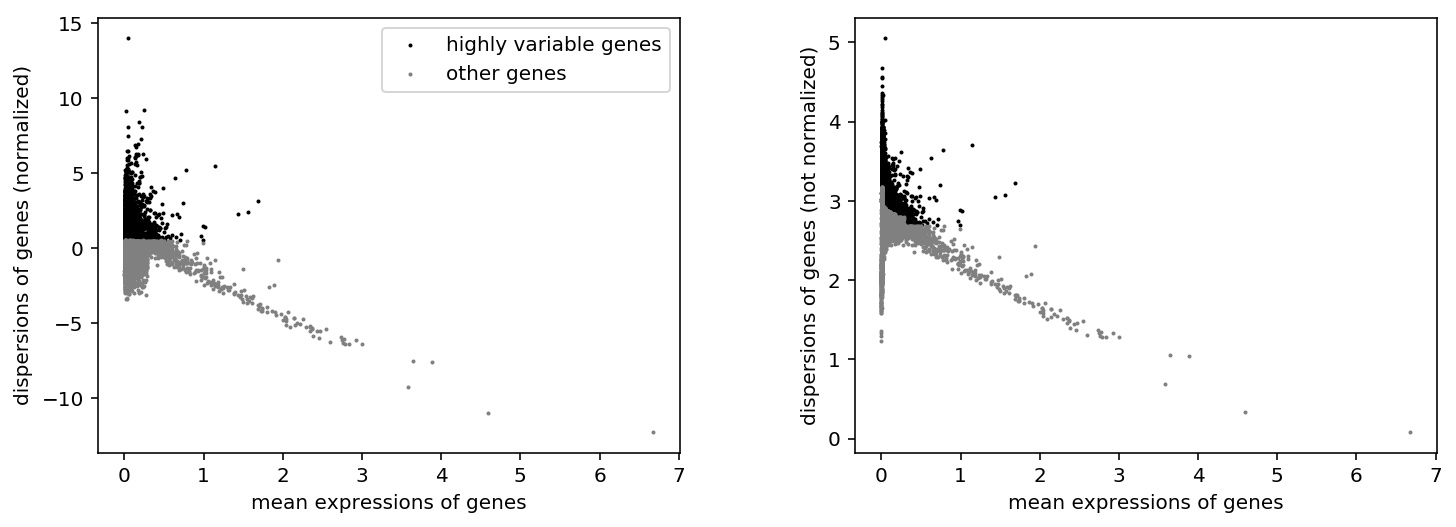

In [23]:
sc.pl.highly_variable_genes(blood_control_log)

In [24]:
sc.pp.scale(blood_control_log)

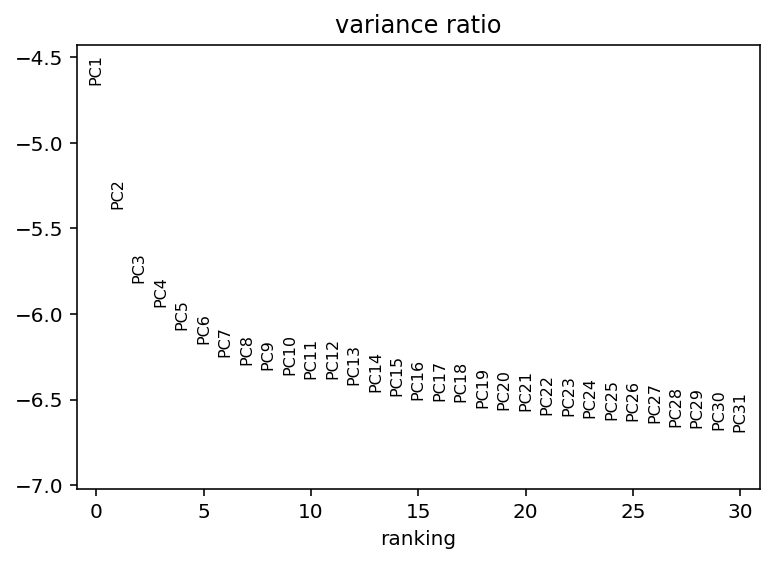

In [25]:
sc.pp.pca(blood_control_log, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(blood_control_log, log=True)

/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1120: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning,


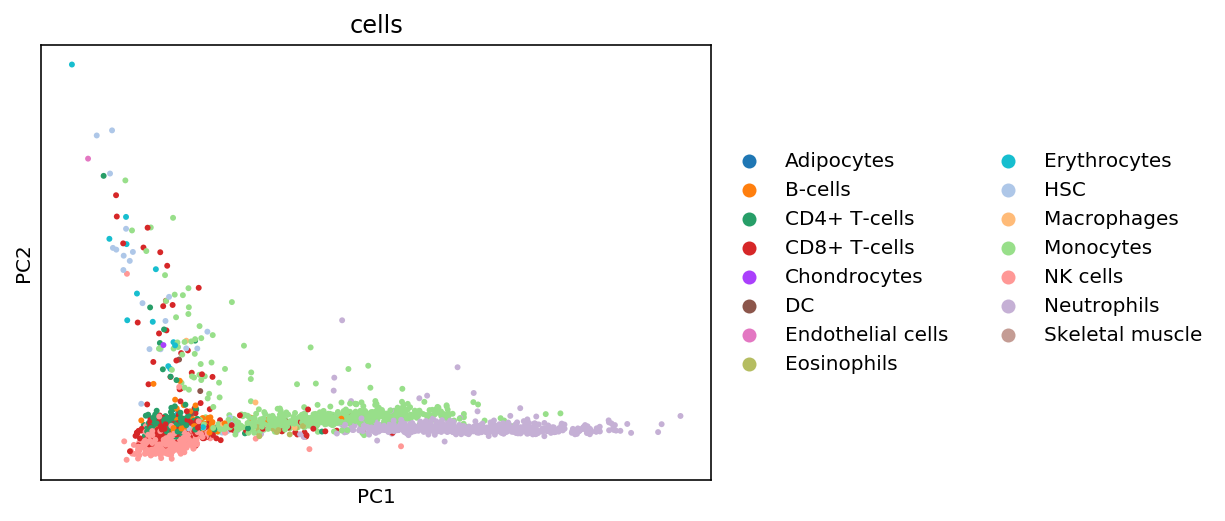

In [27]:
clusters = set(blood_control_norm.obs['cells'])
blood_control_log.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(blood_control_log[blood_control_log.obs_names[blood_control_log.obs['cells'].isin(clusters)]], color='cells', save = '_blood_kevin.pdf')

In [28]:
sc.pp.neighbors(blood_control_log, n_neighbors=30, n_pcs = 20)

In [29]:
sc.tl.umap(blood_control_log)

In [30]:
sc.set_figure_params(dpi=100, dpi_save=300, vector_friendly=True)
params = {'legend.fontsize': 8,
          'figure.figsize': (3, 3),
         'axes.labelsize':8,
         'axes.titlesize':8,
         'xtick.labelsize':8,
         'ytick.labelsize':8}
mpl.rcParams.update(params)

/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1120: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning,


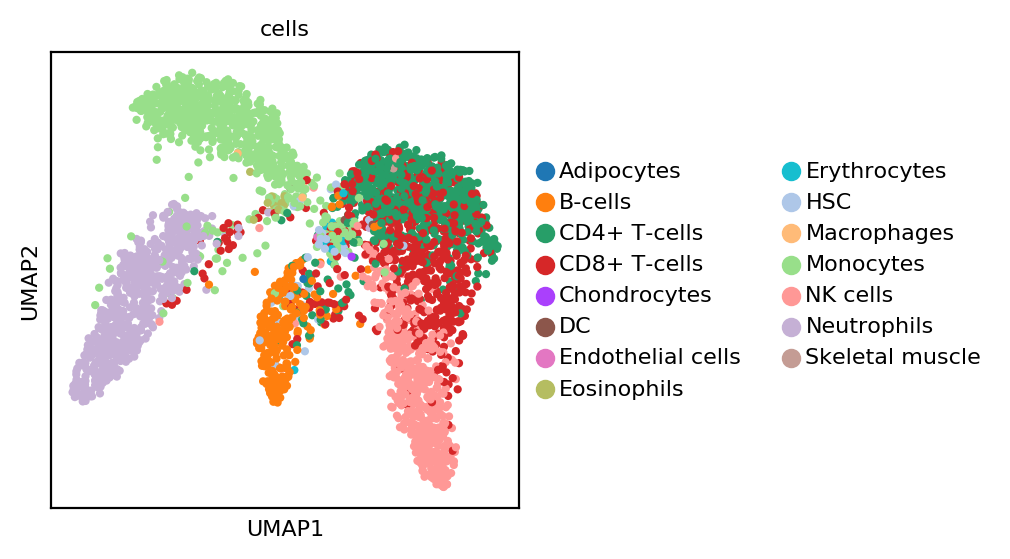

In [32]:
sc.pl.umap(blood_control_log[blood_control_log.obs_names[blood_control_log.obs['cells'].isin(clusters)]], color='cells', save = '_blood_kevin.pdf')

In [33]:
set(blood_control_log.obs['cells'])

{'Adipocytes',
 'B-cells',
 'CD4+ T-cells',
 'CD8+ T-cells',
 'Chondrocytes',
 'DC',
 'Endothelial cells',
 'Eosinophils',
 'Erythrocytes',
 'HSC',
 'Macrophages',
 'Monocytes',
 'NK cells',
 'Neutrophils',
 'Skeletal muscle'}

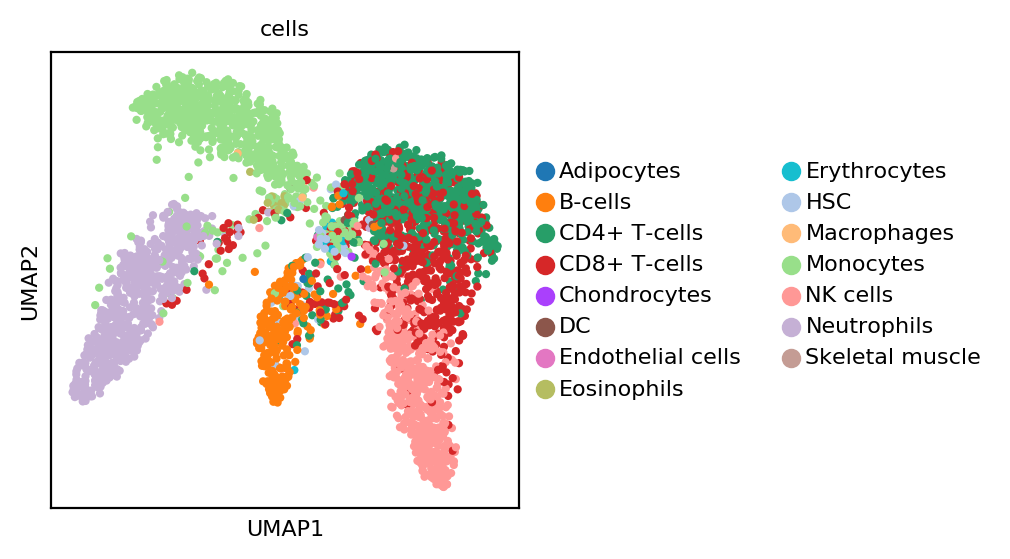

In [35]:
sc.pl.umap(blood_control_log, color='cells')#, palette=sc.pl.palettes.godsnot_64)

In [36]:
blood_control_log.obsm['X_umap'].shape

(3417, 2)

In [37]:
blood_control_log

AnnData object with n_obs × n_vars = 3417 × 12980 
    obs: 'cells', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'cells_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [38]:
blood_control_log.obs['cells'].value_counts()

Monocytes            711
CD4+ T-cells         652
CD8+ T-cells         617
Neutrophils          594
NK cells             511
B-cells              249
HSC                   45
Erythrocytes          15
Eosinophils           11
Macrophages            4
DC                     4
Skeletal muscle        1
Endothelial cells      1
Chondrocytes           1
Adipocytes             1
Name: cells, dtype: int64

# Mean expressions for Blood

In [39]:
blood_control_norm = blood_control_norm.copy()
#sc.pp.log1p(blood_control_log)

In [40]:
from sklearn.neighbors import NearestNeighbors
def KNearestNeighbors(n_neighbors, samples, centroid):
    neigh = NearestNeighbors(n_neighbors)
    neigh.fit(samples)
    return neigh.kneighbors(centroid, return_distance=False)

In [41]:
clusters = set(blood_control_norm.obs['cells'])


clustersToRemove = ['Skeletal muscle','Adipocytes','Chondrocytes','Endothelial cells','DC','Macrophages','Eosinophils','Erythrocytes','HSC']
clusters = clusters.difference(clustersToRemove)
print(clusters)

sc_mean = pd.DataFrame(index=blood_control_norm.var_names,columns=clusters)
sc_mean_log = pd.DataFrame(index=blood_control_log.var_names,columns=clusters)
for cluster in sc_mean.columns:
    cells = [x for x in blood_control_norm.obs_names if cluster==blood_control_norm.obs.loc[x,'cells']]
    sc_part = blood_control_norm[cells,:].X.T
    sc_part_log = blood_control_log[cells,:].X.T
    if (sc_part.shape!=(len(blood_control_norm.var_names),)):
        sc_mean[cluster] = pd.DataFrame(sc_part.mean(axis=1),index=blood_control_norm.var_names)
        sc_mean_log[cluster] = pd.DataFrame(sc_part_log.mean(axis=1),index=blood_control_log.var_names)
centroids_sc_blood = sc_mean.copy()
centroids_sc_blood_log = sc_mean_log.copy()

{'CD8+ T-cells', 'B-cells', 'NK cells', 'Monocytes', 'CD4+ T-cells', 'Neutrophils'}


In [42]:
centroids_blood = sc.AnnData(centroids_sc_blood.T)
centroids_blood.var_names = centroids_sc_blood.index
centroids_blood.obs_names = centroids_sc_blood.columns
sc.pp.highly_variable_genes(centroids_blood, flavor='cell_ranger', n_top_genes=4000)

In [43]:
centroids_blood_hv = centroids_sc_blood.copy()#pd.DataFrame(data = centroids_blood.X.T, index = centroids_blood.var_names, columns = centroids_blood.obs_names)
centroids_blood_hv = centroids_blood_hv.loc[blood_control_log.var[blood_control_log.var['highly_variable']==True].index]
sc_mean_log = sc_mean_log.loc[blood_control_log.var[blood_control_log.var['highly_variable']==True].index]
#centroids_sc_hv = centroids_sc.loc[BM_control.var[BM_control.var['highly_variable']==True].index]

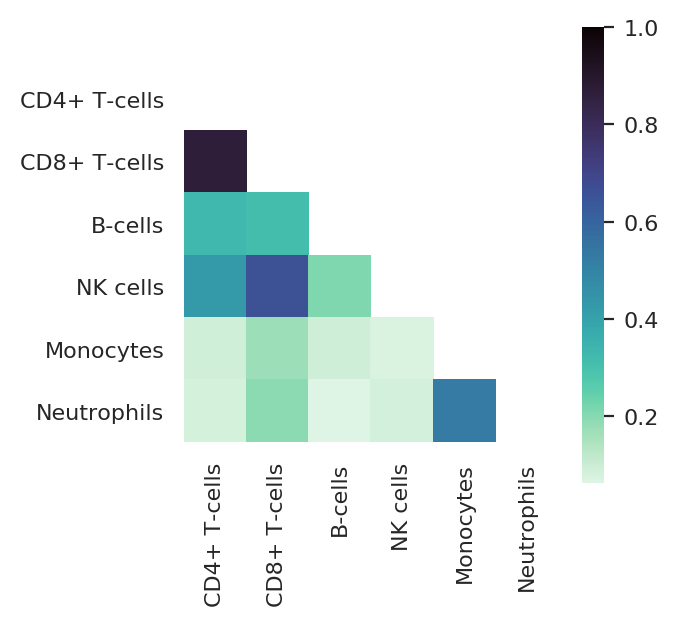

In [44]:
centroids_blood_hv = centroids_blood_hv[['CD4+ T-cells', 'CD8+ T-cells','B-cells', 'NK cells'
       ,'Monocytes', 'Neutrophils']]
corr = pd.DataFrame(data = np.corrcoef(centroids_blood_hv.T), columns = centroids_blood_hv.columns, index = centroids_blood_hv.columns)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot = sns.heatmap(corr, 
            xticklabels=corr.columns,mask=mask,cmap=sns.color_palette("mako_r", 1000),square=True)
sns_plot.figure.savefig(results_file+"corr_4k_hv.png",dpi=300, bbox_inches='tight')

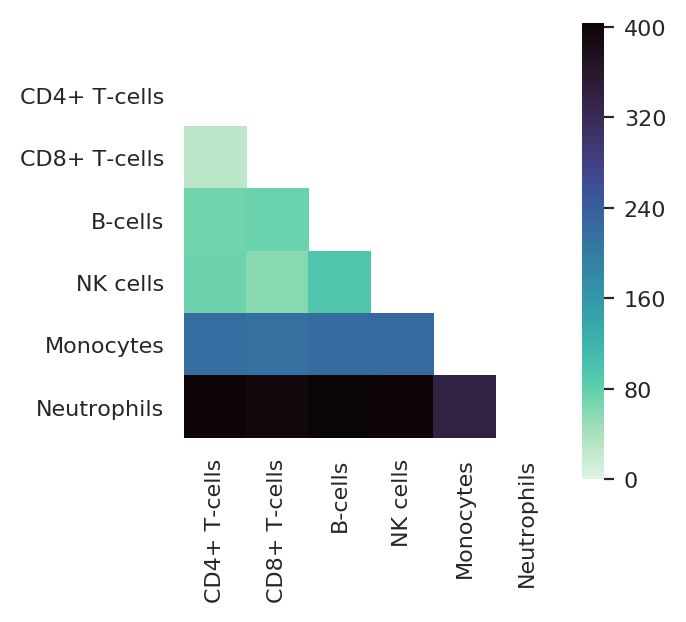

In [45]:
dist = pd.DataFrame(index = centroids_blood_hv.columns, columns= centroids_blood_hv.columns)
for cluster in centroids_blood_hv.columns:
    for c in centroids_blood_hv.columns:
        dist.loc[cluster,c] = sci.spatial.distance.euclidean(centroids_blood_hv.loc[:,c], centroids_blood_hv.loc[:,cluster])
dist = dist.astype(float)
mask = np.zeros_like(dist)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot = sns.heatmap(dist,
            xticklabels=dist.index,
            yticklabels=dist.index,mask=mask,cmap=sns.color_palette("mako_r", 1000),square=True)
sns_plot.figure.savefig(results_file+"dist_4k_hv.png",dpi=300, bbox_inches='tight')

# CiberSort

In [46]:
blood_control_log_hv = blood_control_log[:, blood_control_log.var[blood_control_log.var['highly_variable']==True].index]
blood_control_hv = blood_control[:, blood_control.var[blood_control_log.var['highly_variable']==True].index]

In [47]:
blood_control_log_hv = blood_control_log_hv[blood_control_log_hv.obs_names[blood_control_log_hv.obs['cells'].isin(['CD4+ T-cells', 'CD8+ T-cells','B-cells', 'NK cells','Monocytes', 'Neutrophils'])]]

In [48]:
set(blood_control_hv.obs['cells'])

{'Adipocytes',
 'B-cells',
 'CD4+ T-cells',
 'CD8+ T-cells',
 'Chondrocytes',
 'DC',
 'Endothelial cells',
 'Eosinophils',
 'Erythrocytes',
 'HSC',
 'Macrophages',
 'Monocytes',
 'NK cells',
 'Neutrophils',
 'Skeletal muscle'}

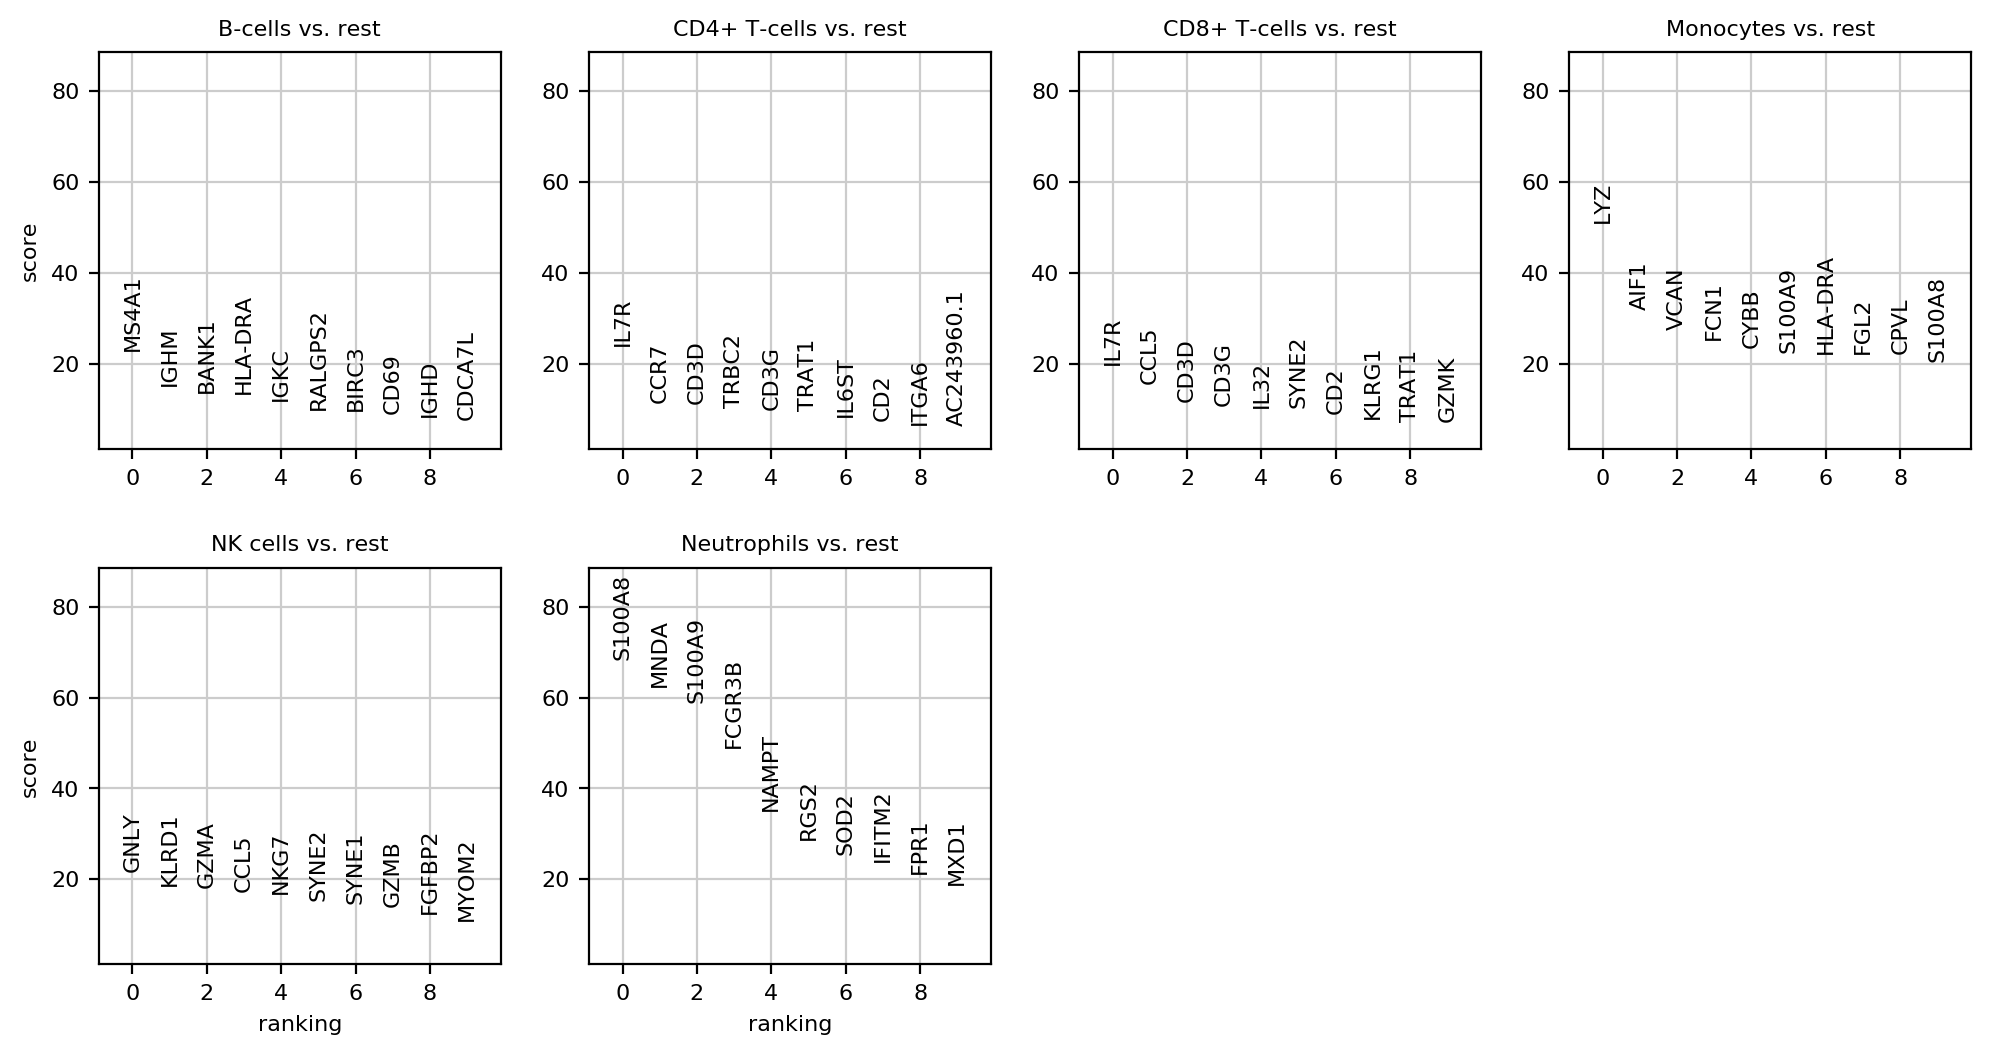

In [50]:
sc.tl.rank_genes_groups(blood_control_log_hv, 'cells', method='t-test', corr_method='benjamini-hochberg',n_genes=300)
sc.pl.rank_genes_groups(blood_control_log_hv, n_genes=10)

/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:222: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))
/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:201: RuntimeWarning: invalid value encountered in sqrt
  mean1=mean_group, std1=np.sqrt(var_group), nobs1=ns_group,
/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


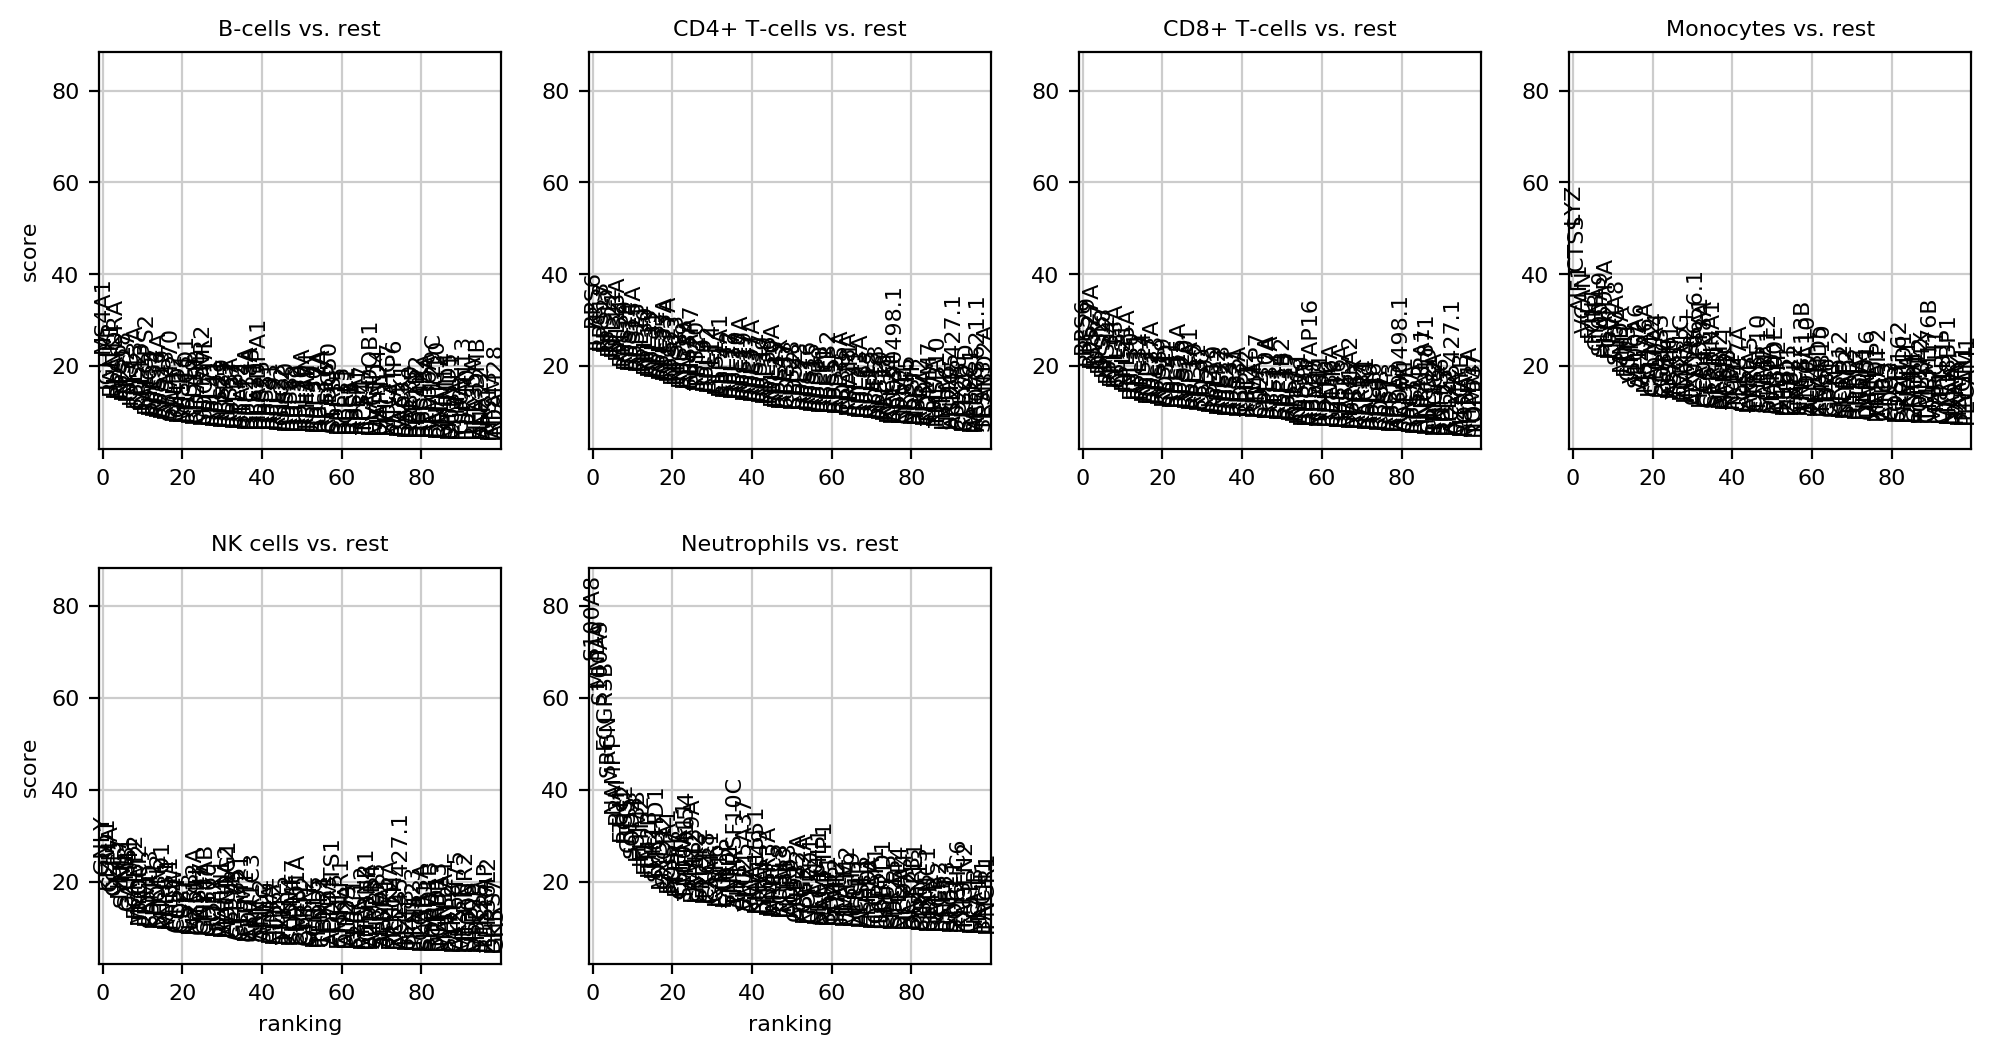

In [231]:
sc.tl.rank_genes_groups(blood_control_log_hv, 'cells', method='t-test', corr_method='benjamini-hochberg',n_genes=300)
sc.pl.rank_genes_groups(blood_control_log_hv, n_genes=100)

In [51]:
sc_mean_log.index.intersection(blood_control_log_hv.var_names)

Index(['AAAS', 'AAGAB', 'AARSD1', 'AATF', 'ABCA1', 'ABCA7', 'ABCB1', 'ABCC10',
       'ABCD4', 'ABHD2',
       ...
       'TREML2', 'TUBAP2', 'TVP23C', 'UBE2L5P', 'VPS37C', 'WDR18', 'Z84480.1',
       'ZC3HC1', 'ZNF415', 'ZNF691'],
      dtype='object', name='index', length=3999)

In [52]:
from numpy import linalg as LA
mg = pd.DataFrame(0, index=blood_control_log_hv.var_names, columns=list(set(blood_control_log_hv.obs['cells'])))
mgList = pd.DataFrame(columns=list(set(blood_control_log_hv.obs['cells'])))
mgSet = set()
for i in range(0,6):
    cluster = blood_control_log_hv.uns['rank_genes_groups']['names'].dtype.names[i]
    markers = [j[i] for j in blood_control_log_hv.uns['rank_genes_groups']['names']][:200]
    ordered = np.argsort([j[i] for j in blood_control_log_hv.uns['rank_genes_groups']['logfoldchanges']][:200])[::-1]
    mgList[cluster] = [markers[i] for i in ordered]
mgSet_kappa = set()
cibersort = 0
min_cond = 10000000
for cibersort in range(80,200):
    mgSet = set()
    for i in range(0,6):
        cluster = blood_control_log_hv.uns['rank_genes_groups']['names'].dtype.names[i]
        mgSet.update(mgList[cluster][:cibersort])
        #print(sc_mean_log.loc[list(mgSet),:])
    new_cond = LA.cond(sc_mean.loc[list(mgSet),:].T, p=2)
    #print(new_cond)
    if new_cond < min_cond:
        min_cond = new_cond
        #print(cibersort,new_cond)
        mgSet_kappa = mgSet

In [53]:
len(mgSet_kappa)

962

In [54]:
mgSet = set()
for i in range(0,6):
    cluster = blood_control_log_hv.uns['rank_genes_groups']['names'].dtype.names[i]
    markers = [j[i] for j in blood_control_log_hv.uns['rank_genes_groups']['names']][:115]
    mgSet.update(markers)
len(mgSet)

580

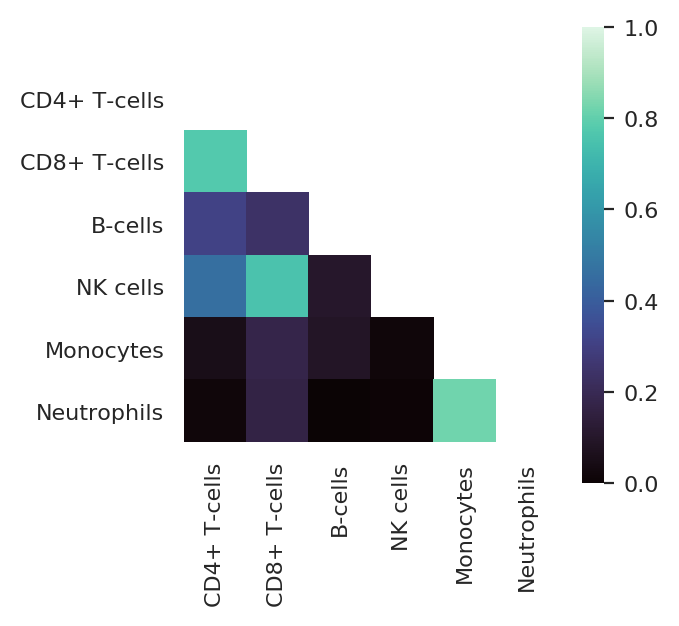

In [55]:
centroid_kappa = centroids_blood_hv.loc[list(mgSet_kappa),['CD4+ T-cells', 'CD8+ T-cells','B-cells', 'NK cells'
       ,'Monocytes', 'Neutrophils']]
corr = pd.DataFrame(data = np.corrcoef(centroid_kappa.T), columns = centroid_kappa.columns, index = centroid_kappa.columns)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot = sns.heatmap(corr, 
            xticklabels=corr.columns,mask=mask,cmap=sns.color_palette("mako", 1000),square=True)
sns_plot.figure.savefig(results_file+"corr_4k_ciber.png",dpi=300, bbox_inches='tight')

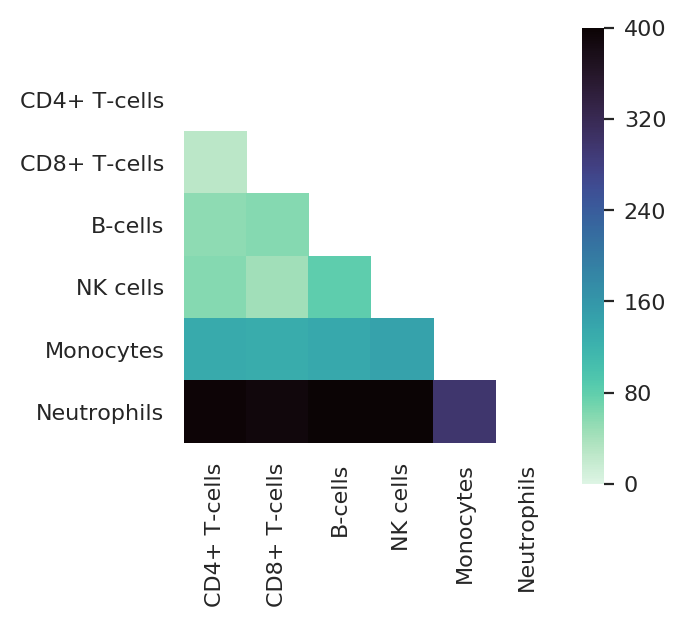

In [56]:
dist = pd.DataFrame(index = centroid_kappa.columns, columns= centroid_kappa.columns)
for cluster in centroid_kappa.columns:
    for c in centroid_kappa.columns:
        dist.loc[cluster,c] = sci.spatial.distance.euclidean(centroid_kappa.loc[:,c], centroid_kappa.loc[:,cluster])
dist = dist.astype(float)
mask = np.zeros_like(dist)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot = sns.heatmap(dist,
            xticklabels=dist.index,
            yticklabels=dist.index,mask=mask,cmap=sns.color_palette("mako_r", 1000),square=True)
sns_plot.figure.savefig(results_file+"dist_4k_ciber.png",dpi=300, bbox_inches='tight')

# Calling GA's output

In [103]:
import numpy as np
import deap
from deap import algorithms, base, tools, creator
import imp
#import cachetools 
from cachetools import LRUCache
import math
from scipy.spatial import distance
import random

# used to control the size of the cache so that it doesn't exceed system memory
MAX_MEM_BYTES = 11E9


class GeneticDetMinimizer(object):

    def __init__(self, N=30, popsize=500, cachesize=None, seed=0, centroid_sc = 0,ngen=1000, nfeatures = 100):

        # an 'individual' consists of an (N^2,) flat numpy array of 0s and 1s
        self.N = N
        self.indiv_size = N * 1
        self.centroid_sc = centroid_sc 
        self._ncrx = 0
        self.ngen = ngen
        self.nfeatures = nfeatures
        
        if cachesize is None:
            cachesize = int(np.ceil(8 * MAX_MEM_BYTES / self.indiv_size))
        random.seed(seed)
        self._gen = np.random.RandomState(seed)

        # we want the creator module to be local to this instance, since
        # creator.create() directly adds new classes to the module's globals()
        # (yuck!)
        cr = imp.load_module('cr', *imp.find_module('creator', deap.__path__))
        self._cr = cr

        self._cr.create("Fitness", base.Fitness, weights=(-1.0,1.0))
        self._cr.create("Individual", list, fitness=self._cr.Fitness)

        self._tb = base.Toolbox()
        self._tb.register("attr_bool", self.random_bool)
        self._tb.register("individual", self.individual, self._cr.Individual,
                          self._tb.attr_bool, self.indiv_size)

        # the 'population' consists of a list of such individuals
        self._tb.register("population", tools.initRepeat, list, self._tb.individual)
        self._tb.register("evaluate", self.fitness)
        self._tb.register("mate", self.crossover)
        self._tb.register("mutate", self.mutate)
        self._tb.register("select", tools.selNSGA2) # tools.selTournament, tournsize=3)

        # create an initial population, and initialize a hall-of-fame to store
        # the best individual
        self.pop = self._tb.population(n=popsize)
        self.hof = tools.ParetoFront()#HallOfFame(1, similar=np.array_equal)

        # print summary statistics for the population on each iteration
        self.stats = tools.Statistics(lambda ind: ind.fitness.values)
        self.stats.register("avg", np.mean, axis=0)
        self.stats.register("std", np.std, axis=0)
        self.stats.register("min", np.min, axis=0)
        self.stats.register("max", np.max, axis=0)

        # keep track of configurations that have already been visited
        self.tabu = LRUCache(cachesize)

    def individual(self, *args):
        indv = [0] * self.indiv_size
        for i in range(self.nfeatures):
            indx = random.randint(0, self.indiv_size-1)
            while indv[indx] == 1:
                indx = random.randint(0, self.indiv_size-1)
            indv[indx] = 1
        return args[0](indv)
    
    def random_bool(self, *args):
        return self._gen.rand(*args) < 0.2

    def fitness(self, individual):
        """
        assigns a fitness value to each individual, based on the determinant
        """
        array_individual = np.array(individual)
        h = np.packbits(array_individual.astype(np.uint8)).tostring()
        # look up the fitness for this configuration if it has already been
        # encountered
        if h not in self.tabu:
            interCorr = 0 
            intraCorr = 0
            distance_ = 0 
            centroid = pd.DataFrame()
            centroid = self.centroid_sc[array_individual!=0] 
            corr = pd.DataFrame(data = np.corrcoef(centroid.T), columns = centroid.columns, index = centroid.columns)
            if corr.isnull().values.any():
                interCorr = 10000
                intraCorr = centroid.columns.size
                distance_ = 0
            else:
                for x in centroid.columns:
                    #distance_ = distance_ + distance.euclidean(centroid[x],centroid.loc[:, centroid.columns != x].mean(axis=1)) 
                    for y in centroid.columns:
                        if (x!=y):
                           distance_ = distance_ + distance.euclidean(centroid[x],centroid[y]) 
                           #distance_ + distance.euclidean(centroid[x],centroid[y]) 
                           #distance_ + np.nansum(np.log2(centroid[x]/(centroid[y]+1) +1))
                           #print(np.log2(centroid[x]/(centroid[y]+1) +1))
                for x in corr.index:
                    for y in corr.columns:
                        if (x!=y):
                           interCorr = interCorr + abs(corr.loc[x,y])
                        else:
                          intraCorr = intraCorr + corr.loc[x,y]
            
            objs = []
            objs.append(interCorr)
            objs.append(distance_)
            #objs.append(intraCorr)
            self.tabu.update({h: objs})
        else:
            interCorr = self.tabu[h][0]
            distance_ = self.tabu[h][1]
            #intraCorr = self.tabu[h][2]
        return interCorr, distance_

    def crossover(self, ind1, ind2):
        """
        randomly swaps a block of rows or columns between two individuals
        """
        ors = ind1
        for x in range(0,len(ind1)):
            ors[x] = ind1[x] or ind2[x]
        indexes = [index for index in range(len(ors)) if ors[index] == 1]

        for i in indexes[:self.nfeatures]:
            ind1[i] = 1
        for i in range(len(ind1)):
            if i not in indexes[:self.nfeatures]:
                ind1[i]=0
        for i in indexes[-self.nfeatures:]:
            ind2[i] = 1
        for i in range(len(ind2)):
            if i not in indexes[-self.nfeatures:]:
                ind2[i] = 0
        #print(ind1)
        ind1_l = len([index for index in range(len(ind1)) if ind1[index] == 1])
        ind2_l = len([index for index in range(len(ind2)) if ind2[index] == 1])
        assert(ind1_l==self.nfeatures)
        assert(ind2_l==self.nfeatures)
        return ind1, ind2
    
    
    def mutate(self, ind, rate=1E-3):
        """
        mutate an individual by bit-flipping one or more randomly chosen
        elements
        """
        array_ind = np.array(ind)
        # ensure that each mutation always introduces a novel configuration
        while np.packbits(array_ind.astype(np.uint8)).tostring() in self.tabu:
            n_flip = self._gen.binomial(self.indiv_size, rate)
            n_flip = int(n_flip/2)*2 #make it even
            if not n_flip:
                continue
            
            idxs_1 = [index for index in range(len(ind)) if ind[index] == 1]
            idxs_0 = [index for index in range(len(ind)) if ind[index] == 0]
            
            flip_1_idxs = self._gen.random_integers(0, len(idxs_1) - 1, int(n_flip/2))
            while len(np.unique(flip_1_idxs)) < int(n_flip/2):
                flip_1_idxs = self._gen.random_integers(0, len(idxs_1) - 1, int(n_flip/2))
            
            flip_0_idxs = self._gen.random_integers(0, len(idxs_0) - 1, int(n_flip/2))
            while len(np.unique(flip_0_idxs)) < int(n_flip/2):
                flip_0_idxs = self._gen.random_integers(0, len(idxs_1) - 1, int(n_flip/2))
            
            assert(len(flip_1_idxs)==len(flip_0_idxs))
            
            for idx in flip_1_idxs:
                ind[idxs_1[idx]] = 0
            for idx in flip_0_idxs:
                ind[idxs_0[idx]] = 1
            assert(len([index for index in range(len(ind)) if ind[index] == 1])==self.nfeatures)
            array_ind = np.array(ind)
        return ind,
    
    

    def run(self, ngen=int(1E3), mutation_rate=0.3, crossover_rate=0.7, nLAMBDA = 100, nMU = 50):

        pop, log = algorithms.eaMuPlusLambda(self.pop, self._tb,
                                       mu = nMU, 
                                       lambda_ = nLAMBDA,
                                       cxpb=crossover_rate,
                                       mutpb=mutation_rate,
                                       ngen=ngen,
                                       stats=self.stats,
                                       halloffame=self.hof)
        self.log = log

        return self.hof, self.log, self.stats#self.hof[0].reshape(self.N, 1), log



In [174]:
if __name__ == "__main__":
    np.random.seed(0)
    popS  = 100
    ngen=3000 #int(2000)
    gd = GeneticDetMinimizer(N=centroids_blood_hv.index.size, popsize=popS, cachesize=None, 
                             seed=0, centroid_sc=centroids_blood_hv, ngen = ngen, nfeatures = 300)
    hof, log, stats = gd.run(ngen=ngen, mutation_rate=0.3, crossover_rate=0.7, nLAMBDA = popS, nMU = 100)

/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg                          	std                          	min                          	max                          
0  	100   	[  21.53004784 2813.05844842]	[   3.36291304 1445.819423  ]	[  15.05638574 1201.65304279]	[  29.94847926 8575.03097534]


/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/ipykernel_launcher.py:169: DeprecationWarning: This function is deprecated. Please call randint(0, 299 + 1) instead
/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/ipykernel_launcher.py:173: DeprecationWarning: This function is deprecated. Please call randint(0, 3699 + 1) instead


1  	100   	[  20.51503017 3352.47059603]	[   4.17324575 1633.50517205]	[ 12.26630968 840.02918911]  	[  29.95421734 8575.03097534]
2  	100   	[  19.16002363 3650.20725784]	[   4.72290428 1847.93360693]	[ 11.53255628 847.00244522]  	[  29.94847926 8575.03097534]
3  	100   	[  18.5135114  3841.60507229]	[   5.26039822 1903.22754258]	[ 11.53255628 854.28633881]  	[  29.76605393 8575.03097534]
4  	100   	[  17.65694488 3858.83902572]	[   5.32787754 1803.86136658]	[ 10.40470764 885.81624222]  	[  29.74978453 8575.03097534]
5  	100   	[  17.15522333 4047.15931777]	[   5.70428424 1798.36719762]	[  8.8067713  723.72321701]  	[  29.73267249 8575.03097534]
6  	100   	[  16.73353451 4221.7343386 ]	[   6.38185619 1964.46148825]	[  8.79274249 723.72321701]  	[  29.72242346 8575.03097534]
7  	100   	[  15.18987765 3912.09769519]	[   5.69919436 1998.03612635]	[  8.70629596 672.19958878]  	[  29.54502178 8575.03097534]


/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/ipykernel_launcher.py:171: DeprecationWarning: This function is deprecated. Please call randint(0, 299 + 1) instead


8  	100   	[  14.69196205 3822.29939807]	[   5.30564238 1934.29817773]	[  8.70629596 672.19958878]  	[  29.53812559 8575.03097534]
9  	100   	[  14.03991566 3464.51401353]	[   5.35878784 2109.85762296]	[  8.66860156 672.13763618]  	[  29.36984799 8575.03744507]
10 	100   	[  13.41305921 3152.47302109]	[   5.21454361 2142.24454313]	[  8.66034639 672.09457207]  	[  29.36935704 8575.03744507]
11 	100   	[  13.89585266 3449.54974598]	[   4.99185557 2010.58252796]	[  8.63128015 681.90165138]  	[  29.36935704 8575.03744507]
12 	100   	[  13.7613479  3488.11278396]	[   4.76294885 1923.8518496 ]	[   8.63128015 1036.52651978]	[  29.36931883 8575.03744507]
13 	100   	[  13.61047982 3377.05431821]	[   4.8730242  1990.70968544]	[   8.62511541 1034.75404453]	[  29.36931883 8575.03744507]
14 	100   	[  13.64210123 3408.87587422]	[   4.61056596 1910.7562451 ]	[   8.62511541 1036.70635033]	[  29.36927118 8575.03744507]
15 	100   	[  13.12548002 3195.81157485]	[   4.2673135  1839.78990062]	[   8.577377

71 	100   	[  13.0219645  4303.53715769]	[   4.80584482 1461.2345465 ]	[   6.56955734 1139.57505035]	[  29.53808521 8704.49050903]
72 	100   	[  13.01379723 4258.1589776 ]	[   4.93635148 1532.33886875]	[   6.56955734 1139.57505035]	[  29.53808521 8704.49050903]
73 	100   	[  12.42925256 4056.42523251]	[   4.78829444 1571.0052688 ]	[   6.56955734 1139.59776878]	[  29.24436878 8704.49050903]
74 	100   	[  12.29672947 4105.04695133]	[   4.88394084 1562.64437379]	[   6.56955734 1139.59776878]	[  29.2442523  8705.03059387]
75 	100   	[  12.25004819 4036.4261212 ]	[   4.98220679 1635.43035196]	[   6.56955734 1139.59776878]	[  29.24424821 8708.87772369]
76 	100   	[  11.99871034 3952.36268023]	[   4.98245094 1710.51975692]	[   6.56955734 1139.595541  ]	[  29.24424821 8708.87772369]
77 	100   	[  12.01683266 4002.43986835]	[   4.89187064 1669.66586188]	[   6.56955734 1139.595541  ]	[  29.244137   8708.87772369]
78 	100   	[  11.96531291 4084.28260605]	[   4.76192994 1630.35871644]	[   6.569557

/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/ipykernel_launcher.py:175: DeprecationWarning: This function is deprecated. Please call randint(0, 299 + 1) instead


118	100   	[  12.53853884 4504.75218798]	[   4.94574211 1762.98742534]	[  6.1831731  900.45921898]  	[  29.15010849 8948.65357971]
119	100   	[  12.77492617 4625.08675566]	[   4.8051538  1676.30409513]	[  6.00720424 900.45921898]  	[  29.15010849 8948.65357971]
120	100   	[  12.80296557 4657.72947144]	[   4.78152814 1641.34323155]	[  6.00720424 900.45921898]  	[  29.15010849 8948.65357971]
121	100   	[  12.89994096 4689.00235134]	[   5.05594507 1692.07654398]	[  6.00720424 900.45921898]  	[  29.15010849 8948.65357971]
122	100   	[  12.78438069 4625.33214293]	[   5.06523924 1758.90961282]	[  6.00720424 903.95300674]  	[  29.15010849 8948.65357971]
123	100   	[  12.60157476 4577.89267925]	[   4.85470393 1714.73952605]	[  6.00720424 903.99941635]  	[  29.15010592 8948.74372864]
124	100   	[  12.7015117  4615.93198256]	[   4.81842089 1681.62357219]	[  6.00720424 903.99941635]  	[  29.15008638 8948.76776886]
125	100   	[  12.8433691  4692.84926722]	[   4.76087125 1604.6606858 ]	[  6.0072042

181	100   	[  11.40203396 4939.22801241]	[   5.59619602 1648.27860766]	[   5.65607356 1274.09235764]	[  29.07248517 9310.97885132]
182	100   	[  11.58425131 5124.26828278]	[   5.52237612 1438.20550571]	[   5.46005025 1274.35946274]	[  29.07248517 9310.97885132]
183	100   	[  11.76952334 5190.40496738]	[   6.0661031  1555.19005105]	[   5.46005025 1274.35946274]	[  29.06382899 9322.13960266]
184	100   	[  11.62449491 5165.81701342]	[   5.81906489 1506.11834874]	[   5.46005025 1274.35946274]	[  29.06382899 9322.13960266]
185	100   	[  11.21321817 5125.36446274]	[   5.8594417  1536.12789433]	[   5.46005025 1274.35946274]	[  29.06382899 9322.13960266]
186	100   	[  11.0686495  5086.29222052]	[   5.90229726 1560.17169219]	[   5.45039853 1274.35946274]	[  29.06183992 9322.13960266]
187	100   	[  11.16922129 5207.19290411]	[   5.84873342 1458.72547328]	[   5.43783835 1274.52667618]	[  29.06183731 9512.28555298]
188	100   	[  11.36053585 5298.70108694]	[   6.06237791 1424.4158524 ]	[   5.435676

244	100   	[  12.1611384 5586.2777121]  	[   4.93823426 1159.33545797]	[   4.68285348 3830.9115715 ]	[  28.89272053 9564.22784424]
245	100   	[  11.8255542  5527.91769428]	[   4.99351689 1170.56063223]	[   4.6583732 3830.9115715]  	[  28.89272053 9564.22784424]
246	100   	[  11.88857884 5535.27709663]	[   4.93130246 1150.70550397]	[   4.6583732  3831.13371277]	[  28.89270971 9564.22784424]
247	100   	[  11.88171672 5554.37249966]	[   4.89904848 1141.49413909]	[   4.44652323 3727.43334579]	[  28.89270949 9566.72605896]
248	100   	[  12.09429868 5630.62501446]	[   5.14107513 1182.39824492]	[   4.44652323 3727.43334579]	[  28.89270949 9566.73110962]
249	100   	[  11.89309441 5578.30769726]	[   5.18718378 1205.16408254]	[   4.44652323 3727.43334579]	[  28.89270949 9566.73110962]
250	100   	[  11.94235574 5602.62491814]	[   5.15346461 1187.48648735]	[   4.44652323 3648.18571854]	[  28.89270949 9566.73110962]
251	100   	[  12.06578543 5631.02725128]	[   5.12085261 1176.84132999]	[   4.446523

307	100   	[  11.78894008 5733.03453598]	[   5.68751152 1260.53405627]	[   4.38720098 3729.1098671 ]	[  28.88793108 9579.48553467]
308	100   	[  11.80927642 5737.5485025 ]	[   5.71428463 1264.47578832]	[   4.38720098 3729.1098671 ]	[  28.88793108 9579.48553467]
309	100   	[  12.26069989 5797.56198841]	[   5.68961412 1282.98948776]	[   4.38720098 3729.1098671 ]	[  28.88792533 9579.5163269 ]
310	100   	[  12.42788996 5835.28687637]	[   5.90384029 1339.8434902 ]	[   4.38720098 3729.1098671 ]	[  28.88792533 9579.5163269 ]
311	100   	[  12.42173514 5844.95586613]	[   5.88828606 1337.32213307]	[   4.36685929 3729.19819641]	[  28.88792533 9579.5163269 ]
312	100   	[  12.29195409 5838.74241261]	[   5.88631615 1330.85336948]	[   4.36685929 3729.19819641]	[  28.88792533 9579.5163269 ]
313	100   	[  12.32948646 5812.66652676]	[   6.27799504 1447.60326118]	[   4.36685929 3729.19819641]	[  28.88792533 9579.5163269 ]
314	100   	[  12.46929946 5861.90067093]	[   6.1830726  1409.10934111]	[   4.366859

370	100   	[  10.45845671 5488.22234703]	[   5.46679071 1267.47329946]	[   4.22970143 3730.01871109]	[  28.88759882 9580.81222534]
371	100   	[  10.79723941 5564.31513416]	[   5.45660986 1262.23637716]	[   4.22970143 3730.01871109]	[  28.88759882 9580.81222534]
372	100   	[  10.94422687 5592.83367142]	[   5.51474601 1280.89284483]	[   4.22970143 3730.01871109]	[  28.88759882 9580.81222534]
373	100   	[  10.8816147  5590.74300091]	[   5.44305971 1255.51587385]	[   4.22970143 3730.01871109]	[  28.88759882 9580.81222534]
374	100   	[  11.02905393 5626.29358383]	[   5.73598944 1315.0314894 ]	[   4.22970143 3730.01871109]	[  28.88759882 9580.81222534]
375	100   	[  11.19537115 5681.98526985]	[   5.65952229 1282.45457228]	[   4.2252442  3730.01871109]	[  28.88759882 9580.81222534]
376	100   	[  11.33016    5718.53131004]	[   5.94096151 1338.24544522]	[   4.2252442  3730.01871109]	[  28.88759882 9580.81222534]
377	100   	[  11.73421169 5821.19836796]	[   5.76641687 1269.24037552]	[   4.225244

433	100   	[  12.83585296 6180.44377876]	[   5.62089486 1114.95420559]	[   4.10330241 3665.07078171]	[  28.88393196 9594.72325134]
434	100   	[  13.07621427 6224.75888565]	[   5.82828879 1162.33699318]	[   4.10330241 3665.07078171]	[  28.88393196 9594.73812103]
435	100   	[  12.98633561 6201.56422607]	[   5.5895414 1110.5859195]  	[   4.10330241 3665.07078171]	[  28.88389736 9595.53756714]
436	100   	[  12.86569026 6181.93199932]	[   5.59211244 1106.34645894]	[   4.10330241 3665.07078171]	[  28.88389736 9595.53756714]
437	100   	[  12.81346985 6178.73922729]	[   5.59038082 1106.93500037]	[   4.10330241 3665.07078171]	[  28.88389736 9595.53756714]
438	100   	[  12.4641531  6102.16470181]	[   5.74559069 1159.71580393]	[   4.10330241 3665.07078171]	[  28.88389736 9595.53756714]
439	100   	[  12.39733343 6092.13277145]	[   5.6904322 1135.9878495]  	[   4.10330241 3665.07078171]	[  28.88389736 9595.53756714]
440	100   	[  12.17872532 6050.29652946]	[   5.47892774 1085.30841281]	[   4.103302

496	100   	[  11.94526941 5981.07053501]	[   5.40097349 1173.24982145]	[   3.92110713 3159.97054291]	[  28.82396563 9754.08366394]
497	100   	[  11.94490695 5981.03991344]	[   5.40093053 1173.24696813]	[   3.91932127 3160.06744766]	[  28.82396563 9754.08366394]
498	100   	[  11.99277754 5987.18389202]	[   5.41006023 1175.55646666]	[   3.91932127 3160.06744766]	[  28.82396563 9754.08366394]
499	100   	[  11.66239935 5882.06607262]	[   5.70972383 1282.15665056]	[   3.91932127 3160.06744766]	[  28.82396563 9754.59140015]
500	100   	[  11.09073988 5782.08308826]	[   5.21584545 1135.52600419]	[   3.91932127 3160.06744766]	[  28.82371362 9754.59140015]
501	100   	[  11.151043   5787.52513702]	[   5.19799777 1137.54821578]	[   3.91932127 3160.06744766]	[  28.82371362 9754.59140015]
502	100   	[  11.29332903 5796.65231041]	[   5.23826964 1180.5945815 ]	[   3.91932127 3160.06744766]	[  28.82371362 9754.59140015]
503	100   	[  11.63473065 5866.19733337]	[   5.47140125 1240.26427847]	[   3.919321

559	100   	[  11.181999   5739.88019348]	[   6.00549125 1417.45425872]	[   3.82977708 3087.51804352]	[  28.77962998 9878.66890717]
560	100   	[  10.95894108 5679.48155174]	[   5.8318879 1384.2792837]  	[   3.82977708 3087.51804352]	[  28.77958791 9935.30535889]
561	100   	[  11.02061208 5675.57057693]	[   5.8244979  1394.91876179]	[   3.81741254 3087.51804352]	[  28.77958791 9935.30535889]
562	100   	[  10.91331083 5674.53186192]	[   5.77775337 1367.26825492]	[   3.80749497 3087.51804352]	[  28.77958791 9935.30535889]
563	100   	[  10.70539869 5622.76074047]	[   5.57980616 1315.84230663]	[   3.80749497 3091.40185547]	[  28.76468537 9935.30535889]
564	100   	[  10.61778447 5609.43050259]	[   5.92984565 1434.38870282]	[   3.80445237 3091.40185547]	[  28.76486342 9935.30535889]
565	100   	[  10.11249012 5546.64384243]	[   5.96892674 1436.62164233]	[   3.80445237 3091.40185547]	[  28.76486342 9935.30535889]
566	100   	[   9.8607677  5472.72030693]	[   5.98041582 1466.34027007]	[   3.786498

662	100   	[  10.60800529 5756.44965965]	[   5.50273041 1335.76969042]	[   3.72318474 3097.06289673]	[   28.68554696 10023.09527588]
663	100   	[  10.72903288 5794.33097248]	[   5.46342717 1313.21363314]	[   3.72318474 3097.06289673]	[   28.68554696 10023.09527588]
664	100   	[  10.67288501 5759.30660255]	[   5.50002802 1337.56320805]	[   3.72318474 3097.06289673]	[   28.68554696 10023.09527588]
665	100   	[  10.62245946 5748.68639309]	[   5.52955098 1333.93857609]	[   3.69322534 3097.15016556]	[   28.68554696 10023.09527588]
666	100   	[  10.73653476 5782.22842354]	[   5.54463303 1335.37622674]	[   3.69322534 3097.15016556]	[   28.68554696 10023.09527588]
667	100   	[  10.69651957 5768.74310467]	[   5.55870183 1344.05524115]	[   3.69322534 3097.15016556]	[   28.68554696 10023.09527588]
668	100   	[  10.66941822 5773.25602135]	[   5.55572376 1347.36878025]	[   3.69322534 3097.15016556]	[   28.68554696 10023.09527588]
669	100   	[  10.75753226 5786.48253849]	[   5.54094107 1352.02868788

724	100   	[  10.29150793 5752.35814842]	[   5.39397647 1311.50495117]	[   3.61799561 3088.21796036]	[   28.67855583 10046.15345001]
725	100   	[  10.26265724 5772.29116295]	[   5.3562142  1283.34269404]	[   3.61791513 3087.1649437 ]	[   28.67855583 10046.15345001]
726	100   	[  10.42117119 5792.39709492]	[   5.38177023 1290.63888079]	[   3.61528926 3087.19464874]	[   28.67855583 10046.15345001]
727	100   	[  10.45863331 5800.83576962]	[   5.40366092 1290.91132243]	[   3.61528926 3087.19464874]	[   28.67855583 10046.15345001]
728	100   	[  10.36396947 5782.28028442]	[   5.41488247 1308.42885813]	[   3.61528926 3087.19464874]	[   28.67855583 10046.15345001]
729	100   	[  10.64876294 5855.52053814]	[   5.41052452 1265.96023809]	[   3.61528926 3087.19464874]	[   28.67855583 10046.15345001]
730	100   	[  10.83943949 5888.27273281]	[   5.42126126 1274.62645556]	[   3.61528926 3087.19464874]	[   28.67855583 10046.15345001]
731	100   	[  10.85552006 5894.02450001]	[   5.40873335 1273.66629259

786	100   	[  10.2085538  5890.15796356]	[   5.03679597 1190.57944232]	[   3.5192115  3100.09549332]	[   28.46914331 10787.93560791]
787	100   	[   9.91527131 5815.29674141]	[   5.12895151 1250.57098773]	[   3.5192115  3100.09549332]	[   28.46914331 10787.93560791]
788	100   	[   9.99594731 5850.86548344]	[   5.10365871 1223.9530653 ]	[   3.5192115  3100.09549332]	[   28.46914331 10787.93560791]
789	100   	[   9.93433576 5819.44642654]	[   5.14232214 1248.20129175]	[   3.51682009 3100.06498718]	[   28.46422768 10803.67123413]
790	100   	[   9.84549566 5807.47226357]	[   5.12344057 1252.16683766]	[   3.51682009 3100.06498718]	[   28.46422768 10803.67123413]
791	100   	[   9.93185787 5837.73816311]	[   5.09109859 1225.97028575]	[   3.51682009 3100.06498718]	[   28.46422768 10803.67123413]
792	100   	[  10.04522276 5870.72602077]	[   5.02663738 1211.07226484]	[   3.51682009 3100.06498718]	[   28.46422768 10803.67123413]
793	100   	[  10.04518104 5870.7296965 ]	[   5.02657621 1211.07441089

848	100   	[  10.2404768  5820.79831745]	[   5.85623271 1442.33835685]	[   3.48430946 3244.53791428]	[   28.44946622 10856.20202637]
849	100   	[  10.25336199 5834.17381409]	[   5.84384255 1431.42310389]	[   3.48430946 3244.53791428]	[   28.44946622 10856.20202637]
850	100   	[  10.35724479 5858.60515884]	[   5.82914323 1423.87918471]	[   3.48430946 3244.53791428]	[   28.44946622 10856.20202637]
851	100   	[  10.24839936 5843.49284786]	[   5.8238045  1423.74950532]	[   3.48430946 3244.53791428]	[   28.44946622 10856.20202637]
852	100   	[  10.35387787 5861.14732857]	[   5.82716869 1426.01607348]	[   3.48430946 3244.53791428]	[   28.44946622 10856.20202637]
853	100   	[  10.2783075 5855.5188839]  	[   5.82044307 1424.09518924]	[   3.48430946 3244.53791428]	[   28.44946622 10856.20202637]
854	100   	[  10.16866212 5830.94721027]	[   5.81807168 1428.47066345]	[   3.48430946 3244.53791428]	[   28.44946622 10856.20202637]
855	100   	[  10.26173734 5860.32596313]	[   5.7753938  1412.93834471

910	100   	[   8.44171901 5572.43660835]	[   5.05062214 1386.42140106]	[   3.4493342  3213.95542908]	[   28.44125336 10871.17338562]
911	100   	[   8.5563746  5546.05444332]	[   5.1424792  1414.53011954]	[   3.44700363 3213.17918777]	[   28.44125336 10871.17338562]
912	100   	[   8.7098906  5522.74565109]	[   5.25999611 1467.78746074]	[   3.44700363 3212.20217133]	[   28.44125336 10871.17338562]
913	100   	[   8.55332682 5504.21121792]	[   4.86721472 1334.45827168]	[   3.44700363 3213.17918777]	[   28.42558385 10924.83467102]
914	100   	[   8.67802269 5548.19934212]	[   4.8805175  1328.20009887]	[   3.44700363 3213.17918777]	[   28.42558385 10924.83467102]
915	100   	[   8.78342279 5606.30346409]	[   4.8116351  1293.85379561]	[   3.44700363 3213.17918777]	[   28.42558385 10924.83467102]
916	100   	[   8.71607192 5602.22365284]	[   4.75484303 1286.47131478]	[   3.44700363 3213.17918777]	[   28.42558385 10924.83467102]
917	100   	[   8.77730423 5607.98269249]	[   4.80301038 1290.21000319

972	100   	[   8.62606951 5546.72673347]	[   4.84001849 1327.90464838]	[   3.36180468 3130.79457092]	[   28.41869587 10943.78848267]
973	100   	[   8.57984439 5562.78997215]	[   4.81321846 1305.82153682]	[   3.36180468 3130.79457092]	[   28.41869587 10943.78848267]
974	100   	[   8.706281 5612.437757]    	[   4.79471603 1293.14748019]	[   3.36180468 3130.79457092]	[   28.41869587 10943.78848267]
975	100   	[   8.49750756 5553.53518475]	[   4.77901304 1315.70476066]	[   3.36180468 3130.79457092]	[   28.41869587 10943.78848267]
976	100   	[   8.37727267 5541.28058495]	[   4.72929334 1309.67586097]	[   3.36180468 3130.79457092]	[   28.41869587 10943.78848267]
977	100   	[   8.17197118 5459.21727886]	[   4.78547078 1338.71589927]	[   3.36180468 3130.79457092]	[   28.41869587 10943.78848267]
978	100   	[   8.24568275 5471.22559406]	[   4.80250514 1341.6054981 ]	[   3.36180468 3130.79457092]	[   28.41869587 10943.78848267]
979	100   	[   8.29733023 5475.60704609]	[   4.8117953  1343.75955524

1034	100   	[  10.36174919 5999.10711742]	[   5.40631101 1377.90026957]	[   3.35548586 3130.84771729]	[   28.41755265 10946.28681946]
1035	100   	[  10.38837883 6007.30621437]	[   5.44368821 1386.46780165]	[   3.35548586 3130.84771729]	[   28.41755265 10946.28681946]
1036	100   	[  10.37636069 6004.50748798]	[   5.35226323 1373.08288952]	[   3.35548586 3130.84771729]	[   28.41755265 10946.28681946]
1037	100   	[  10.38820733 6006.59401722]	[   5.36116894 1374.15097631]	[   3.35548586 3130.84771729]	[   28.41755265 10946.28681946]
1038	100   	[  10.23664628 5970.41436539]	[   5.39045551 1398.8385595 ]	[   3.35548586 3130.84771729]	[   28.41755265 10946.28681946]
1039	100   	[  10.23663347 5970.46108978]	[   5.39093739 1398.93202465]	[   3.35548586 3130.84771729]	[   28.41755265 10946.28681946]
1040	100   	[  10.23648196 5970.89448799]	[   5.39086523 1399.47870517]	[   3.35548586 3130.84771729]	[   28.41755265 10946.28681946]
1041	100   	[  10.26678917 5979.44152462]	[   5.41390845 1404.

1096	100   	[   9.80133541 5909.95492191]	[   5.02390122 1330.43615728]	[   3.32819829 3133.42466736]	[   28.4171604  10946.98779297]
1097	100   	[   9.78335144 5898.64330692]	[   5.04737476 1345.96894669]	[   3.32819829 3133.42466736]	[   28.4171604  10946.98779297]
1098	100   	[   9.81436401 5926.59645443]	[   5.01905815 1319.91474536]	[   3.32819829 3133.42466736]	[   28.4171604  10946.98779297]
1099	100   	[   9.84039061 5952.50469814]	[   4.99217363 1291.49617462]	[   3.32819829 3133.42466736]	[   28.4171604  10946.98779297]
1100	100   	[   9.98517208 5972.9165287 ]	[   5.06557414 1304.11897628]	[   3.32819829 3133.42466736]	[   28.41715201 10947.01039124]
1101	100   	[  10.23234776 6043.01980762]	[   5.34775422 1379.09480011]	[   3.32819829 3133.42466736]	[   28.41715637 10947.01422119]
1102	100   	[  10.10964608 6002.92246456]	[   5.3569977  1401.22006835]	[   3.32819829 3133.42466736]	[   28.41715637 10947.01422119]
1103	100   	[  10.19282739 6025.01102299]	[   5.32591122 1389.

1158	100   	[  10.30646445 6044.86097351]	[   5.0149292  1298.36302997]	[   3.31702563 3137.84640884]	[   28.41070726 10965.79949951]
1159	100   	[  10.30626207 6044.87186092]	[   5.01507768 1298.36203609]	[   3.31702563 3137.84640884]	[   28.41070726 10965.79949951]
1160	100   	[  10.30027616 6036.9226067 ]	[   5.01839775 1313.43909812]	[   3.31702563 3137.84640884]	[   28.41070726 10965.79949951]
1161	100   	[  10.30407375 6041.02769749]	[   5.05628442 1318.02087166]	[   3.31702563 3137.84640884]	[   28.41070726 10965.79949951]
1162	100   	[  10.2199087  6019.39085426]	[   5.08625474 1329.19884476]	[   3.31702563 3137.84640884]	[   28.41070726 10965.79949951]
1163	100   	[  10.19651072 6015.72363449]	[   5.07283942 1327.64040463]	[   3.31702563 3137.84640884]	[   28.41070726 10965.79949951]
1164	100   	[  10.12837896 6009.83433212]	[   5.0781943  1326.75301212]	[   3.31702563 3137.84640884]	[   28.41070726 10965.79949951]
1165	100   	[  10.18376697 6029.89147518]	[   5.04393003 1315.

1220	100   	[  10.41786077 6137.77176601]	[   5.05451806 1244.6405772 ]	[   3.29715703 3140.95949173]	[   28.40608493 10980.29321289]
1221	100   	[  10.29834315 6118.619422  ]	[   5.00165409 1232.80609954]	[   3.29715703 3140.95949173]	[   28.40608352 10980.29399109]
1222	100   	[  10.19841853 6069.07265579]	[   5.05183933 1292.26828806]	[   3.29715703 3140.95949173]	[   28.40608352 10980.29399109]
1223	100   	[  10.0942717  6059.27969639]	[   5.04538083 1275.80871885]	[   3.29715703 3140.95949173]	[   28.40608352 10980.29399109]
1224	100   	[  10.27039563 6098.78712772]	[   5.06104989 1266.94752911]	[   3.29715703 3140.95949173]	[   28.40608352 10980.29399109]
1225	100   	[  10.09549961 6038.30210068]	[   5.0996721  1308.34819936]	[   3.29715703 3140.95949173]	[   28.40608352 10980.29399109]
1226	100   	[  10.05945565 6034.9453001 ]	[   5.15073735 1309.95739499]	[   3.29715703 3140.95949173]	[   28.40608352 10980.29399109]
1227	100   	[   9.95975038 6018.27987278]	[   5.13326959 1301.

1282	100   	[  10.01703622 6008.50318645]	[   5.16707239 1345.50693763]	[   3.28561653 3127.0569725 ]	[   28.40505904 10983.19087219]
1283	100   	[  10.0167571  6008.61417984]	[   5.16735357 1345.36936093]	[   3.28561653 3127.0569725 ]	[   28.40505904 10983.19087219]
1284	100   	[  10.09963376 6019.44375969]	[   5.19078421 1351.19052296]	[   3.28561653 3127.0569725 ]	[   28.40505904 10983.19087219]
1285	100   	[  10.15663646 6024.33461792]	[   5.17477689 1351.54023523]	[   3.28561653 3127.0569725 ]	[   28.40504361 10983.22322083]
1286	100   	[  10.22082643 6042.04113384]	[   5.12133052 1333.05273432]	[   3.28561653 3127.0569725 ]	[   28.40504361 10983.22322083]
1287	100   	[  10.17735969 6033.80598656]	[   5.14623749 1334.35627665]	[   3.27897888 3128.45386887]	[   28.40504361 10983.22322083]
1288	100   	[  10.09562085 6053.13004704]	[   5.10562019 1301.60694939]	[   3.27897888 3128.45386887]	[   28.40504361 10983.22322083]
1289	100   	[  10.05970085 6029.55102192]	[   5.12435674 1310.

1344	100   	[  10.29621078 6098.11798874]	[   5.38154807 1396.93040672]	[   3.26908109 3127.643116  ]	[   28.40455895 10984.85093689]
1345	100   	[  10.32780614 6105.25945599]	[   5.40448147 1400.7348802 ]	[   3.26908109 3127.643116  ]	[   28.40455895 10984.85093689]
1346	100   	[  10.30466018 6097.9972945 ]	[   5.3852399  1396.24582664]	[   3.26908109 3127.643116  ]	[   28.40455895 10984.85093689]
1347	100   	[  10.30466208 6098.01644859]	[   5.38522078 1396.23743886]	[   3.26908109 3127.643116  ]	[   28.40455895 10984.85093689]
1348	100   	[  10.3325151  6106.89938198]	[   5.36453462 1394.2053131 ]	[   3.26908109 3127.643116  ]	[   28.40455895 10984.85093689]
1349	100   	[  10.25127548 6069.91381199]	[   5.42970311 1413.53562468]	[   3.26908109 3127.643116  ]	[   28.40455895 10984.85093689]
1350	100   	[  10.35804082 6099.04846504]	[   5.40208801 1398.2374489 ]	[   3.26908109 3127.643116  ]	[   28.40455895 10984.85093689]
1351	100   	[  10.60146861 6166.10812721]	[   5.65518308 1468.

1406	100   	[  10.50266149 6199.9287746 ]	[   5.32192114 1340.32684414]	[   3.21557534 3149.52236938]	[   28.40371798 10985.97381592]
1407	100   	[  10.61210764 6213.40076977]	[   5.32944151 1346.10613846]	[   3.21557534 3149.52236938]	[   28.40371798 10985.97381592]
1408	100   	[  10.5524008  6188.04817364]	[   5.34916914 1355.32343268]	[   3.21557534 3149.52236938]	[   28.40371798 10985.97381592]
1409	100   	[  10.67252455 6218.43880516]	[   5.33378825 1347.33104714]	[   3.21557534 3149.52236938]	[   28.40371798 10985.97381592]
1410	100   	[  10.65114422 6215.89298363]	[   5.33499127 1345.64359999]	[   3.21557534 3149.52236938]	[   28.40371798 10985.97381592]
1411	100   	[  10.35256445 6141.63663334]	[   5.03692338 1266.31074939]	[   3.21557534 3149.52236938]	[   28.40339413 10987.02851868]
1412	100   	[  10.35561089 6142.48808201]	[   5.04190317 1266.56042083]	[   3.21557534 3149.52236938]	[   28.40339413 10987.02851868]
1413	100   	[  10.32848282 6131.86107616]	[   5.02975118 1273.

1468	100   	[  10.05918846 6040.87774235]	[   4.96724699 1347.8764547 ]	[   3.0894403  1901.46466446]	[   28.40243544 10988.85157776]
1469	100   	[  10.05930798 6040.88584553]	[   4.96701702 1347.87241205]	[   3.0894403  1901.46466446]	[   28.40243544 10988.85157776]
1470	100   	[  10.07113735 6045.74089233]	[   4.97951899 1351.85510432]	[   3.0894403  1901.46466446]	[   28.40243544 10988.85157776]
1471	100   	[  10.06415314 6044.99812847]	[   4.98732728 1352.78013312]	[   3.0894403  1901.46466446]	[   28.40243544 10988.85157776]
1472	100   	[   9.94315981 6021.80758636]	[   4.92989451 1337.54761446]	[   3.0894403  1901.46466446]	[   28.40243544 10988.85157776]
1473	100   	[   9.94312809 6021.79826283]	[   4.9299226  1337.56398821]	[   3.0894403  1901.46466446]	[   28.40243544 10988.85157776]
1474	100   	[  10.05498846 6044.66158798]	[   4.94077266 1345.00083966]	[   3.0894403  1901.46466446]	[   28.40243544 10988.85157776]
1475	100   	[   9.89724815 5993.45044682]	[   4.96026771 1404.

1530	100   	[   9.67934165 5986.37958515]	[   4.93947947 1377.69581982]	[   3.05428279 1866.29166412]	[   28.40110349 10991.93206787]
1531	100   	[   9.58140867 5961.10405434]	[   4.9600384  1389.23596884]	[   3.04536997 1864.81274414]	[   28.40110349 10991.93206787]
1532	100   	[   9.7079343  5995.39437237]	[   4.94771878 1375.05976578]	[   3.04536997 1864.81274414]	[   28.40110349 10991.93206787]
1533	100   	[   9.59030183 5964.26872078]	[   4.95007104 1384.4486202 ]	[   3.04536997 1864.81274414]	[   28.40110349 10991.93206787]
1534	100   	[   9.58124435 5963.52529305]	[   4.95310323 1384.3345689 ]	[   3.04536997 1864.81274414]	[   28.40110349 10991.93206787]
1535	100   	[   9.58172481 5965.32007927]	[   4.95240084 1381.93931939]	[   3.04536997 1864.81274414]	[   28.40110349 10991.93206787]
1536	100   	[   9.58160163 5965.35670788]	[   4.95233345 1381.98547196]	[   3.04536997 1864.81274414]	[   28.40110349 10991.93206787]
1537	100   	[   9.58039424 5965.41648254]	[   4.95239305 1381.

1592	100   	[   9.6522454  5994.06017426]	[   4.98075387 1397.33127125]	[   3.00225688 1863.22271729]	[   28.40098365 10992.17286682]
1593	100   	[   9.71227377 6003.31550171]	[   5.01534438 1402.32184042]	[   3.00225688 1863.22271729]	[   28.40098365 10992.17286682]
1594	100   	[   9.72006672 6017.59587914]	[   4.97883983 1387.72341656]	[   3.00225688 1863.22271729]	[   28.40098365 10992.17286682]
1595	100   	[   9.75653913 6049.18346554]	[   4.99909258 1340.56797389]	[   3.00225688 1863.22271729]	[   28.40098365 10992.17286682]
1596	100   	[   9.63362543 5997.03029411]	[   5.01177248 1399.65560729]	[   3.00225688 1863.22271729]	[   28.40067461 10992.62893677]
1597	100   	[   9.67553748 5975.54357597]	[   5.0289346  1427.87286887]	[   3.00225688 1863.22271729]	[   28.40067461 10992.62893677]
1598	100   	[   9.67540201 5975.72808289]	[   5.02907679 1428.09901197]	[   3.00225688 1863.22271729]	[   28.40067461 10992.62893677]
1599	100   	[   9.43805734 5914.40830887]	[   5.02636298 1442.

1654	100   	[   9.67945205 5982.43940475]	[   5.1256368  1486.27893905]	[   2.9645183 1804.8801384]  	[   28.39550743 11012.23300171]
1655	100   	[   9.58194952 5958.29324509]	[   5.13988079 1494.64604533]	[   2.9645183 1804.8801384]  	[   28.39550743 11012.23300171]
1656	100   	[   9.58131194 5957.99710182]	[   5.14057978 1495.48028802]	[   2.9645183 1804.8801384]  	[   28.39550743 11012.23300171]
1657	100   	[   9.51122948 5950.53123951]	[   5.15399039 1494.59484547]	[   2.9645183 1804.8801384]  	[   28.39550743 11012.23300171]
1658	100   	[   9.54338539 5968.79933136]	[   5.12905553 1485.95636563]	[   2.9645183 1804.8801384]  	[   28.39550743 11012.23300171]
1659	100   	[   9.52206967 5952.60747517]	[   5.14851099 1495.06168966]	[   2.9645183 1804.8801384]  	[   28.39550743 11012.23300171]
1660	100   	[   9.52228691 5952.88460438]	[   5.14882951 1495.31164368]	[   2.9645183 1804.8801384]  	[   28.39550743 11012.23300171]
1661	100   	[   9.64165299 5960.4413306 ]	[   5.10614187 1491.

1716	100   	[   9.71459543 5992.37242794]	[   5.34612292 1591.23941079]	[   2.94714029 1805.33018112]	[   28.39405859 11015.23144531]
1717	100   	[   9.59628388 5962.03435719]	[   5.34517136 1595.65339641]	[   2.94714029 1805.33018112]	[   28.39405859 11015.23144531]
1718	100   	[   9.59376653 5961.88645947]	[   5.34332796 1595.60594941]	[   2.94714029 1805.33018112]	[   28.39405859 11015.23144531]
1719	100   	[   9.67688    6008.23559155]	[   5.31743144 1543.47200732]	[   2.94714029 1805.33018112]	[   28.39405859 11015.23144531]
1720	100   	[   9.71909679 5987.63377151]	[   5.35327735 1567.52938574]	[   2.94714029 1805.33018112]	[   28.39405859 11015.23144531]
1721	100   	[   9.8279671  6043.05761978]	[   5.31927012 1525.72249105]	[   2.94714029 1805.33018112]	[   28.39405859 11015.23144531]
1722	100   	[   9.93168316 6068.7521077 ]	[   5.30139392 1516.55007461]	[   2.94714029 1805.33018112]	[   28.39405859 11015.23144531]
1723	100   	[   9.84638084 6057.57851528]	[   5.26091593 1512.

1778	100   	[   9.41529148 6025.17782063]	[   4.93337175 1378.91998561]	[   2.90224992 1862.54263687]	[   28.3936273  11016.01026917]
1779	100   	[   9.39489784 5986.91119167]	[   4.95674632 1438.16879126]	[   2.90224992 1862.54263687]	[   28.3936273  11016.01026917]
1780	100   	[   9.40482903 6001.00771469]	[   4.94751338 1428.89153053]	[   2.90224992 1862.54263687]	[   28.3936273  11016.01026917]
1781	100   	[   9.52580149 6014.02075783]	[   4.96416621 1432.11904762]	[   2.90224992 1862.54263687]	[   28.3936273  11016.01026917]
1782	100   	[   9.53076774 6015.8190028 ]	[   4.99362747 1435.47748667]	[   2.90224992 1862.54263687]	[   28.3936273  11016.01026917]
1783	100   	[   9.51305719 6011.47473557]	[   4.97424795 1432.97788668]	[   2.90224992 1862.54263687]	[   28.3936273  11016.01026917]
1784	100   	[   9.43545235 6025.25664463]	[   4.96672447 1381.87750385]	[   2.90224992 1862.54263687]	[   28.3936273  11016.01026917]
1785	100   	[   9.47727326 6027.14263744]	[   4.95856506 1383.

1840	100   	[   9.49454967 6011.13079121]	[   4.93532209 1390.99148992]	[   2.87970524 1865.70036697]	[   28.38925277 11030.02069092]
1841	100   	[   9.5035162  6012.46751171]	[   4.93966984 1391.46753265]	[   2.87738777 1865.7105751 ]	[   28.38925277 11030.02069092]
1842	100   	[   9.52029126 6013.5225827 ]	[   4.94361198 1391.30537162]	[   2.87738777 1865.7105751 ]	[   28.38925277 11030.02069092]
1843	100   	[   9.39240927 5969.59818913]	[   4.9524627  1409.35616568]	[   2.87738777 1865.7105751 ]	[   28.38925277 11030.02069092]
1844	100   	[   9.39225061 5969.47229862]	[   4.95230161 1409.20719572]	[   2.87738777 1865.7105751 ]	[   28.38925277 11030.02069092]
1845	100   	[   9.29387578 5952.493354  ]	[   4.91219243 1397.42457018]	[   2.87738777 1865.7105751 ]	[   28.38925277 11030.02069092]
1846	100   	[   9.26256141 5949.84013504]	[   4.9216236  1396.95746162]	[   2.87738777 1865.7105751 ]	[   28.38925277 11030.02069092]
1847	100   	[   9.37872745 5957.80134541]	[   4.99908036 1453.

1902	100   	[   9.35125258 5951.20349789]	[   4.92293493 1419.91832569]	[   2.85168815 1846.86006165]	[   28.38925277 11030.02069092]
1903	100   	[   9.35117916 5951.23880066]	[   4.92246715 1419.89250266]	[   2.85168815 1846.86006165]	[   28.38925277 11030.02069092]
1904	100   	[   9.13835727 5893.26330837]	[   4.98218933 1451.8768697 ]	[   2.85168815 1846.86006165]	[   28.38925277 11030.02069092]
1905	100   	[   9.2384577  5918.74183537]	[   4.98565457 1447.68304851]	[   2.85168815 1846.86006165]	[   28.38925277 11030.02069092]
1906	100   	[   9.22193924 5916.97076973]	[   4.97111974 1446.75615286]	[   2.85168815 1846.86006165]	[   28.38925277 11030.02069092]
1907	100   	[   9.12816692 5886.65727848]	[   5.00378702 1458.65071135]	[   2.85168815 1846.86006165]	[   28.38925277 11030.02069092]
1908	100   	[   9.06765431 5881.09064167]	[   5.00481744 1457.32280383]	[   2.85063979 1847.08370972]	[   28.38925277 11030.02069092]
1909	100   	[   9.06799687 5881.12298847]	[   5.00431614 1457.

1964	100   	[   9.57830317 6068.5030582 ]	[   4.96877951 1379.35321867]	[   2.84252668 1846.94865799]	[   28.38840007 11032.08323669]
1965	100   	[   9.52795647 6052.00333942]	[   4.96796356 1383.44205738]	[   2.84252668 1846.94865799]	[   28.38840007 11032.08323669]
1966	100   	[   9.52890845 6066.1457526 ]	[   4.91833476 1368.14566013]	[   2.84252668 1846.94865799]	[   28.38838837 11032.08569336]
1967	100   	[   9.60485301 6073.29432972]	[   4.92786031 1370.29711831]	[   2.84252668 1846.94865799]	[   28.38838837 11032.08569336]
1968	100   	[   9.60456601 6073.2823756 ]	[   4.92788588 1370.29879125]	[   2.84252668 1846.94865799]	[   28.38838837 11032.08569336]
1969	100   	[   9.52218053 6050.49912445]	[   4.95498432 1381.75861476]	[   2.84014399 1847.00270081]	[   28.38838837 11032.08569336]
1970	100   	[   9.45543468 6015.0049778 ]	[   4.97997361 1409.83087512]	[   2.84014399 1847.00270081]	[   28.38838837 11032.08569336]
1971	100   	[   9.46120456 6016.65320263]	[   4.97503052 1409.

2026	100   	[   9.42522388 5953.2337281 ]	[   5.1345221  1548.92313441]	[   2.7703368  1796.35906601]	[   28.38819351 11032.24003601]
2027	100   	[   9.49611044 6006.87202759]	[   5.02908678 1476.11299882]	[   2.76369181 1796.4144783 ]	[   28.38819351 11032.24003601]
2028	100   	[   9.49597183 6006.76968964]	[   5.02923429 1476.22930952]	[   2.76369181 1796.4144783 ]	[   28.38819351 11032.24003601]
2029	100   	[   9.54132832 6026.67963223]	[   5.00133336 1466.95274107]	[   2.76369181 1796.4144783 ]	[   28.38819351 11032.24003601]
2030	100   	[   9.58125386 6029.47281322]	[   5.00524484 1467.641941  ]	[   2.76369181 1796.4144783 ]	[   28.38819351 11032.24003601]
2031	100   	[   9.60872977 6039.48991165]	[   5.03284051 1475.3509333 ]	[   2.76369181 1796.4144783 ]	[   28.38819351 11032.24003601]
2032	100   	[   9.72683903 6061.6828046 ]	[   5.09618378 1492.42199795]	[   2.76369181 1796.4144783 ]	[   28.38819351 11032.24003601]
2033	100   	[   9.46474527 5993.57178234]	[   5.04417641 1491.

2088	100   	[   9.57552332 6056.18389076]	[   5.08853415 1469.89885196]	[   2.75707259 1796.58650208]	[   28.388101   11032.45767212]
2089	100   	[   9.550158   6055.04638657]	[   5.09309399 1469.77371058]	[   2.75707259 1796.58650208]	[   28.388101   11032.45767212]
2090	100   	[   9.55838524 6078.59711269]	[   5.08268493 1419.3554355 ]	[   2.75707259 1796.58650208]	[   28.388101   11032.45767212]
2091	100   	[   9.48353583 6065.85280865]	[   5.0448244  1411.94340933]	[   2.75707259 1796.58650208]	[   28.388101   11032.45767212]
2092	100   	[   9.5669791  6079.45932743]	[   5.07847355 1419.28423806]	[   2.75707259 1796.58650208]	[   28.388101   11032.45767212]
2093	100   	[   9.61068194 6047.03934895]	[   5.10841225 1486.95482043]	[   2.75344687 1793.15146255]	[   28.36233125 11132.76734924]
2094	100   	[   9.5065022 6031.2773386]  	[   5.0913518  1481.19988179]	[   2.75344687 1793.15146255]	[   28.36233125 11132.76734924]
2095	100   	[   9.44838179 6021.81365284]	[   5.04330967 1473.

2150	100   	[   9.3369246  6004.13021309]	[   5.10335158 1492.47333308]	[   2.73761341 1794.04103088]	[   28.36221072 11133.05259705]
2151	100   	[   9.33678944 6004.13024147]	[   5.10336201 1492.47755861]	[   2.73761341 1794.04103088]	[   28.36219559 11133.0526123 ]
2152	100   	[   9.33478291 6004.0934515 ]	[   5.10349444 1492.47057048]	[   2.73761341 1794.04103088]	[   28.36219559 11133.0526123 ]
2153	100   	[   9.33473838 6004.08167377]	[   5.10352138 1492.47069196]	[   2.73761341 1794.04103088]	[   28.36219559 11133.0526123 ]
2154	100   	[   9.21166503 5963.35203442]	[   5.10141254 1508.14551887]	[   2.73761341 1794.04103088]	[   28.36219559 11133.0526123 ]
2155	100   	[   9.24187845 5970.36373959]	[   5.10517655 1508.17609138]	[   2.73761341 1794.04103088]	[   28.36219559 11133.0526123 ]
2156	100   	[   9.17039013 5950.02837318]	[   5.11417445 1516.73237993]	[   2.73761341 1794.04103088]	[   28.36219559 11133.0526123 ]
2157	100   	[   9.24563068 5971.87574059]	[   5.08869299 1507.

2212	100   	[   9.00720255 5888.57126747]	[   5.05703908 1554.23359053]	[   2.71990555 1793.30479813]	[   28.36219559 11133.0526123 ]
2213	100   	[   9.00436945 5888.80206413]	[   5.05571755 1554.68371611]	[   2.71990555 1793.30479813]	[   28.35867999 11145.11810303]
2214	100   	[   9.14486089 5923.41513184]	[   5.08977268 1562.39614401]	[   2.71990555 1793.30479813]	[   28.35867999 11145.11810303]
2215	100   	[   9.02428245 5888.16668365]	[   5.0717377  1560.34503955]	[   2.71990555 1793.30479813]	[   28.35867999 11145.11810303]
2216	100   	[   9.02299586 5887.91754471]	[   5.07082218 1560.23173723]	[   2.71990555 1793.30479813]	[   28.35867999 11145.11810303]
2217	100   	[   9.0267795  5889.42972446]	[   5.06680672 1558.58260576]	[   2.71990555 1793.30479813]	[   28.35867999 11145.11810303]
2218	100   	[   8.90959224 5857.72128643]	[   5.05216337 1560.10331412]	[   2.71990555 1793.30479813]	[   28.35867999 11145.11810303]
2219	100   	[   8.87891632 5842.36583328]	[   5.07139387 1564.

2274	100   	[   9.31770892 5987.83083214]	[   5.17814031 1512.20250066]	[   2.67927741 1834.79867935]	[   28.35818649 11146.07313538]
2275	100   	[   9.4231519  6014.70275871]	[   5.17116536 1505.3891984 ]	[   2.67927741 1834.79867935]	[   28.35818649 11146.07313538]
2276	100   	[   9.32314325 5986.97457966]	[   5.09363981 1502.62165276]	[   2.67927741 1834.79867935]	[   28.35818649 11146.07313538]
2277	100   	[   9.31433143 5963.57158432]	[   5.10390995 1547.46289032]	[   2.67927741 1834.79867935]	[   28.35700211 11147.67221069]
2278	100   	[   9.35870032 6007.1382637 ]	[   5.06703811 1492.47635083]	[   2.67927741 1834.79867935]	[   28.35700211 11147.67221069]
2279	100   	[   9.12947149 5955.77260689]	[   4.99019814 1477.95327834]	[   2.67927741 1834.79867935]	[   28.35695704 11147.77632141]
2280	100   	[   9.09370329 5927.25367386]	[   5.02052827 1502.15897889]	[   2.67927741 1834.79867935]	[   28.35695704 11147.77632141]
2281	100   	[   9.08742224 5918.4495541 ]	[   5.02735153 1514.

2336	100   	[   9.75141676 6035.83307522]	[   5.39540168 1640.54053652]	[   2.60213309 1802.61348724]	[   28.30405096 11233.21211243]
2337	100   	[   9.85437069 6053.69563446]	[   5.39010232 1641.74141765]	[   2.59704281 1802.63033676]	[   28.30405096 11233.21211243]
2338	100   	[   9.61826651 5991.95310638]	[   5.38650877 1642.08900613]	[   2.59704281 1802.63033676]	[   28.30404734 11233.21556091]
2339	100   	[   9.61833076 5991.99822609]	[   5.38641318 1642.04492199]	[   2.59704281 1802.63033676]	[   28.30404734 11233.21556091]
2340	100   	[   9.72935963 6021.03817574]	[   5.38185072 1637.23455437]	[   2.59704281 1802.63033676]	[   28.30404734 11233.21556091]
2341	100   	[   9.61319645 5989.45898701]	[   5.38592967 1641.89794729]	[   2.59704281 1802.63033676]	[   28.30404734 11233.21556091]
2342	100   	[   9.40534202 5940.89176537]	[   5.36777945 1639.82080353]	[   2.5658213  1802.01869583]	[   28.30404734 11233.21556091]
2343	100   	[   9.40538788 5940.97607254]	[   5.3677226  1639.

2398	100   	[   9.31652073 5897.7896106 ]	[   5.27273465 1697.07780087]	[   2.53479903 1801.30464554]	[   28.30221955 11238.57788086]
2399	100   	[   9.28483202 5896.01479073]	[   5.27869445 1696.70057552]	[   2.53479903 1801.30464554]	[   28.30221955 11238.57788086]
2400	100   	[   9.37602376 5922.20449402]	[   5.25363589 1687.35896865]	[   2.53479903 1801.30464554]	[   28.30221955 11238.57788086]
2401	100   	[   9.38428699 5928.81721359]	[   5.26365405 1693.97490552]	[   2.53479903 1801.30464554]	[   28.30221955 11238.57788086]
2402	100   	[   9.24919107 5879.34369106]	[   5.26373147 1701.25773714]	[   2.53479903 1801.30464554]	[   28.30221955 11238.57788086]
2403	100   	[   9.37989268 5904.0747541 ]	[   5.32264637 1718.46455536]	[   2.53479903 1801.30464554]	[   28.30221955 11238.57788086]
2404	100   	[   9.37943884 5901.51573421]	[   5.3225892  1715.92910828]	[   2.53479903 1801.30464554]	[   28.30221955 11238.57788086]
2405	100   	[   9.39573411 5919.00582478]	[   5.30684391 1704.

2460	100   	[   9.17435054 5866.46264244]	[   5.20425609 1678.14077482]	[   2.53056377 1800.78816223]	[   28.28988441 11281.44902039]
2461	100   	[   9.21061944 5895.03598625]	[   5.17464475 1658.95915514]	[   2.53056377 1800.78816223]	[   28.28988441 11281.44902039]
2462	100   	[   9.21021027 5895.15649853]	[   5.17496482 1658.87651432]	[   2.53056377 1800.78816223]	[   28.28988441 11281.44902039]
2463	100   	[   9.17159352 5889.22917347]	[   5.1557217  1656.20763322]	[   2.53056377 1800.78816223]	[   28.28988441 11281.44902039]
2464	100   	[   9.09040112 5863.70579044]	[   5.18306122 1666.73289403]	[   2.53056377 1800.78816223]	[   28.28988441 11281.44902039]
2465	100   	[   9.15926025 5873.66431183]	[   5.19215151 1670.68991694]	[   2.53056377 1800.78816223]	[   28.28988441 11281.44902039]
2466	100   	[   9.21022011 5902.08924419]	[   5.15767414 1658.25203456]	[   2.53056377 1800.78816223]	[   28.28988441 11281.44902039]
2467	100   	[   9.09759438 5873.30529995]	[   5.15489423 1661.

2522	100   	[   9.55878003 6013.04818264]	[   5.22651888 1626.13032328]	[   2.52278709 1800.50856018]	[   28.28497083 11291.91098022]
2523	100   	[   9.53443941 6011.37279408]	[   5.2247142  1626.03830687]	[   2.52278709 1800.50856018]	[   28.28497083 11291.91098022]
2524	100   	[   9.49425467 6006.14919479]	[   5.23473193 1625.74469783]	[   2.52278709 1800.50856018]	[   28.28497083 11291.91098022]
2525	100   	[   9.42047327 5975.91730087]	[   5.27130682 1646.0656082 ]	[   2.52278709 1800.50856018]	[   28.28494595 11291.95248413]
2526	100   	[   9.45359826 5964.48634556]	[   5.28221513 1655.8909657 ]	[   2.52278709 1800.50856018]	[   28.28494256 11291.95332336]
2527	100   	[   9.50501046 5971.89303745]	[   5.30571797 1659.07805188]	[   2.52278709 1800.50856018]	[   28.28494256 11291.95332336]
2528	100   	[   9.54264078 5983.27130119]	[   5.35333492 1670.09191803]	[   2.52278709 1800.50856018]	[   28.28494256 11291.95332336]
2529	100   	[   9.43202475 5958.66019119]	[   5.35057179 1668.

2584	100   	[   9.27410036 5941.63853642]	[   5.3374481  1680.43464083]	[   2.4895014  1777.38316345]	[   28.28483501 11292.07376099]
2585	100   	[   9.29714505 5944.63063965]	[   5.34706222 1681.40296679]	[   2.4895014  1777.38316345]	[   28.28483501 11292.07376099]
2586	100   	[   9.35363222 5961.86969421]	[   5.41098395 1697.18572051]	[   2.4895014  1777.38316345]	[   28.28483501 11292.07376099]
2587	100   	[   9.30824889 5956.46859215]	[   5.4287532  1696.96098011]	[   2.48841032 1775.61745071]	[   28.28483501 11292.07376099]
2588	100   	[   9.18191249 5898.89955181]	[   5.26978012 1703.17988177]	[   2.48841032 1775.61745071]	[   28.28483501 11292.07376099]
2589	100   	[   9.18304813 5898.88455048]	[   5.26985995 1703.27458542]	[   2.48841032 1775.61745071]	[   28.28483501 11292.07376099]
2590	100   	[   9.09855978 5889.50101212]	[   5.26710172 1701.10691144]	[   2.48841032 1775.61745071]	[   28.28483501 11292.07376099]
2591	100   	[   9.06412437 5870.77929176]	[   5.28605214 1711.

2646	100   	[   9.17207537 5891.6451646 ]	[   5.63214154 1807.67836184]	[   2.47048906 1775.56928253]	[   28.28274705 11300.5456543 ]
2647	100   	[   9.1506587  5883.97591396]	[   5.6451465  1808.01014668]	[   2.47048906 1775.56928253]	[   28.28274705 11300.5456543 ]
2648	100   	[   9.15068815 5884.38230377]	[   5.64504826 1807.90502565]	[   2.47048906 1775.56928253]	[   28.28274705 11300.5456543 ]
2649	100   	[   9.02689739 5859.15699318]	[   5.27724638 1714.67656527]	[   2.47048906 1775.56928253]	[   28.28176785 11302.36953735]
2650	100   	[   9.06245841 5871.03261391]	[   5.31933865 1709.6973012 ]	[   2.47048906 1775.56928253]	[   28.28176785 11302.36953735]
2651	100   	[   9.03036277 5859.39672169]	[   5.28692614 1699.74513272]	[   2.47048906 1775.56928253]	[   28.28176785 11302.36953735]
2652	100   	[   9.03009544 5859.38347961]	[   5.28714164 1699.76349503]	[   2.47048906 1775.56928253]	[   28.28176785 11302.36953735]
2653	100   	[   8.94605682 5833.18824509]	[   5.3108981  1709.

2708	100   	[   8.68790021 5808.28598995]	[   5.29572479 1683.6428834 ]	[   2.46073184 1775.44432831]	[   28.27796058 11311.43777466]
2709	100   	[   8.74999513 5813.5843866 ]	[   5.30818096 1685.49172546]	[   2.46073184 1775.44432831]	[   28.27796058 11311.43777466]
2710	100   	[   8.68422308 5802.06919212]	[   5.26488061 1678.00886704]	[   2.46073184 1775.44432831]	[   28.27796058 11311.43777466]
2711	100   	[   8.73470613 5808.56910957]	[   5.29186335 1680.62272692]	[   2.46073184 1775.44432831]	[   28.27796058 11311.43777466]
2712	100   	[   8.62323632 5758.1317421 ]	[   5.29817764 1721.75666965]	[   2.46073184 1775.44432831]	[   28.27713401 11314.67996216]
2713	100   	[   8.79071139 5807.55892521]	[   5.34575888 1725.18638921]	[   2.46073184 1775.44432831]	[   28.27713401 11314.67996216]
2714	100   	[   8.7032472  5788.71896568]	[   5.26471703 1708.36492572]	[   2.46073184 1775.44432831]	[   28.27713401 11314.67996216]
2715	100   	[   8.74865827 5797.7827602 ]	[   5.29890821 1713.

2770	100   	[   9.37711288 5974.01329037]	[   5.66972218 1745.01505571]	[   2.44343732 1775.28928375]	[   28.27652117 11315.36444092]
2771	100   	[   9.27523866 5956.84186485]	[   5.64597481 1736.68211073]	[   2.44343732 1775.28928375]	[   28.27652117 11315.36444092]
2772	100   	[   9.2206694 5914.0928175]  	[   5.68962745 1784.07175571]	[   2.44343732 1775.28928375]	[   28.27652117 11315.36444092]
2773	100   	[   9.22110812 5914.26651855]	[   5.6903493 1784.3530924]  	[   2.44343732 1775.28928375]	[   28.27652117 11315.36444092]
2774	100   	[   9.26827222 5928.88355469]	[   5.7445707  1797.68267206]	[   2.44343732 1775.28928375]	[   28.27652117 11315.36444092]
2775	100   	[   9.3535364  5943.02976406]	[   5.77703915 1805.95437226]	[   2.44343732 1775.28928375]	[   28.27652117 11315.36444092]
2776	100   	[   9.35264997 5942.25872799]	[   5.77621303 1805.23435624]	[   2.44343732 1775.28928375]	[   28.27652117 11315.36444092]
2777	100   	[   9.35273053 5942.29223026]	[   5.77612385 1805.

2832	100   	[   9.4426688 5930.8672974]  	[   5.45014343 1761.08558498]	[   2.42319314 1774.17270279]	[   28.27451173 11322.4055481 ]
2833	100   	[   9.45545469 5944.06420082]	[   5.42587424 1748.01172873]	[   2.42319314 1774.17270279]	[   28.27451173 11322.4055481 ]
2834	100   	[   9.47984096 5944.92809696]	[   5.42209787 1748.08370284]	[   2.42319314 1774.17270279]	[   28.27451173 11322.4055481 ]
2835	100   	[   9.56310061 5964.09608604]	[   5.45095001 1759.36893467]	[   2.42319314 1774.17270279]	[   28.27451173 11322.4055481 ]
2836	100   	[   9.563976   5964.00692871]	[   5.45120833 1759.28850891]	[   2.42319314 1774.17270279]	[   28.27451173 11322.4055481 ]
2837	100   	[   9.46645971 5946.95670715]	[   5.42609584 1750.49751645]	[   2.42319314 1774.17270279]	[   28.27451173 11322.4055481 ]
2838	100   	[   9.42495994 5924.94901531]	[   5.41499885 1757.36769528]	[   2.42319314 1774.17270279]	[   28.27451173 11322.4055481 ]
2839	100   	[   9.41520277 5919.57183273]	[   5.40340053 1752.

2894	100   	[   9.7509702  6094.08300129]	[   5.65835194 1724.02827221]	[   2.41672664 1774.14188004]	[   28.26960127 11331.82681274]
2895	100   	[   9.6756618  6085.64856873]	[   5.65610642 1722.31728826]	[   2.41672664 1774.14188004]	[   28.26960127 11331.82681274]
2896	100   	[   9.7475291  6093.42383873]	[   5.65605128 1723.71946501]	[   2.41672664 1774.14188004]	[   28.26960127 11331.82681274]
2897	100   	[   9.7336833  6091.63419212]	[   5.66598543 1724.33274949]	[   2.41672664 1774.14188004]	[   28.26960127 11331.82681274]
2898	100   	[   9.72928248 6091.5674736 ]	[   5.66701948 1724.30294738]	[   2.41672664 1774.14188004]	[   28.26960127 11331.82681274]
2899	100   	[   9.7391906  6093.47210182]	[   5.67475697 1725.22540712]	[   2.41672664 1774.14188004]	[   28.26960127 11331.82681274]
2900	100   	[   9.63194748 6043.64704742]	[   5.70145734 1773.71765336]	[   2.41672664 1774.14188004]	[   28.26960127 11331.82681274]
2901	100   	[   9.66996792 6072.4250423 ]	[   5.67304593 1732.

2956	100   	[   9.61587485 6098.49184032]	[   5.62420515 1707.90006957]	[   2.40402451 1773.94957352]	[   28.26958256 11331.85820007]
2957	100   	[   9.66019173 6116.39533325]	[   5.6530457  1720.64994766]	[   2.40402451 1773.94957352]	[   28.26958256 11331.85820007]
2958	100   	[   9.66017983 6116.39631096]	[   5.65303507 1720.65056616]	[   2.40402451 1773.94957352]	[   28.26958256 11331.85820007]
2959	100   	[   9.70030586 6154.41865482]	[   5.5990166  1657.88619101]	[   2.40402451 1773.94957352]	[   28.26958256 11331.85820007]
2960	100   	[   9.73563119 6158.08323215]	[   5.58642415 1657.92391699]	[   2.40402451 1773.94957352]	[   28.26958256 11331.85820007]
2961	100   	[   9.73561249 6158.08634556]	[   5.58640875 1657.92538747]	[   2.40402451 1773.94957352]	[   28.26958256 11331.85820007]
2962	100   	[   9.64389888 6142.00459709]	[   5.56245124 1650.63796867]	[   2.40159421 1774.14454651]	[   28.26958256 11331.85820007]
2963	100   	[   9.70075029 6147.98048004]	[   5.54346078 1651.

In [175]:
if __name__ == "__main__":
    np.random.seed(0)
    popS  = 100
    ngen=2000 #int(2000)
    gd = GeneticDetMinimizer(N=centroids_blood_hv.index.size, popsize=popS, cachesize=None, 
                             seed=0, centroid_sc=centroids_blood_hv.loc[:,['Monocytes','Neutrophils']], ngen = ngen, nfeatures = 50)
    hof_MN, log_MN, stats_MN = gd.run(ngen=ngen, mutation_rate=0.3, crossover_rate=0.7, nLAMBDA = popS, nMU = 100)

gen	nevals	avg                      	std                      	min                    	max                        
0  	100   	[ 1.071527   82.02812727]	[ 0.52680275 83.9379187 ]	[0.13435606 9.80992317]	[  1.99232631 384.79470825]


/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/ipykernel_launcher.py:169: DeprecationWarning: This function is deprecated. Please call randint(0, 49 + 1) instead
/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/ipykernel_launcher.py:173: DeprecationWarning: This function is deprecated. Please call randint(0, 3949 + 1) instead


1  	100   	[  0.97646613 119.28659641]	[  0.60298985 107.63252229]	[ 0.13435606 13.65100479]	[  1.99939059 384.79470825]
2  	100   	[  0.95576696 168.36467485]	[  0.70035814 128.53184712]	[ 0.07722976 16.20820618]	[  1.99860357 384.79470825]
3  	100   	[  1.0813422 214.9490962]  	[  0.78251805 130.31598607]	[ 0.07722976 16.20820618]	[  1.99233394 401.44985962]


/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/ipykernel_launcher.py:171: DeprecationWarning: This function is deprecated. Please call randint(0, 49 + 1) instead


4  	100   	[  1.21481702 253.89028038]	[  0.82573158 125.75479057]	[ 0.07722976 16.20820618]	[  1.98741178 401.44985962]
5  	100   	[  1.34755633 289.25116928]	[  0.78403207 107.48810972]	[ 0.0345245  16.04187965]	[  1.98743989 401.44985962]
6  	100   	[  1.34875781 294.67046402]	[  0.7679675 104.4971331]  	[ 0.0345245  16.04187965]	[  1.95752832 449.95800781]
7  	100   	[  1.19849162 286.94219017]	[  0.79143103 121.6968106 ]	[ 0.0345245  16.04187965]	[  1.9199898  474.71307373]
8  	100   	[  1.15988845 292.92937819]	[  0.760277   119.00318503]	[ 0.0345245  16.04187965]	[  1.9199898  474.71307373]
9  	100   	[  1.04630748 284.40483196]	[  0.74834917 131.12952312]	[ 0.0345245  16.04187965]	[  1.92001598 474.71307373]
10 	100   	[  0.84369729 265.73550369]	[  0.66077852 135.94883201]	[ 0.02838799 16.04187965]	[  1.91548751 474.71307373]
11 	100   	[  0.62516373 246.23052586]	[  0.51573049 138.35876071]	[ 0.02838799 15.77350998]	[  1.91437283 474.71307373]
12 	100   	[  0.53541373 242.451

69 	100   	[1.86901286e-01 1.88197325e+02]	[  0.35189504 171.39740157]	[1.59412357e-06 1.77144547e+01]	[  1.1539821  476.95428467]
70 	100   	[1.69011446e-01 1.74167896e+02]	[  0.3396548  167.81390426]	[1.59412357e-06 1.77144547e+01]	[  1.15391557 477.31890869]
71 	100   	[1.56164441e-01 1.67032376e+02]	[  0.3251876  166.17635837]	[1.59412357e-06 1.77144547e+01]	[  1.1539021  477.31890869]
72 	100   	[1.50601220e-01 1.61133222e+02]	[  0.32540518 162.01573481]	[1.59412357e-06 1.77144547e+01]	[  1.1539021  477.31890869]
73 	100   	[1.35025064e-01 1.67987778e+02]	[  0.29171646 157.98953549]	[1.59412357e-06 1.77144547e+01]	[  1.15384453 477.31890869]
74 	100   	[1.36068388e-01 1.74295094e+02]	[  0.29139835 156.1042565 ]	[1.59412357e-06 1.77144547e+01]	[  1.15384453 477.31890869]
75 	100   	[1.54516962e-01 1.77758342e+02]	[  0.33876546 157.47357569]	[1.59412357e-06 1.77144547e+01]	[  1.87448068 477.31890869]
76 	100   	[1.34982867e-01 1.71414661e+02]	[  0.29167096 155.82785401]	[1.59412357e

/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/ipykernel_launcher.py:175: DeprecationWarning: This function is deprecated. Please call randint(0, 49 + 1) instead


85 	100   	[1.27223460e-01 1.60381541e+02]	[  0.2935048  154.46366843]	[1.59412357e-06 1.77144547e+01]	[  1.15232802 477.33151245]
86 	100   	[1.36651495e-01 1.74019556e+02]	[  0.29345665 159.09156745]	[1.59412357e-06 1.77144547e+01]	[  1.15232802 477.61593628]
87 	100   	[1.12635878e-01 1.62977151e+02]	[  0.2564723  153.63977428]	[1.59412357e-06 1.77144547e+01]	[  1.15145984 477.61593628]
88 	100   	[1.24071053e-01 1.61966230e+02]	[  0.27712738 157.75268376]	[1.59412357e-06 1.77144547e+01]	[  1.15145984 477.61593628]
89 	100   	[1.20095429e-01 1.68547789e+02]	[  0.25768958 157.9623932 ]	[1.59412357e-06 1.77144547e+01]	[  1.15135225 477.61593628]
90 	100   	[1.52236873e-01 1.81152218e+02]	[  0.32538412 161.99966233]	[1.59412357e-06 1.77144547e+01]	[  1.8553306  477.61593628]
91 	100   	[1.37500598e-01 1.84446944e+02]	[  0.27740353 161.41793881]	[1.59412357e-06 1.77144547e+01]	[  1.15142089 477.61593628]
92 	100   	[1.50809262e-01 1.90165999e+02]	[  0.29526574 162.86321612]	[1.59412357e

147	100   	[1.81520149e-01 3.26193320e+02]	[  0.19105808 138.43367542]	[1.59412357e-06 1.78643856e+01]	[  0.82146636 606.91308594]    
148	100   	[1.89838047e-01 3.29491224e+02]	[  0.20718062 140.58904462]	[1.59412357e-06 1.78643856e+01]	[  0.82146636 606.91308594]    
149	100   	[2.00488387e-01 3.33800822e+02]	[  0.22267687 143.95711762]	[1.59412357e-06 1.78643856e+01]	[  0.82208693 606.91308594]    
150	100   	[2.02876659e-01 3.31353707e+02]	[  0.23734312 146.33284926]	[1.59412357e-06 1.78643856e+01]	[  0.82335396 606.91308594]    
151	100   	[1.96335165e-01 3.28639102e+02]	[  0.23698359 145.5531956 ]	[1.59412357e-06 1.78643856e+01]	[  0.82208693 606.91308594]    
152	100   	[1.84105515e-01 3.25186001e+02]	[  0.2276927 139.379171 ]  	[1.59412357e-06 1.78643856e+01]	[  0.8217178  606.91308594]    
153	100   	[2.03818137e-01 3.35133076e+02]	[  0.24461856 144.00075431]	[1.59412357e-06 1.78643856e+01]	[  0.8217178  606.91308594]    
154	100   	[1.93616966e-01 3.29876131e+02]	[  0.2383007

208	100   	[3.65962517e-01 4.27825215e+02]	[  0.28812461 138.71387211]	[1.59412357e-06 1.78643856e+01]	[  0.80819495 608.38067627]    
209	100   	[3.68530274e-01 4.28037385e+02]	[  0.29018709 138.34191078]	[1.59412357e-06 1.78643856e+01]	[  0.80819495 608.38067627]    
210	100   	[3.75625032e-01 4.28210543e+02]	[  0.29753117 140.66811969]	[1.59412357e-06 1.78643856e+01]	[  0.80819495 608.38067627]    
211	100   	[3.83450262e-01 4.31212076e+02]	[  0.29743596 139.68983047]	[1.59412357e-06 1.78643856e+01]	[  0.80805333 608.38067627]    
212	100   	[3.63306719e-01 4.22493308e+02]	[  0.29861229 141.27665415]	[1.59412357e-06 1.78643856e+01]	[  0.80800983 608.38165283]    
213	100   	[3.77746751e-01 4.31931676e+02]	[  0.2901814  137.18813302]	[1.59412357e-06 1.78643856e+01]	[  0.80800983 608.38165283]    
214	100   	[3.76186505e-01 4.30016326e+02]	[  0.29801685 141.04599677]	[1.59412357e-06 1.78643856e+01]	[  0.80800983 608.48388672]    
215	100   	[3.67357316e-01 4.25248249e+02]	[  0.2994762

269	100   	[3.01569738e-01 4.12555637e+02]	[  0.2969643  134.41852931]	[1.59412357e-06 1.78643856e+01]	[  0.78676419 612.86224365]    
270	100   	[2.78833499e-01 4.02405219e+02]	[  0.28512126 130.42519471]	[1.59412357e-06 1.78643856e+01]	[  0.78648046 612.86224365]    
271	100   	[2.67652292e-01 3.96629273e+02]	[  0.28283605 129.90361765]	[1.59412357e-06 1.78643856e+01]	[  0.78648046 612.86224365]    
272	100   	[2.70849324e-01 3.98543722e+02]	[  0.2812209  129.60506511]	[1.59412357e-06 1.78643856e+01]	[  0.78648046 612.86224365]    
273	100   	[2.61110448e-01 3.94312007e+02]	[  0.27830349 128.2314265 ]	[1.59412357e-06 1.78643856e+01]	[  0.78612301 612.99078369]    
274	100   	[2.49904228e-01 3.89422802e+02]	[  0.27607966 127.51924312]	[1.59412357e-06 1.78643856e+01]	[  0.78612301 612.99078369]    
275	100   	[2.54442952e-01 3.90432743e+02]	[  0.28001982 128.3332799 ]	[1.59412357e-06 1.78643856e+01]	[  0.78612301 612.99078369]    
276	100   	[2.72189283e-01 3.97886569e+02]	[  0.2829068

330	100   	[2.12624822e-01 3.80503101e+02]	[  0.270999   132.12835382]	[1.47311388e-06 1.78643856e+01]	[  0.78409684 621.61077881]    
331	100   	[2.14599273e-01 3.88067609e+02]	[  0.26942844 123.80775802]	[4.71873317e-07 1.78643856e+01]	[  0.78353207 621.61077881]    
332	100   	[2.12439099e-01 3.87004218e+02]	[  0.27542774 125.8287833 ]	[4.71873317e-07 1.78643856e+01]	[  0.78353207 621.61077881]    
333	100   	[2.19759132e-01 3.89706570e+02]	[  0.27908181 126.23765652]	[4.71873317e-07 1.78643856e+01]	[  0.78353207 621.61077881]    
334	100   	[2.27863776e-01 3.93143048e+02]	[  0.28204242 127.18618019]	[4.71873317e-07 1.78643856e+01]	[  0.78353207 621.61077881]    
335	100   	[2.37403192e-01 3.96563225e+02]	[  0.28644077 127.36158638]	[4.71873317e-07 1.78643856e+01]	[  0.78353207 621.61077881]    
336	100   	[2.43726638e-01 3.98916800e+02]	[  0.29464692 129.56930714]	[4.71873317e-07 1.78643856e+01]	[  0.78353207 621.61077881]    
337	100   	[2.38644644e-01 3.97215684e+02]	[  0.2890564

391	100   	[2.15479560e-01 4.03063126e+02]	[  0.27775714 124.62607194]	[4.71873317e-07 2.83514618e+02]	[  0.76550756 624.01257324]    
392	100   	[2.21638617e-01 4.04943128e+02]	[  0.28146108 125.49310648]	[4.71873317e-07 2.83514618e+02]	[  0.76550756 624.01257324]    
393	100   	[1.83209376e-01 3.86072381e+02]	[  0.26929649 120.94807661]	[4.71873317e-07 2.83514618e+02]	[  0.76550516 624.01599121]    
394	100   	[1.74331620e-01 3.80766833e+02]	[  0.26557791 121.43276601]	[4.71873317e-07 2.83514618e+02]	[  0.76550516 624.01599121]    
395	100   	[1.77060520e-01 3.83452102e+02]	[  0.25966341 119.71008692]	[4.71873317e-07 2.83514618e+02]	[  0.76510095 624.01599121]    
396	100   	[2.01998329e-01 3.94844883e+02]	[  0.27408843 123.80597028]	[4.71873317e-07 2.83514618e+02]	[  0.76510095 624.01599121]    
397	100   	[2.08661532e-01 3.99742795e+02]	[  0.27317301 123.2456841 ]	[4.71873317e-07 2.83514618e+02]	[  0.76510095 624.01599121]    
398	100   	[2.08894152e-01 4.00612432e+02]	[  0.2729501

452	100   	[1.70667627e-01 4.00755144e+02]	[  0.22324759 108.64942808]	[4.71873317e-07 2.83514618e+02]	[  0.7452689  632.13928223]    
453	100   	[1.51025691e-01 3.90660345e+02]	[  0.21281453 107.2234009 ]	[4.71873317e-07 2.83514618e+02]	[  0.7452689  632.13928223]    
454	100   	[1.58279531e-01 3.94038806e+02]	[  0.21991943 109.37995193]	[4.71873317e-07 2.83514618e+02]	[  0.7452689  632.13928223]    
455	100   	[1.69841233e-01 3.98440114e+02]	[  0.23087749 113.50405831]	[4.71873317e-07 2.83514618e+02]	[  0.74557205 632.13928223]    
456	100   	[2.11433145e-01 4.23728135e+02]	[  0.23587318 113.97783311]	[4.71873317e-07 2.83514618e+02]	[  0.7452689  632.13928223]    
457	100   	[2.28952581e-01 4.30522589e+02]	[  0.24876365 117.16205437]	[4.71873317e-07 2.83514618e+02]	[  0.7452689  632.13928223]    
458	100   	[2.45787347e-01 4.40546474e+02]	[  0.25215229 117.32642639]	[4.71873317e-07 2.83514618e+02]	[  0.7452689  632.13928223]    
459	100   	[2.58824732e-01 4.46964642e+02]	[  0.2571230

513	100   	[2.42355040e-01 4.48695603e+02]	[  0.27177916 122.64347884]	[4.71873317e-07 2.83514618e+02]	[  0.72179939 640.01837158]    
514	100   	[2.35355159e-01 4.44361124e+02]	[  0.26940633 122.95308689]	[4.71873317e-07 2.83514618e+02]	[  0.72179939 640.01837158]    
515	100   	[2.21980325e-01 4.38524836e+02]	[  0.26432439 121.51289306]	[4.71873317e-07 2.83514618e+02]	[  0.72175711 641.21533203]    
516	100   	[2.32672302e-01 4.42823649e+02]	[  0.26998015 122.27268735]	[4.71873317e-07 2.83514618e+02]	[  0.72148432 641.65936279]    
517	100   	[2.12465921e-01 4.33518052e+02]	[  0.26414327 122.02724431]	[4.71873317e-07 2.64080292e+02]	[  0.72148432 641.65936279]    
518	100   	[2.29221454e-01 4.41922695e+02]	[  0.26705954 122.00881302]	[4.71873317e-07 2.64080292e+02]	[  0.71972014 641.65936279]    
519	100   	[2.32621200e-01 4.44219862e+02]	[  0.26817935 122.21369413]	[4.71873317e-07 2.64080292e+02]	[  0.71972014 641.65936279]    
520	100   	[2.30964669e-01 4.44439858e+02]	[  0.2617836

574	100   	[2.72295555e-01 4.87559905e+02]	[  0.25281299 109.68154635]	[4.71873317e-07 2.63981689e+02]	[  0.72708449 646.97113037]    
575	100   	[2.79714269e-01 4.93126340e+02]	[  0.25050064 105.43234262]	[4.71873317e-07 2.63981689e+02]	[  0.72708449 646.97113037]    
576	100   	[2.91795272e-01 4.97771333e+02]	[  0.25440887 103.95004129]	[4.71873317e-07 2.63981689e+02]	[  0.72708449 646.97113037]    
577	100   	[3.03440386e-01 5.00381752e+02]	[  0.25578647 104.31063246]	[4.71873317e-07 2.63981689e+02]	[  0.72708449 646.97113037]    
578	100   	[3.13007126e-01 5.04045948e+02]	[  0.25843281 103.96975953]	[4.71873317e-07 2.63981689e+02]	[  0.72708449 646.97113037]    
579	100   	[3.23009624e-01 5.07739359e+02]	[  0.26343302 104.21926313]	[4.71873317e-07 2.63981689e+02]	[  0.84568473 667.83856201]    
580	100   	[3.23612182e-01 5.07194011e+02]	[  0.26612254 106.30294683]	[4.71873317e-07 2.63981689e+02]	[  0.84568473 667.83856201]    
581	100   	[3.23290188e-01 5.07809504e+02]	[  0.2691719

635	100   	[2.72264237e-01 5.03810786e+02]	[  0.31243945 111.62708514]	[4.71873317e-07 2.64080292e+02]	[  1.07203248 734.47241211]    
636	100   	[2.67364450e-01 4.99852187e+02]	[  0.32119141 115.16156181]	[4.71873317e-07 2.64080292e+02]	[  1.07203248 734.47241211]    
637	100   	[2.62391685e-01 4.98236213e+02]	[  0.32317415 115.39824754]	[4.71873317e-07 2.64080292e+02]	[  1.07126641 734.47241211]    
638	100   	[2.53160098e-01 4.92237223e+02]	[  0.32171414 117.82737409]	[4.71873317e-07 2.64080292e+02]	[  1.07126641 734.47241211]    
639	100   	[2.25260015e-01 4.87861497e+02]	[  0.29542011 108.37573017]	[4.71873317e-07 2.83514618e+02]	[  1.0709742  734.47241211]    
640	100   	[2.34084906e-01 4.94237555e+02]	[  0.29705932 105.75615509]	[4.71873317e-07 2.83514618e+02]	[  1.0709742  734.47241211]    
641	100   	[2.44921548e-01 4.97110511e+02]	[  0.3072608  107.99228574]	[4.71873317e-07 2.83514618e+02]	[  1.0709742  734.47241211]    
642	100   	[2.23077306e-01 4.91216296e+02]	[  0.2919199

696	100   	[3.52946056e-01 5.36278913e+02]	[  0.31177778 104.73058225]	[4.71873317e-07 2.83514618e+02]	[  1.06213059 736.13275146]    
697	100   	[3.45964315e-01 5.33530534e+02]	[  0.31214006 106.61316581]	[4.71873317e-07 2.83514618e+02]	[  1.06213059 736.13275146]    
698	100   	[3.40301369e-01 5.31989988e+02]	[  0.31291987 108.33578429]	[4.71873317e-07 2.83514618e+02]	[  1.06213059 736.13275146]    
699	100   	[3.40301369e-01 5.31989988e+02]	[  0.31291987 108.33578429]	[4.71873317e-07 2.83514618e+02]	[  1.06213059 736.13275146]    
700	100   	[3.47061021e-01 5.34197381e+02]	[  0.31686436 109.54230866]	[4.71873317e-07 2.83514618e+02]	[  1.06213059 736.13275146]    
701	100   	[3.48219054e-01 5.33627395e+02]	[  0.31593607 110.97833458]	[4.71873317e-07 2.83514618e+02]	[  1.06213059 736.13275146]    
702	100   	[3.32351937e-01 5.27478327e+02]	[  0.30640071 109.84945441]	[4.71873317e-07 2.83514618e+02]	[  1.05730978 736.13275146]    
703	100   	[3.32260347e-01 5.26724791e+02]	[  0.3080027

757	100   	[3.35500536e-01 5.49268225e+02]	[  0.3451988 100.8356004]  	[4.71873317e-07 2.83514618e+02]	[  1.11386528 756.48193359]    
758	100   	[3.52091257e-01 5.53533364e+02]	[  0.34855578 101.53764109]	[4.71873317e-07 2.83514618e+02]	[  1.11386528 756.48193359]    
759	100   	[3.52789249e-01 5.54017256e+02]	[  0.34792832 101.39420603]	[4.71873317e-07 2.83514618e+02]	[  1.11386528 756.48193359]    
760	100   	[3.49626843e-01 5.53103744e+02]	[  0.34998543 101.98032132]	[4.71873317e-07 2.83514618e+02]	[  1.11386528 756.48193359]    
761	100   	[3.58092282e-01 5.55909175e+02]	[  0.34672539 101.65489664]	[4.71873317e-07 2.83514618e+02]	[  1.1087165  756.48193359]    
762	100   	[3.59232372e-01 5.56306224e+02]	[  0.34712785 101.68069891]	[4.71873317e-07 2.83514618e+02]	[  1.1087165  756.48193359]    
763	100   	[3.58197259e-01 5.55931162e+02]	[  0.3465025  101.63938755]	[4.71873317e-07 2.83514618e+02]	[  1.0998429  756.48193359]    
764	100   	[3.55651156e-01 5.55117012e+02]	[  0.3468570

818	100   	[3.59390142e-01 5.55121409e+02]	[ 0.33890571 98.13482937]  	[4.71873317e-07 2.83514618e+02]	[  1.09566917 756.51324463]    
819	100   	[3.41024828e-01 5.50452595e+02]	[ 0.33528597 96.85059534]  	[4.71873317e-07 2.83514618e+02]	[  1.09566917 756.51324463]    
820	100   	[3.42832462e-01 5.51252189e+02]	[ 0.33654527 97.58622686]  	[4.71873317e-07 2.83514618e+02]	[  1.09566917 756.51324463]    
821	100   	[3.24213863e-01 5.47035602e+02]	[ 0.33167637 95.7651119 ]  	[4.71873317e-07 2.83514618e+02]	[  1.09566917 756.51324463]    
822	100   	[3.25185301e-01 5.47331359e+02]	[ 0.34210205 99.09949239]  	[4.71873317e-07 2.83514618e+02]	[  1.09566917 756.51324463]    
823	100   	[3.2132119e-01 5.4631836e+02]  	[ 0.34198023 98.47360342]  	[4.71873317e-07 2.83514618e+02]	[  1.09566917 756.51324463]    
824	100   	[3.09920240e-01 5.43620357e+02]	[ 0.33568405 96.87712409]  	[4.71873317e-07 2.83514618e+02]	[  1.09566917 756.51324463]    
825	100   	[2.97813401e-01 5.41048231e+02]	[ 0.32564728

879	100   	[1.46049852e-01 5.01578189e+02]	[ 0.2820172  81.60073191]  	[4.71873317e-07 2.83514771e+02]	[  1.09512225 756.51361084]    
880	100   	[1.46213150e-01 5.01907032e+02]	[ 0.28191488 81.45246545]  	[4.71873317e-07 2.83514771e+02]	[  1.09512225 756.51361084]    
881	100   	[1.46194901e-01 5.01908129e+02]	[ 0.28192422 81.45207617]  	[4.71873317e-07 2.83514771e+02]	[  1.09512225 756.51361084]    
882	100   	[1.46364520e-01 5.02236848e+02]	[ 0.28183877 81.30219138]  	[4.71873317e-07 2.83514771e+02]	[  1.09512225 756.51361084]    
883	100   	[1.46364520e-01 5.02236848e+02]	[ 0.28183877 81.30219138]  	[4.71873317e-07 2.83514771e+02]	[  1.09512225 756.51361084]    
884	100   	[1.46357590e-01 5.02236858e+02]	[ 0.28182379 81.30221302]  	[4.71873317e-07 2.83514771e+02]	[  1.09470538 756.51385498]    
885	100   	[1.46355918e-01 5.02399408e+02]	[ 0.28181304 81.2276991 ]  	[4.71873317e-07 2.83514771e+02]	[  1.09470538 756.51385498]    
886	100   	[1.46355918e-01 5.02399408e+02]	[ 0.28181304

940	100   	[3.19210420e-01 5.58879658e+02]	[  0.36883889 101.95246511]	[4.71873317e-07 2.83514771e+02]	[  1.09744219 756.7208252 ]    
941	100   	[3.47148737e-01 5.66569889e+02]	[  0.37204378 102.72557129]	[4.71873317e-07 2.83514771e+02]	[  1.09744219 756.7208252 ]    
942	100   	[3.46225687e-01 5.66561375e+02]	[  0.36246105 100.38687041]	[4.71873317e-07 2.83514771e+02]	[  1.09744219 756.7208252 ]    
943	100   	[3.32226976e-01 5.62205972e+02]	[ 0.35742154 99.23602559]  	[4.71873317e-07 2.83514771e+02]	[  1.09744219 756.7208252 ]    
944	100   	[3.38236081e-01 5.63656215e+02]	[  0.35851614 100.09171631]	[4.71873317e-07 2.83514771e+02]	[  1.09744219 756.7208252 ]    
945	100   	[3.40621021e-01 5.63717532e+02]	[  0.36670182 102.10445039]	[4.71873317e-07 2.83514771e+02]	[  1.09744219 756.7208252 ]    
946	100   	[3.44958218e-01 5.65541047e+02]	[  0.37729859 104.79204331]	[4.71873317e-07 2.83514771e+02]	[  1.09744219 756.7208252 ]    
947	100   	[3.49757356e-01 5.67565784e+02]	[  0.3834143

1001	100   	[3.19568156e-01 5.69040800e+02]	[ 0.32630627 94.8862878 ]  	[4.71873317e-07 2.83514771e+02]	[  1.09220793 757.48083496]    
1002	100   	[3.14341911e-01 5.67520397e+02]	[ 0.32637638 94.75952782]  	[4.71873317e-07 2.83514771e+02]	[  1.09220793 757.48083496]    
1003	100   	[3.18187232e-01 5.68469697e+02]	[ 0.32936344 96.3244897 ]  	[4.71873317e-07 2.83514771e+02]	[  1.09220793 757.48083496]    
1004	100   	[3.11918733e-01 5.66791527e+02]	[ 0.33112145 96.85145537]  	[4.71873317e-07 2.83514771e+02]	[  1.09220793 757.48083496]    
1005	100   	[3.17101688e-01 5.68248229e+02]	[ 0.33076244 97.11007695]  	[4.71873317e-07 2.83514771e+02]	[  1.09220793 757.48083496]    
1006	100   	[3.05438258e-01 5.64850752e+02]	[ 0.32764716 95.99018993]  	[4.71873317e-07 2.83514771e+02]	[  1.09220793 757.48083496]    
1007	100   	[3.23811408e-01 5.70520362e+02]	[ 0.32714122 96.54936473]  	[4.71873317e-07 2.83514771e+02]	[  1.09220793 757.48083496]    
1008	100   	[3.12353332e-01 5.67214430e+02]	[ 0.

1062	100   	[3.32834353e-01 5.80164767e+02]	[ 0.3070632  90.68506709]  	[4.71873317e-07 2.83514771e+02]	[  1.08954612 759.07531738]    
1063	100   	[3.41627066e-01 5.82971886e+02]	[ 0.31381923 92.75903098]  	[4.71873317e-07 2.83514771e+02]	[  1.08156907 759.07531738]    
1064	100   	[3.33642092e-01 5.80444667e+02]	[ 0.31373705 92.9340169 ]  	[4.71873317e-07 2.83514771e+02]	[  1.08156907 759.07531738]    
1065	100   	[3.14328578e-01 5.74934667e+02]	[ 0.30503012 90.14014566]  	[4.71873317e-07 2.83514771e+02]	[  1.08156907 759.07531738]    
1066	100   	[3.13749099e-01 5.74335836e+02]	[ 0.30435004 89.80140726]  	[4.71873317e-07 2.83514771e+02]	[  1.08028738 759.24475098]    
1067	100   	[3.14706316e-01 5.74974957e+02]	[ 0.30337728 89.37668195]  	[4.71873317e-07 2.83514771e+02]	[  1.08028738 759.24475098]    
1068	100   	[3.19017496e-01 5.75928465e+02]	[ 0.30235854 88.98087929]  	[4.71873317e-07 2.83514771e+02]	[  1.08028738 759.24475098]    
1069	100   	[3.20545023e-01 5.76609044e+02]	[ 0.

1123	100   	[2.81954950e-01 5.68605669e+02]	[ 0.28933985 86.45705137]  	[4.71873317e-07 2.83514771e+02]	[  0.98174418 760.31195068]    
1124	100   	[2.72338783e-01 5.65979894e+02]	[ 0.28230218 84.68770878]  	[4.71873317e-07 2.83514771e+02]	[  0.98043116 760.31195068]    
1125	100   	[2.77421113e-01 5.67245978e+02]	[ 0.28195266 84.35756584]  	[4.71873317e-07 2.83514771e+02]	[  0.98043116 760.31195068]    
1126	100   	[2.68689281e-01 5.64880749e+02]	[ 0.28007348 83.68748771]  	[4.71873317e-07 2.83514771e+02]	[  0.97402476 760.31195068]    
1127	100   	[2.66638508e-01 5.64445251e+02]	[ 0.2807981 83.6745297]    	[4.71873317e-07 2.83514771e+02]	[  0.97402476 760.31195068]    
1128	100   	[2.71695984e-01 5.65587253e+02]	[ 0.28056063 83.47405275]  	[4.71873317e-07 2.83514771e+02]	[  0.97402476 760.31195068]    
1129	100   	[2.81105285e-01 5.68997088e+02]	[ 0.28510554 84.4553964 ]  	[4.71873317e-07 2.83514771e+02]	[  0.97402476 760.31195068]    
1130	100   	[2.93792566e-01 5.72545340e+02]	[ 0.

1184	100   	[2.72289506e-01 5.68651952e+02]	[ 0.2796814  84.34532221]  	[4.71873317e-07 2.83514771e+02]	[  0.97290026 760.88543701]    
1185	100   	[2.78175000e-01 5.70407318e+02]	[ 0.28040623 84.74092288]  	[4.71873317e-07 2.83514771e+02]	[  0.97290026 760.88543701]    
1186	100   	[2.82187214e-01 5.71619182e+02]	[ 0.2792684  83.98385959]  	[4.71873317e-07 2.83514771e+02]	[  0.97290026 760.88543701]    
1187	100   	[2.9007254e-01 5.7369399e+02]  	[ 0.2879612  86.04356614]  	[4.71873317e-07 2.83514771e+02]	[  0.98343854 760.88543701]    
1188	100   	[2.83980637e-01 5.71884313e+02]	[ 0.28758108 85.77237102]  	[4.71873317e-07 2.83514771e+02]	[  0.98347703 760.88543701]    
1189	100   	[2.82842462e-01 5.71819329e+02]	[ 0.29294146 87.21842798]  	[4.71873317e-07 2.83514771e+02]	[  0.98347703 760.88543701]    
1190	100   	[2.77447711e-01 5.69821051e+02]	[ 0.29198046 86.7220784 ]  	[4.71873317e-07 2.83514771e+02]	[  0.98347703 760.88543701]    
1191	100   	[2.68052610e-01 5.67028042e+02]	[ 0.

1245	100   	[2.81247180e-01 5.77119789e+02]	[ 0.30636792 91.33893066]  	[4.71873317e-07 2.83514771e+02]	[  0.96937817 761.24163818]    
1246	100   	[2.73250903e-01 5.75744795e+02]	[ 0.30817895 91.82705994]  	[4.71873317e-07 2.83514771e+02]	[  0.96937817 761.24163818]    
1247	100   	[2.75846231e-01 5.76916361e+02]	[ 0.30103806 89.88491841]  	[4.71873317e-07 2.83514771e+02]	[  0.96920686 761.24163818]    
1248	100   	[2.75787292e-01 5.76923768e+02]	[ 0.30096194 89.88871419]  	[4.71873317e-07 2.83514771e+02]	[  0.96920508 761.48522949]    
1249	100   	[2.79996589e-01 5.77696171e+02]	[ 0.30007538 89.776891  ]  	[4.71873317e-07 2.83514771e+02]	[  0.96920508 761.48522949]    
1250	100   	[2.84706759e-01 5.79221040e+02]	[ 0.30133904 90.04493663]  	[4.71873317e-07 2.83514771e+02]	[  0.96920508 761.48522949]    
1251	100   	[2.73019947e-01 5.76979235e+02]	[ 0.29515799 88.82650813]  	[4.71873317e-07 2.83514771e+02]	[  0.96920508 761.48522949]    
1252	100   	[2.75398991e-01 5.78319253e+02]	[ 0.

1306	100   	[2.91153183e-01 5.81760495e+02]	[ 0.29976756 90.88199242]  	[4.71873317e-07 2.83514771e+02]	[  0.965444   761.48522949]    
1307	100   	[2.85978580e-01 5.80896577e+02]	[ 0.30033015 91.10926628]  	[4.71873317e-07 2.83514771e+02]	[  0.965444   761.48522949]    
1308	100   	[2.88397271e-01 5.81136964e+02]	[ 0.30032552 91.1096315 ]  	[4.71873317e-07 2.83514771e+02]	[  0.965444   761.48522949]    
1309	100   	[2.91285147e-01 5.81556999e+02]	[ 0.29978659 91.06112057]  	[4.71873317e-07 2.83514771e+02]	[  0.965444   761.48522949]    
1310	100   	[2.82136211e-01 5.79205473e+02]	[ 0.30109315 91.23137046]  	[4.71873317e-07 2.83514771e+02]	[  0.965444   761.48522949]    
1311	100   	[2.68130831e-01 5.75978332e+02]	[ 0.30228992 91.32930191]  	[4.71873317e-07 2.83514771e+02]	[  0.965444   761.48522949]    
1312	100   	[2.74711044e-01 5.77532179e+02]	[ 0.30095206 90.89226722]  	[4.71873317e-07 2.83514771e+02]	[  0.965444   761.48522949]    
1313	100   	[2.53688826e-01 5.71930411e+02]	[ 0.

1367	100   	[2.39000556e-01 5.71964831e+02]	[ 0.28654102 84.8933268 ]  	[3.77915697e-07 2.83514771e+02]	[  0.96536469 761.49090576]    
1368	100   	[2.26244914e-01 5.68563513e+02]	[ 0.28579665 84.67038533]  	[3.77915697e-07 2.83514771e+02]	[  0.96536469 761.49090576]    
1369	100   	[2.30282757e-01 5.70190734e+02]	[ 0.28956879 85.34984839]  	[3.77915697e-07 2.83514771e+02]	[  0.96536469 761.49090576]    
1370	100   	[2.18388128e-01 5.67477742e+02]	[ 0.28356198 83.61541121]  	[3.77915697e-07 2.83514771e+02]	[  0.96536469 761.49090576]    
1371	100   	[2.18480929e-01 5.67490224e+02]	[ 0.28349042 83.60714754]  	[3.77915697e-07 2.83514771e+02]	[  0.96536469 761.49090576]    
1372	100   	[2.09644963e-01 5.65308715e+02]	[ 0.27351678 81.34106325]  	[3.77915697e-07 2.83514771e+02]	[  0.96365272 761.88787842]    
1373	100   	[1.95391019e-01 5.61830225e+02]	[ 0.26985322 80.6061247 ]  	[3.77915697e-07 2.83514771e+02]	[  0.96365272 761.88787842]    
1374	100   	[1.83416978e-01 5.58134058e+02]	[ 0.

1428	100   	[2.99223369e-01 5.93279206e+02]	[ 0.30692374 90.08802261]  	[3.77915697e-07 2.83514771e+02]	[  1.03347222 778.38317871]    
1429	100   	[3.02766708e-01 5.93587375e+02]	[ 0.30672701 90.07791382]  	[3.77915697e-07 2.83514771e+02]	[  1.03347222 778.38317871]    
1430	100   	[3.04747566e-01 5.94749312e+02]	[ 0.30687656 90.26607122]  	[3.77915697e-07 2.83514771e+02]	[  1.03347222 778.38317871]    
1431	100   	[3.15044601e-01 5.97348284e+02]	[ 0.31454607 92.02967813]  	[3.77915697e-07 2.83514771e+02]	[  1.03347222 778.38317871]    
1432	100   	[3.03932492e-01 5.93198771e+02]	[ 0.31551388 91.7030829 ]  	[3.77915697e-07 2.83514771e+02]	[  1.03342895 778.60852051]    
1433	100   	[2.87642357e-01 5.88205821e+02]	[ 0.31563083 90.83333916]  	[3.77915697e-07 2.83514771e+02]	[  1.03342895 778.60852051]    
1434	100   	[2.74360873e-01 5.83666221e+02]	[ 0.32358445 91.47347144]  	[3.77915697e-07 2.83514771e+02]	[  1.03342895 778.60852051]    
1435	100   	[2.68115259e-01 5.81914389e+02]	[ 0.

1489	100   	[3.28364527e-01 5.94737649e+02]	[  0.42192997 102.77008267]	[3.77915697e-07 2.83514771e+02]	[  1.78900365 795.72186279]    
1490	100   	[3.42026776e-01 5.97637331e+02]	[  0.42808644 105.02263588]	[3.77915697e-07 2.83514771e+02]	[  1.78900365 795.72186279]    
1491	100   	[3.44011523e-01 5.96322185e+02]	[  0.44821124 105.32002479]	[3.77915697e-07 2.83514771e+02]	[  1.79206542 795.72186279]    
1492	100   	[3.44040334e-01 5.96322289e+02]	[  0.44818923 105.31994193]	[3.77915697e-07 2.83514771e+02]	[  1.79206542 795.72186279]    
1493	100   	[3.10536665e-01 5.89384341e+02]	[  0.41662307 101.54620714]	[3.77915697e-07 2.83514771e+02]	[  1.78900365 796.33728027]    
1494	100   	[3.10598326e-01 5.89303045e+02]	[  0.42031584 102.41345153]	[3.77915697e-07 2.83514771e+02]	[  1.78900365 796.33728027]    
1495	100   	[2.83045205e-01 5.83842976e+02]	[ 0.3892382  99.03053406]  	[3.77915697e-07 2.83514771e+02]	[  1.78899854 796.33728027]    
1496	100   	[2.83088182e-01 5.83872208e+02]	[ 0.

1550	100   	[3.60953274e-01 6.07535080e+02]	[  0.42228924 104.27331472]	[3.77915697e-07 2.83514771e+02]	[  1.78687203 800.00775146]    
1551	100   	[3.65717651e-01 6.06499588e+02]	[  0.44693497 106.23856419]	[3.77915697e-07 2.83514771e+02]	[  1.78681142 800.00805664]    
1552	100   	[3.40774418e-01 6.00210769e+02]	[  0.44069978 103.97360914]	[3.77915697e-07 2.83514771e+02]	[  1.78681142 800.00805664]    
1553	100   	[3.43723869e-01 6.01361617e+02]	[  0.44021226 103.26576484]	[3.77915697e-07 2.83514771e+02]	[  1.78680594 800.00805664]    
1554	100   	[3.44070514e-01 6.01446213e+02]	[  0.43994918 103.19606669]	[3.77915697e-07 2.83514771e+02]	[  1.78680594 800.00805664]    
1555	100   	[3.48233473e-01 6.02490321e+02]	[  0.4450093 104.8528733]  	[3.77915697e-07 2.83514771e+02]	[  1.78680594 800.00805664]    
1556	100   	[3.63408960e-01 6.06615529e+02]	[  0.44653651 104.97265104]	[3.77915697e-07 2.83514771e+02]	[  1.78680594 800.00805664]    
1557	100   	[3.87853145e-01 6.10712310e+02]	[  0

1611	100   	[4.15624624e-01 6.19799374e+02]	[  0.49642961 107.9682342 ]	[3.77915697e-07 2.83514771e+02]	[  1.78654915 800.10192871]    
1612	100   	[4.15538551e-01 6.19834749e+02]	[  0.49648958 107.94646426]	[3.77915697e-07 2.83514771e+02]	[  1.78654915 800.10192871]    
1613	100   	[4.16557199e-01 6.20317889e+02]	[  0.50047711 109.11935186]	[3.77915697e-07 2.83514771e+02]	[  1.78654915 800.10192871]    
1614	100   	[4.25004921e-01 6.21917359e+02]	[  0.49882455 109.14927625]	[3.77915697e-07 2.83514771e+02]	[  1.78654915 800.10192871]    
1615	100   	[4.11945802e-01 6.20281293e+02]	[  0.48434035 109.22730639]	[3.77915697e-07 2.83514771e+02]	[  1.78654463 800.10192871]    
1616	100   	[4.01338994e-01 6.17671002e+02]	[  0.48706798 109.78254222]	[3.77915697e-07 2.83514771e+02]	[  1.78654463 800.10192871]    
1617	100   	[3.9627085e-01 6.1587973e+02]  	[  0.48456635 108.89611117]	[3.77915697e-07 2.83514771e+02]	[  1.78654463 800.10192871]    
1618	100   	[3.84845532e-01 6.13521246e+02]	[  0

1672	100   	[3.60111585e-01 6.08338847e+02]	[ 0.47522636 99.42587304]  	[3.77915697e-07 2.83514771e+02]	[  1.78649937 801.33184814]    
1673	100   	[3.60111585e-01 6.08338847e+02]	[ 0.47522636 99.42587304]  	[3.77915697e-07 2.83514771e+02]	[  1.78649937 801.33184814]    
1674	100   	[3.55813933e-01 6.07564506e+02]	[ 0.4747673  98.86245907]  	[3.77915697e-07 2.83514771e+02]	[  1.78649937 801.33184814]    
1675	100   	[3.56539636e-01 6.07737084e+02]	[ 0.47434158 98.75212754]  	[3.77915697e-07 2.83514771e+02]	[  1.78649937 801.33184814]    
1676	100   	[3.73171930e-01 6.10589833e+02]	[  0.49411938 100.12080153]	[3.77915697e-07 2.83514771e+02]	[  1.78745573 801.33184814]    
1677	100   	[3.74017948e-01 6.10884391e+02]	[  0.49358527 100.00525543]	[3.77915697e-07 2.83514771e+02]	[  1.78745573 801.33184814]    
1678	100   	[3.60246022e-01 6.06912891e+02]	[ 0.4933114  99.35359115]  	[3.77915697e-07 2.83514771e+02]	[  1.78745573 801.33184814]    
1679	100   	[3.65151639e-01 6.08052815e+02]	[ 0.

1733	100   	[2.44016784e-01 5.90784607e+02]	[ 0.33116952 83.71333124]  	[3.77915697e-07 2.83514771e+02]	[  1.7836967  809.68347168]    
1734	100   	[2.45476785e-01 5.91480577e+02]	[ 0.33035765 83.40729354]  	[3.77915697e-07 2.83514771e+02]	[  1.7836967  809.68347168]    
1735	100   	[2.48502868e-01 5.92641839e+02]	[ 0.33238026 84.09099952]  	[3.77915697e-07 2.83514771e+02]	[  1.78231937 809.68347168]    
1736	100   	[2.55101670e-01 5.94416558e+02]	[ 0.33402874 84.44954116]  	[3.77915697e-07 2.83514771e+02]	[  1.78231937 809.68347168]    
1737	100   	[2.69173039e-01 5.96308181e+02]	[ 0.36913246 87.92527038]  	[3.77915697e-07 2.83514771e+02]	[  1.78231937 809.68359375]    
1738	100   	[2.75166322e-01 5.96431664e+02]	[ 0.3751279 89.278592 ]    	[3.77915697e-07 2.83514771e+02]	[  1.78230718 809.68859863]    
1739	100   	[2.48327409e-01 5.89651289e+02]	[ 0.36403577 85.5006967 ]  	[3.77915697e-07 2.83514771e+02]	[  1.78230718 809.68859863]    
1740	100   	[2.61026355e-01 5.90927084e+02]	[ 0.

1794	100   	[3.44016721e-01 6.16920693e+02]	[ 0.35720357 92.13542168]  	[3.77915697e-07 2.83514771e+02]	[  1.78158666 810.12219238]    
1795	100   	[3.53490463e-01 6.19849423e+02]	[ 0.35466257 91.22672504]  	[3.77915697e-07 2.83514771e+02]	[  1.78158666 810.12219238]    
1796	100   	[3.54551526e-01 6.20474793e+02]	[ 0.35371641 90.74941735]  	[3.77915697e-07 2.83514771e+02]	[  1.78152244 810.12609863]    
1797	100   	[3.53245064e-01 6.19585072e+02]	[ 0.35474061 91.31579311]  	[3.77915697e-07 2.83514771e+02]	[  1.78152244 810.12609863]    
1798	100   	[3.55402247e-01 6.19648122e+02]	[ 0.35955238 92.39259341]  	[3.77915697e-07 2.83514771e+02]	[  1.78152244 810.12609863]    
1799	100   	[3.53601056e-01 6.19186150e+02]	[ 0.35320556 90.73574701]  	[3.77915697e-07 2.83514771e+02]	[  1.78152244 810.12609863]    
1800	100   	[3.59479705e-01 6.20916820e+02]	[ 0.35796066 92.17469357]  	[3.77915697e-07 2.83514771e+02]	[  1.78152244 810.12609863]    
1801	100   	[3.55884249e-01 6.20021656e+02]	[ 0.

1855	100   	[3.30666934e-01 6.16932245e+02]	[ 0.40113165 97.38423569]  	[3.77915697e-07 2.83514771e+02]	[  1.78126255 813.69641113]    
1856	100   	[3.39504057e-01 6.19228474e+02]	[ 0.40451972 98.59417662]  	[3.77915697e-07 2.83514771e+02]	[  1.78126255 813.69641113]    
1857	100   	[3.39488647e-01 6.19232406e+02]	[ 0.40451442 98.59377362]  	[3.77915697e-07 2.83514771e+02]	[  1.78090331 813.69641113]    
1858	100   	[3.35593897e-01 6.18755695e+02]	[ 0.40535323 98.66932364]  	[3.77915697e-07 2.83514771e+02]	[  1.78090331 813.69641113]    
1859	100   	[3.40734827e-01 6.20266161e+02]	[ 0.40689238 98.90344936]  	[3.77915697e-07 2.83514771e+02]	[  1.78090331 813.69641113]    
1860	100   	[3.35380681e-01 6.18850682e+02]	[ 0.40304886 97.81614495]  	[3.77915697e-07 2.83514771e+02]	[  1.78090331 813.69641113]    
1861	100   	[3.47507413e-01 6.21669109e+02]	[ 0.40467831 99.04466819]  	[3.77915697e-07 2.83514771e+02]	[  1.78090331 813.69641113]    
1862	100   	[3.49500778e-01 6.22229599e+02]	[ 0.

1916	100   	[3.75745890e-01 6.23153218e+02]	[  0.47564575 106.78882366]	[3.77915697e-07 2.83514771e+02]	[  1.78032322 814.10302734]    
1917	100   	[3.81460337e-01 6.24500997e+02]	[  0.47539674 107.4035896 ]	[3.77915697e-07 2.83514771e+02]	[  1.78032322 814.10302734]    
1918	100   	[3.83530683e-01 6.25217076e+02]	[  0.47543174 107.14403993]	[3.77915697e-07 2.83514771e+02]	[  1.78032322 814.10302734]    
1919	100   	[3.70000871e-01 6.21564833e+02]	[  0.47271946 105.89736801]	[3.77915697e-07 2.83514771e+02]	[  1.78032322 814.10302734]    
1920	100   	[3.74055832e-01 6.23250828e+02]	[  0.47065202 105.09432985]	[3.77915697e-07 2.83514771e+02]	[  1.78032322 814.10302734]    
1921	100   	[3.76542828e-01 6.23526652e+02]	[  0.46994163 105.11382378]	[3.77915697e-07 2.83514771e+02]	[  1.78032322 814.10302734]    
1922	100   	[3.75399054e-01 6.23817984e+02]	[  0.46914269 104.53897745]	[3.77915697e-07 2.83514771e+02]	[  1.78032322 814.10302734]    
1923	100   	[3.94273332e-01 6.27064512e+02]	[  0

1977	100   	[4.11927702e-01 6.31782178e+02]	[  0.52258211 111.93551354]	[3.77915697e-07 2.83514771e+02]	[  1.78035667 814.11663818]    
1978	100   	[4.11875850e-01 6.31782638e+02]	[  0.52253466 111.93609119]	[3.77915697e-07 2.83514771e+02]	[  1.78035667 814.11663818]    
1979	100   	[4.11899860e-01 6.32033283e+02]	[  0.52251617 111.74446013]	[3.77915697e-07 2.83514771e+02]	[  1.78035667 814.11663818]    
1980	100   	[4.11219026e-01 6.31649789e+02]	[  0.52293265 111.92430008]	[3.77915697e-07 2.83514771e+02]	[  1.78035667 814.11663818]    
1981	100   	[4.11697475e-01 6.31878145e+02]	[  0.5226222  111.80662961]	[3.77915697e-07 2.83514771e+02]	[  1.78035667 814.11663818]    
1982	100   	[4.11513557e-01 6.31843593e+02]	[  0.52256386 111.8445211 ]	[3.77915697e-07 2.83514771e+02]	[  1.78035667 814.11663818]    
1983	100   	[4.10554718e-01 6.29566435e+02]	[  0.53661214 111.79253998]	[3.77915697e-07 2.83514771e+02]	[  1.78035667 814.11663818]    
1984	100   	[4.10558541e-01 6.29594161e+02]	[  0

In [176]:
if __name__ == "__main__":
    np.random.seed(0)
    popS  = 100
    ngen=2000 #int(2000)
    gd = GeneticDetMinimizer(N=centroids_blood_hv.index.size, popsize=popS, cachesize=None, 
                             seed=0, centroid_sc=centroids_blood_hv.loc[:,['NK cells','CD8+ T-cells']], ngen = ngen, nfeatures = 30)
    hof_CD, log_CD, stats_CD = gd.run(ngen=ngen, mutation_rate=0.3, crossover_rate=0.7, nLAMBDA = popS, nMU = 100)

gen	nevals	avg                      	std                      	min                    	max                        
0  	100   	[ 1.80867939 26.42596816]	[ 0.24603231 34.72774186]	[0.72673114 1.5670706 ]	[  1.99948439 200.38877869]


/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/ipykernel_launcher.py:169: DeprecationWarning: This function is deprecated. Please call randint(0, 29 + 1) instead
/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/ipykernel_launcher.py:173: DeprecationWarning: This function is deprecated. Please call randint(0, 3969 + 1) instead
/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/ipykernel_launcher.py:171: DeprecationWarning: This function is deprecated. Please call randint(0, 29 + 1) instead


1  	100   	[ 1.69389409 30.90902746]	[ 0.30409312 35.54221148]	[0.57878345 2.23742509]	[  1.99934286 200.38877869]
2  	100   	[ 1.62359239 30.38941438]	[ 0.34334601 35.71666836]	[0.57878345 2.23742509]	[  1.99922314 200.38877869]
3  	100   	[ 1.55945874 36.23249481]	[ 0.38144634 37.73997787]	[0.57878345 2.88964581]	[  1.99993343 200.38877869]
4  	100   	[ 1.46307207 34.72234639]	[ 0.40433601 37.80840921]	[0.57878345 4.32626581]	[  1.99922314 200.38877869]
5  	100   	[ 1.42322055 39.68323854]	[ 0.45728481 38.24636555]	[0.57878345 4.55329227]	[  1.99922314 200.38877869]
6  	100   	[ 1.27904096 37.25389391]	[ 0.48828316 43.91560977]	[0.54038495 4.55329227]	[  1.99973021 200.38877869]
7  	100   	[ 1.25013959 38.46352134]	[ 0.47137561 44.51401173]	[0.54038495 4.55329227]	[  1.99973021 200.38877869]
8  	100   	[ 1.21745047 41.33324653]	[ 0.4863478  47.78133886]	[0.40769924 1.96137977]	[  1.99973021 200.38877869]
9  	100   	[ 1.16151159 40.17060817]	[ 0.46454902 50.10502986]	[0.32775235 1.961

/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/ipykernel_launcher.py:175: DeprecationWarning: This function is deprecated. Please call randint(0, 29 + 1) instead


33 	100   	[ 0.76324873 27.6487344 ]	[ 0.53930657 33.19936407]	[1.99167155e-04 1.60313797e+00]	[  1.76343713 200.58081055]
34 	100   	[ 0.78791593 28.7567765 ]	[ 0.56994811 33.29909629]	[1.99167155e-04 1.60313797e+00]	[  1.76343713 200.58081055]
35 	100   	[ 0.72672653 27.35458347]	[ 0.56418015 33.27425343]	[1.99167155e-04 1.60313797e+00]	[  1.76343713 200.58081055]
36 	100   	[ 0.7824676  28.88566454]	[ 0.56755065 33.12333702]	[1.99167155e-04 5.53729343e+00]	[  1.76343713 200.58081055]
37 	100   	[ 0.71802787 27.90144997]	[ 0.59278639 33.29880429]	[1.99167155e-04 5.53729343e+00]	[  1.76343713 200.58081055]
38 	100   	[ 0.6724538  27.06062005]	[ 0.59725295 33.32068854]	[1.54026045e-04 5.53729343e+00]	[  1.76343713 200.58081055]
39 	100   	[ 0.64114688 24.88494084]	[ 0.58688399 28.42275739]	[1.54026045e-04 7.16166210e+00]	[  1.76343378 200.58081055]
40 	100   	[ 0.72115266 26.69189673]	[ 0.58669548 28.34713097]	[1.54026045e-04 7.16166210e+00]	[  1.76343378 200.58081055]
41 	100   	[ 0.7

100	100   	[ 0.24274367 17.22913113]	[ 0.4979936  22.41384098]	[1.54026045e-04 9.38171768e+00]	[  1.74970151 204.8429718 ]
101	100   	[ 0.25390908 17.52241505]	[ 0.50525163 22.49905896]	[1.54026045e-04 9.38171768e+00]	[  1.74970151 204.8429718 ]
102	100   	[ 0.26607058 17.70132121]	[ 0.51980398 22.70876216]	[1.54026045e-04 9.38171768e+00]	[  1.74970151 204.8429718 ]
103	100   	[ 0.21757903 16.46297214]	[ 0.48444255 22.27788098]	[1.54026045e-04 9.38171768e+00]	[  1.74970151 204.8429718 ]
104	100   	[ 0.22021314 18.05498458]	[ 0.49205581 28.98485159]	[1.54026045e-04 9.38171768e+00]	[  1.74970151 204.8429718 ]
105	100   	[ 0.238041   18.62219504]	[ 0.51410112 29.25660156]	[1.54026045e-04 9.38171768e+00]	[  1.74970151 204.8429718 ]
106	100   	[ 0.23036616 18.46900664]	[ 0.51460555 29.32834691]	[1.54026045e-04 9.38171768e+00]	[  1.74970151 204.8429718 ]
107	100   	[ 0.23002151 18.43573074]	[ 0.51429828 29.39713073]	[1.54026045e-04 9.38171768e+00]	[  1.74970151 204.8429718 ]
108	100   	[ 0.2

167	100   	[ 0.64940917 39.19350122]	[ 0.61906697 38.12267511]	[1.73010781e-05 9.38171768e+00]	[  1.75997417 204.93692017]
168	100   	[ 0.65126307 39.20611344]	[ 0.62058436 38.18446565]	[1.73010781e-05 9.38171768e+00]	[  1.75997417 204.93692017]
169	100   	[ 0.59059148 37.58881776]	[ 0.60650988 38.36589001]	[1.73010781e-05 9.38171768e+00]	[  1.75996697 204.93692017]
170	100   	[ 0.58253531 37.84660895]	[ 0.5957889  38.46084068]	[1.73010781e-05 9.38171768e+00]	[  1.74874792 204.93692017]
171	100   	[ 0.60692829 38.6746314 ]	[ 0.59766168 38.34347724]	[1.73010781e-05 9.38171768e+00]	[  1.74872775 204.9382019 ]
172	100   	[ 0.60763036 37.13811295]	[ 0.58337881 34.52279748]	[1.73010781e-05 9.38171768e+00]	[  1.74858396 205.15736389]
173	100   	[ 0.64649397 38.37769048]	[ 0.5827734  34.34689495]	[1.73010781e-05 9.38171768e+00]	[  1.74858396 205.15736389]
174	100   	[ 0.66094166 38.64231021]	[ 0.58582348 34.38321397]	[1.73010781e-05 9.38171768e+00]	[  1.74856589 205.15736389]
175	100   	[ 0.6

234	100   	[ 0.43942578 39.05109666]	[ 0.58483155 42.04511574]	[1.73010781e-05 9.38230133e+00]	[  1.74390151 205.84289551]
235	100   	[ 0.48337789 42.04549565]	[ 0.58600044 41.92550751]	[1.73010781e-05 9.38230133e+00]	[  1.74390151 206.15991211]
236	100   	[ 0.50173142 43.11600846]	[ 0.6013838  42.15492769]	[1.73010781e-05 9.38230133e+00]	[  1.74390151 206.15991211]
237	100   	[ 0.4792939  41.20812134]	[ 0.5803843  38.57083912]	[1.73010781e-05 9.38230133e+00]	[  1.74352431 206.15991211]
238	100   	[ 0.55311588 45.32854149]	[ 0.60051701 39.21877014]	[1.73010781e-05 9.38230133e+00]	[  1.74352431 206.15991211]
239	100   	[ 0.54358815 44.5083123 ]	[ 0.59972075 39.22773086]	[1.73010781e-05 9.38230133e+00]	[  1.74343016 206.15991211]
240	100   	[ 0.56260356 45.62762346]	[ 0.61523909 39.80847665]	[1.73010781e-05 9.38230133e+00]	[  1.74343016 206.15991211]
241	100   	[ 0.53218993 44.57725876]	[ 0.59709504 39.43456361]	[1.73010781e-05 9.38230133e+00]	[  1.74343016 206.15991211]
242	100   	[ 0.5

301	100   	[ 0.44121967 46.20049193]	[ 0.63534845 51.548311  ]	[1.73010781e-05 9.38230133e+00]	[  1.74258768 207.90840149]
302	100   	[ 0.41329871 43.53175434]	[ 0.61510673 48.7173238 ]	[1.73010781e-05 9.38230133e+00]	[  1.74184708 207.90840149]
303	100   	[ 0.42474474 44.17037425]	[ 0.61795461 48.71941874]	[1.73010781e-05 9.38230133e+00]	[  1.74184708 207.90840149]
304	100   	[ 0.37805171 41.63961036]	[ 0.59205822 48.37672184]	[1.73010781e-05 9.38230133e+00]	[  1.74184708 207.90840149]
305	100   	[ 0.3569746  40.67073178]	[ 0.58303902 48.16493993]	[1.73010781e-05 9.38230133e+00]	[  1.74184708 207.90840149]
306	100   	[ 0.32674904 35.21004639]	[ 0.54215248 35.6175297 ]	[1.73010781e-05 9.38230133e+00]	[  1.7404335  208.04042053]
307	100   	[ 0.32068444 34.97486899]	[ 0.54155846 35.45045966]	[1.73010781e-05 9.38230133e+00]	[  1.74027519 208.04130554]
308	100   	[ 0.33227682 35.4975195 ]	[ 0.5581526  36.43905789]	[1.73010781e-05 9.38230133e+00]	[  1.74027519 208.04130554]
309	100   	[ 0.3

368	100   	[ 0.34668875 38.73683885]	[ 0.53568191 39.59532817]	[1.73010781e-05 9.38230133e+00]	[  1.74216384 215.71585083]
369	100   	[ 0.34667552 38.73776818]	[ 0.53566592 39.59607754]	[1.73010781e-05 9.38230133e+00]	[  1.74216384 215.71585083]
370	100   	[ 0.37597286 40.09042984]	[ 0.55910829 40.63086031]	[1.73010781e-05 9.38230133e+00]	[  1.74216384 215.71585083]
371	100   	[ 0.3905447  40.49693279]	[ 0.5682625  41.14320589]	[1.73010781e-05 9.38230133e+00]	[  1.74216384 215.71585083]
372	100   	[ 0.39054098 40.49694218]	[ 0.56825758 41.14321439]	[1.73010781e-05 9.38230133e+00]	[  1.74216384 215.71585083]
373	100   	[ 0.39054098 40.49694218]	[ 0.56825758 41.14321439]	[1.73010781e-05 9.38230133e+00]	[  1.74216384 215.71585083]
374	100   	[ 0.42778365 42.67699273]	[ 0.58343032 41.57909082]	[1.73010781e-05 9.38230133e+00]	[  1.74216384 215.71585083]
375	100   	[ 0.4543278  44.18534781]	[ 0.59428259 41.85269703]	[1.73010781e-05 9.38230133e+00]	[  1.74216384 215.71585083]
376	100   	[ 0.4

435	100   	[ 0.54254115 55.39004063]	[ 0.69362139 55.88605718]	[9.35526175e-06 9.91499901e+00]	[  1.73774734 217.94520569]
436	100   	[ 0.56805807 57.33736678]	[ 0.69818657 55.91052378]	[9.35526175e-06 9.91499901e+00]	[  1.73774734 217.94520569]
437	100   	[ 0.57571973 58.24350222]	[ 0.6952466  55.66352636]	[9.35526175e-06 9.91499901e+00]	[  1.73774734 217.94520569]
438	100   	[ 0.60333522 59.93436936]	[ 0.7050805  56.28121054]	[9.35526175e-06 9.91499901e+00]	[  1.73774734 217.94520569]
439	100   	[ 0.49773653 52.71342886]	[ 0.64998139 54.86793426]	[9.35526175e-06 9.91499901e+00]	[  1.73774734 217.94520569]
440	100   	[ 0.49823246 52.88183345]	[ 0.64962148 54.76871647]	[9.35526175e-06 9.91499901e+00]	[  1.73774734 217.94520569]
441	100   	[ 0.49818525 52.88206218]	[ 0.64962514 54.76878109]	[9.35526175e-06 9.91499901e+00]	[  1.73774734 217.94520569]
442	100   	[ 0.45738361 50.58021621]	[ 0.62561042 54.18336669]	[9.35526175e-06 9.91499901e+00]	[  1.73774734 217.94520569]
443	100   	[ 0.4

502	100   	[ 0.41615328 44.0322283 ]	[ 0.60094976 42.39440409]	[9.35526175e-06 9.91499901e+00]	[  1.73348276 219.19903564]
503	100   	[ 0.41615243 44.03224554]	[ 0.60094819 42.3944309 ]	[9.35526175e-06 9.91499901e+00]	[  1.73348276 219.19903564]
504	100   	[ 0.422391   44.77121054]	[ 0.59923925 42.2480039 ]	[9.35526175e-06 9.91499901e+00]	[  1.73348276 219.19903564]
505	100   	[ 0.422391   44.77121054]	[ 0.59923925 42.2480039 ]	[9.35526175e-06 9.91499901e+00]	[  1.73348276 219.19903564]
506	100   	[ 0.42237148 44.77998602]	[ 0.59920286 42.26373366]	[9.35526175e-06 9.91499901e+00]	[  1.73348276 219.19903564]
507	100   	[ 0.44102072 45.71780122]	[ 0.61041815 42.72064769]	[9.35526175e-06 9.91499901e+00]	[  1.73348276 219.19903564]
508	100   	[ 0.4633155  46.91040794]	[ 0.62096781 43.10697407]	[9.35526175e-06 9.91499901e+00]	[  1.73348276 219.19903564]
509	100   	[ 0.46331247 46.91041046]	[ 0.62096254 43.10697844]	[9.35526175e-06 9.91499901e+00]	[  1.73348276 219.19903564]
510	100   	[ 0.4

569	100   	[ 0.43809171 48.12451561]	[ 0.59964463 45.72341773]	[9.35526175e-06 9.91499901e+00]	[  1.72627983 231.73953247]
570	100   	[ 0.43038352 47.52085862]	[ 0.6002861 45.7990065]  	[9.35526175e-06 9.91499901e+00]	[  1.72627983 231.73953247]
571	100   	[ 0.43621915 48.31492789]	[ 0.59829402 45.62986446]	[9.35526175e-06 9.91499901e+00]	[  1.72627983 231.73953247]
572	100   	[ 0.46021022 50.24946575]	[ 0.59861333 45.4411867 ]	[9.35526175e-06 9.91499901e+00]	[  1.72627983 231.73953247]
573	100   	[ 0.42851553 47.77282652]	[ 0.57989589 44.05843069]	[9.35526175e-06 9.91499901e+00]	[  1.72627983 231.73953247]
574	100   	[ 0.43911094 48.49579877]	[ 0.58160976 44.06063031]	[9.35526175e-06 9.91499901e+00]	[  1.72627983 231.73953247]
575	100   	[ 0.41721416 47.0354    ]	[ 0.57710181 44.03330113]	[9.35526175e-06 9.91499901e+00]	[  1.72627983 231.73953247]
576	100   	[ 0.42251364 47.71724295]	[ 0.57566103 44.03141054]	[9.35526175e-06 9.91499901e+00]	[  1.72627983 231.73953247]
577	100   	[ 0.4

636	100   	[ 0.29828886 41.01255351]	[ 0.49954675 43.89615881]	[9.35526175e-06 9.91499901e+00]	[  1.7247091  231.78929138]
637	100   	[ 0.28101636 38.87338375]	[ 0.47929868 39.85577054]	[9.35526175e-06 9.91499901e+00]	[  1.72004405 231.9581604 ]
638	100   	[ 0.27242019 37.68738615]	[ 0.48040591 39.75299182]	[9.35526175e-06 9.91499901e+00]	[  1.72004405 231.9581604 ]
639	100   	[ 0.26233709 37.10162483]	[ 0.47391601 39.41680503]	[9.35526175e-06 9.91499901e+00]	[  1.72004405 231.9581604 ]
640	100   	[ 0.26233709 37.10162483]	[ 0.47391601 39.41680503]	[9.35526175e-06 9.91499901e+00]	[  1.72004405 231.9581604 ]
641	100   	[ 0.27180475 37.82336471]	[ 0.47802581 39.61231265]	[9.35526175e-06 9.91499901e+00]	[  1.72004405 231.9581604 ]
642	100   	[ 0.26761507 37.29967171]	[ 0.47834807 39.6044048 ]	[9.35526175e-06 9.91499901e+00]	[  1.72004405 231.9581604 ]
643	100   	[ 0.26755731 37.30533234]	[ 0.47832464 39.61034001]	[9.35526175e-06 9.91499901e+00]	[  1.72004405 231.9581604 ]
644	100   	[ 0.2

703	100   	[ 0.46006027 51.5961845 ]	[ 0.59286169 45.09869379]	[9.35526175e-06 9.91499901e+00]	[  1.72004405 231.9581604 ]
704	100   	[ 0.40850078 48.09973351]	[ 0.57318293 44.60402792]	[9.35526175e-06 9.91499901e+00]	[  1.72004405 231.9581604 ]
705	100   	[ 0.40800209 48.0998349 ]	[ 0.57348547 44.60398971]	[9.35526175e-06 9.91499901e+00]	[  1.72004405 231.9581604 ]
706	100   	[ 0.3827447  45.54774548]	[ 0.56883362 44.39085353]	[9.35526175e-06 9.91499901e+00]	[  1.72004405 231.9581604 ]
707	100   	[ 0.38270502 45.54774929]	[ 0.56878757 44.3908572 ]	[9.35526175e-06 9.91499901e+00]	[  1.72004405 231.9581604 ]
708	100   	[ 0.40083367 47.11396341]	[ 0.57519573 44.64121578]	[9.35526175e-06 9.91499901e+00]	[  1.72004405 231.9581604 ]
709	100   	[ 0.40083367 47.11396341]	[ 0.57519573 44.64121578]	[9.35526175e-06 9.91499901e+00]	[  1.72004405 231.9581604 ]
710	100   	[ 0.42642314 49.10192078]	[ 0.58638767 45.38982358]	[9.35526175e-06 9.91499901e+00]	[  1.72004405 231.9581604 ]
711	100   	[ 0.4

770	100   	[ 0.52774234 57.92499695]	[ 0.61912625 47.84266425]	[9.35526175e-06 9.91499901e+00]	[  1.71974027 245.14529419]
771	100   	[ 0.5712944  61.39772832]	[ 0.63181911 48.68174189]	[9.35526175e-06 9.91499901e+00]	[  1.71974027 245.14529419]
772	100   	[ 0.58372508 62.49577563]	[ 0.62554364 47.89415068]	[9.35526175e-06 9.91499901e+00]	[  1.71974027 245.14529419]
773	100   	[ 0.60869031 64.47631005]	[ 0.62800288 47.95423993]	[9.35526175e-06 9.91499901e+00]	[  1.71974027 245.14529419]
774	100   	[ 0.56187958 61.81248274]	[ 0.61404337 47.15338072]	[9.35526175e-06 9.91499901e+00]	[  1.71974027 245.14529419]
775	100   	[ 0.59750951 64.38492534]	[ 0.61524649 46.72973165]	[9.35526175e-06 9.91499901e+00]	[  1.71974027 245.14529419]
776	100   	[ 0.55414349 61.38991714]	[ 0.60355701 46.41547019]	[9.35526175e-06 9.91499901e+00]	[  1.71744772 245.40097046]
777	100   	[ 0.58203832 63.52777111]	[ 0.60155614 45.58691752]	[9.35526175e-06 9.91499901e+00]	[  1.71744772 245.40097046]
778	100   	[ 0.5

837	100   	[ 0.40646423 49.79809896]	[ 0.6200758  55.12443131]	[9.35526175e-06 9.91499901e+00]	[  1.71605132 246.04968262]
838	100   	[ 0.39251042 48.73848227]	[ 0.61332821 54.820024  ]	[9.35526175e-06 9.91499901e+00]	[  1.71605132 246.04968262]
839	100   	[ 0.39268456 48.93243188]	[ 0.61321922 54.72421066]	[9.35526175e-06 9.91499901e+00]	[  1.71605132 246.04968262]
840	100   	[ 0.40722037 50.0322953 ]	[ 0.62091908 55.07661959]	[9.35526175e-06 9.91499901e+00]	[  1.71605132 246.04968262]
841	100   	[ 0.42410801 51.54282775]	[ 0.63247269 56.07732654]	[9.35526175e-06 9.91499901e+00]	[  1.71605132 246.04968262]
842	100   	[ 0.40859201 50.15756287]	[ 0.62359587 55.32748451]	[9.35526175e-06 9.91499901e+00]	[  1.71574162 246.05091858]
843	100   	[ 0.39169659 48.64706613]	[ 0.61142978 54.27449876]	[9.35526175e-06 9.91499901e+00]	[  1.71574162 246.05091858]
844	100   	[ 0.39421509 49.52971938]	[ 0.60940908 54.4664471 ]	[9.35526175e-06 9.91499901e+00]	[  1.71574162 246.05091858]
845	100   	[ 0.4

904	100   	[ 0.81958592 95.5922109 ]	[ 0.64050008 64.56646112]	[9.35526175e-06 9.91499901e+00]	[  1.71615116 246.05108643]
905	100   	[ 0.80618031 95.43576186]	[ 0.64369475 65.98424225]	[9.35526175e-06 9.91499901e+00]	[  1.71615116 246.05108643]
906	100   	[ 0.78683886 92.94924337]	[ 0.64757398 65.17637374]	[9.35526175e-06 9.91499901e+00]	[  1.71613596 246.05108643]
907	100   	[ 0.77693871 92.43502541]	[ 0.64820308 65.45375171]	[9.35526175e-06 9.91499901e+00]	[  1.71613596 246.05108643]
908	100   	[ 0.77553382 92.46183739]	[ 0.64698693 65.52069053]	[9.35526175e-06 9.91499901e+00]	[  1.71613596 246.05108643]
909	100   	[ 0.7813362  93.00309059]	[ 0.64385834 65.22499356]	[9.35526175e-06 9.91499901e+00]	[  1.71613596 246.05137634]
910	100   	[ 0.77435809 91.52328857]	[ 0.64466002 63.89731236]	[9.35526175e-06 9.91499901e+00]	[  1.71613596 246.05137634]
911	100   	[ 0.7956334  93.21101599]	[ 0.64302045 63.93151283]	[9.35526175e-06 9.91499901e+00]	[  1.71613596 246.05137634]
912	100   	[ 0.7

971	100   	[ 0.50827213 63.14858711]	[ 0.64228166 61.20230889]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
972	100   	[ 0.47078318 60.36165332]	[ 0.63411369 61.32181072]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
973	100   	[ 0.50002294 62.86458528]	[ 0.64548866 61.88248843]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
974	100   	[ 0.50002294 62.86458528]	[ 0.64548866 61.88248843]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
975	100   	[ 0.46873058 60.08802569]	[ 0.63100576 60.97760837]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
976	100   	[ 0.46873058 60.08802569]	[ 0.63100576 60.97760837]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
977	100   	[ 0.46873058 60.08802569]	[ 0.63100576 60.97760837]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
978	100   	[ 0.46989751 60.17239398]	[ 0.63255495 61.0593117 ]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
979	100   	[ 0.4

1038	100   	[ 0.48303055 63.00935187]	[ 0.6313663  61.52438937]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
1039	100   	[ 0.48303055 63.00935187]	[ 0.6313663  61.52438937]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
1040	100   	[ 0.49883191 64.65904454]	[ 0.6388557  61.88737408]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
1041	100   	[ 0.51053283 64.90021299]	[ 0.64144509 62.4201341 ]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
1042	100   	[ 0.52738765 66.67034916]	[ 0.64312286 62.23549258]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
1043	100   	[ 0.52736091 66.67210331]	[ 0.64307673 62.23877424]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
1044	100   	[ 0.51294662 65.40773358]	[ 0.63856915 62.05040041]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
1045	100   	[ 0.48176175 62.64094573]	[ 0.62463414 61.27766299]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
1046	100

1105	100   	[ 0.51125517 67.82843159]	[ 0.6470657  66.80350625]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
1106	100   	[ 0.52838465 70.14791163]	[ 0.65591783 68.82377256]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
1107	100   	[ 0.52838465 70.14791163]	[ 0.65591783 68.82377256]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
1108	100   	[ 0.55997207 73.65423959]	[ 0.6678974  70.50154414]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
1109	100   	[ 0.55981167 73.65532948]	[ 0.66802807 70.50091591]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
1110	100   	[ 0.51015161 68.73799639]	[ 0.66493628 70.90161455]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
1111	100   	[ 0.5101428  68.76082705]	[ 0.66492518 70.91966652]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
1112	100   	[ 0.52722031 70.95328424]	[ 0.6734939  72.50437872]	[9.35526175e-06 9.91499901e+00]	[  1.71555891 246.06535339]
1113	100

1172	100   	[ 0.51453167 68.32262059]	[ 0.62127359 66.04491936]	[9.35526175e-06 9.91499901e+00]	[  1.69055928 255.16915894]
1173	100   	[ 0.51447803 68.32263059]	[ 0.62128152 66.04492204]	[9.35526175e-06 9.91499901e+00]	[  1.69055928 255.16915894]
1174	100   	[ 0.51447803 68.32263059]	[ 0.62128152 66.04492204]	[9.35526175e-06 9.91499901e+00]	[  1.69055928 255.16915894]
1175	100   	[ 0.51447803 68.32263059]	[ 0.62128152 66.04492204]	[9.35526175e-06 9.91499901e+00]	[  1.69055928 255.16915894]
1176	100   	[ 0.55461699 72.00307413]	[ 0.63103766 66.34398158]	[9.35526175e-06 9.91499901e+00]	[  1.69055928 255.16915894]
1177	100   	[ 0.56105419 73.01412296]	[ 0.62864492 65.92345696]	[9.35526175e-06 9.91499901e+00]	[  1.69055928 255.16915894]
1178	100   	[ 0.57647047 74.67505877]	[ 0.63337356 65.96440343]	[9.35526175e-06 9.91499901e+00]	[  1.69055928 255.16915894]
1179	100   	[ 0.59275272 77.20688931]	[ 0.63944273 67.54942437]	[9.35526175e-06 9.91499901e+00]	[  1.69055928 255.16915894]
1180	100

1239	100   	[ 0.77732746 97.79102491]	[ 0.60554886 56.36031233]	[9.35526175e-06 9.91499901e+00]	[  1.67988504 264.29504395]
1240	100   	[ 0.78663726 99.87047711]	[ 0.60347631 57.54792068]	[9.35526175e-06 9.91499901e+00]	[  1.67988504 264.29504395]
1241	100   	[  0.78936194 100.16887609]	[ 0.60519086 57.65853676]	[9.35526175e-06 9.91499901e+00]	[  1.67988504 264.29504395]
1242	100   	[  0.83029006 103.30587611]	[ 0.5985039  56.73681595]	[9.35526175e-06 9.91499901e+00]	[  1.67988504 264.29504395]
1243	100   	[  0.835181   104.79418414]	[ 0.60358733 58.71970999]	[9.35526175e-06 9.91499901e+00]	[  1.69886069 264.29504395]
1244	100   	[  0.82236675 102.678255  ]	[ 0.60031135 57.04614406]	[9.35526175e-06 9.91499901e+00]	[  1.67988504 264.29504395]
1245	100   	[  0.83143528 104.64246097]	[ 0.5943376  58.60712216]	[9.35526175e-06 9.91499901e+00]	[  1.67988504 264.29504395]
1246	100   	[  0.82999473 104.70528529]	[ 0.59704096 58.7528093 ]	[9.35526175e-06 9.91499901e+00]	[  1.67988504 264.295043

1305	100   	[ 0.76647506 97.83338285]  	[ 0.63524429 60.83605667]	[9.35526175e-06 9.91499901e+00]	[  1.67532018 264.29812622]
1306	100   	[ 0.78006685 98.8122452 ]  	[ 0.6333669  60.58803618]	[9.35526175e-06 9.91499901e+00]	[  1.67532018 264.29812622]
1307	100   	[ 0.73396979 93.83827593]  	[ 0.63789057 60.29297358]	[9.35526175e-06 9.91499901e+00]	[  1.67532018 264.29812622]
1308	100   	[ 0.67584808 89.39609029]  	[ 0.64136223 62.69032184]	[9.35526175e-06 9.91499901e+00]	[  1.67532018 264.29812622]
1309	100   	[ 0.64963487 87.94177205]  	[ 0.64219677 64.45837363]	[9.35526175e-06 9.91499901e+00]	[  1.67532018 264.29812622]
1310	100   	[ 0.63308546 85.49871176]  	[ 0.63742482 62.71525784]	[9.35526175e-06 9.91499901e+00]	[  1.67532018 264.29812622]
1311	100   	[ 0.63308546 85.49871176]  	[ 0.63742482 62.71525784]	[9.35526175e-06 9.91499901e+00]	[  1.67532018 264.29812622]
1312	100   	[ 0.63308546 84.77228247]  	[ 0.63742482 63.44184096]	[9.35526175e-06 9.91499901e+00]	[  1.67532018 264.29

1371	100   	[ 0.58327414 79.04744429]  	[ 0.66730801 74.17095161]	[9.35526175e-06 9.91499901e+00]	[  1.6751391  264.30157471]
1372	100   	[ 0.58327414 79.04744429]  	[ 0.66730801 74.17095161]	[9.35526175e-06 9.91499901e+00]	[  1.6751391  264.30157471]
1373	100   	[ 0.58327414 79.04744429]  	[ 0.66730801 74.17095161]	[9.35526175e-06 9.91499901e+00]	[  1.6751391  264.30157471]
1374	100   	[ 0.56718305 77.41534197]  	[ 0.66201253 73.94037535]	[9.35526175e-06 9.91499901e+00]	[  1.6751391  264.30157471]
1375	100   	[ 0.56713224 76.92275034]  	[ 0.66205597 74.30536849]	[9.35526175e-06 9.91499901e+00]	[  1.6751391  264.30157471]
1376	100   	[ 0.56713224 76.92275034]  	[ 0.66205597 74.30536849]	[9.35526175e-06 9.91499901e+00]	[  1.6751391  264.30157471]
1377	100   	[ 0.53438129 72.08686831]  	[ 0.64866159 70.54424003]	[9.35526175e-06 9.91499901e+00]	[  1.6751391  264.30157471]
1378	100   	[ 0.55064051 73.86901964]  	[ 0.65368314 70.63869086]	[9.35526175e-06 9.91499901e+00]	[  1.6751391  264.30

1437	100   	[ 0.61334521 82.43357378]  	[ 0.62181975 68.41798335]	[9.35526175e-06 9.91499901e+00]	[  1.6751391  264.30157471]
1438	100   	[ 0.61334521 82.43357378]  	[ 0.62181975 68.41798335]	[9.35526175e-06 9.91499901e+00]	[  1.6751391  264.30157471]
1439	100   	[ 0.61334521 82.43357378]  	[ 0.62181975 68.41798335]	[9.35526175e-06 9.91499901e+00]	[  1.6751391  264.30157471]
1440	100   	[ 0.60098863 81.37086576]  	[ 0.62161373 68.71586119]	[9.35526175e-06 9.91499901e+00]	[  1.6751391  264.30157471]
1441	100   	[ 0.60095039 81.3713735 ]  	[ 0.62159307 68.71639634]	[9.35526175e-06 9.91499901e+00]	[  1.6751391  264.30157471]
1442	100   	[ 0.60095039 81.3713735 ]  	[ 0.62159307 68.71639634]	[9.35526175e-06 9.91499901e+00]	[  1.6751391  264.30157471]
1443	100   	[ 0.55433984 76.83969103]  	[ 0.60647248 68.2966046 ]	[9.35526175e-06 9.91499901e+00]	[  1.6751391  264.30157471]
1444	100   	[ 0.5596372  77.91323599]  	[ 0.60387854 67.77188081]	[9.35526175e-06 9.91499901e+00]	[  1.6751391  264.30

1503	100   	[ 0.67476905 92.75898825]  	[ 0.63401001 70.73339629]	[9.35526175e-06 9.91499901e+00]	[  1.67474211 264.30438232]
1504	100   	[ 0.67476905 92.75898825]  	[ 0.63401001 70.73339629]	[9.35526175e-06 9.91499901e+00]	[  1.67474211 264.30438232]
1505	100   	[ 0.68705529 93.85408495]  	[ 0.63271842 70.28897769]	[9.35526175e-06 9.91499901e+00]	[  1.67474211 264.30438232]
1506	100   	[ 0.70657559 96.07324465]  	[ 0.6288331  69.45931351]	[9.35526175e-06 9.91499901e+00]	[  1.67474211 264.30438232]
1507	100   	[ 0.72185198 97.60089308]  	[ 0.63003747 69.22759547]	[9.35526175e-06 9.91499901e+00]	[  1.67474211 264.30438232]
1508	100   	[ 0.73083302 98.55666361]  	[ 0.62607254 68.66820223]	[9.35526175e-06 9.91499901e+00]	[  1.67474211 264.30438232]
1509	100   	[  0.74674228 100.50196295]	[ 0.62750526 68.95355837]	[9.35526175e-06 9.91499901e+00]	[  1.67474211 264.30438232]
1510	100   	[ 0.71595232 97.45103453]  	[ 0.62561601 69.51631071]	[9.35526175e-06 9.91499901e+00]	[  1.67474211 264.30

1569	100   	[ 0.5172087  76.13951113]  	[ 0.58266061 62.74161188]	[9.35526175e-06 9.91499901e+00]	[  1.62793678 266.83319092]
1570	100   	[ 0.51714817 76.14476427]  	[ 0.58255852 62.74852182]	[9.35526175e-06 9.91499901e+00]	[  1.62793678 266.83319092]
1571	100   	[ 0.51714817 76.14476427]  	[ 0.58255852 62.74852182]	[9.35526175e-06 9.91499901e+00]	[  1.62793678 266.83319092]
1572	100   	[ 0.51714817 76.14476427]  	[ 0.58255852 62.74852182]	[9.35526175e-06 9.91499901e+00]	[  1.62793678 266.83319092]
1573	100   	[ 0.51714817 76.14476427]  	[ 0.58255852 62.74852182]	[9.35526175e-06 9.91499901e+00]	[  1.62793678 266.83319092]
1574	100   	[ 0.51714817 76.14476427]  	[ 0.58255852 62.74852182]	[9.35526175e-06 9.91499901e+00]	[  1.62793678 266.83319092]
1575	100   	[ 0.53195437 77.98394106]  	[ 0.57892589 62.13223981]	[9.35526175e-06 9.91499901e+00]	[  1.62793678 266.83319092]
1576	100   	[ 0.53195437 77.98394106]  	[ 0.57892589 62.13223981]	[9.35526175e-06 9.91499901e+00]	[  1.62793678 266.83

1635	100   	[ 0.60786857 86.69215914]  	[ 0.59763571 63.09296912]	[9.35526175e-06 9.91499901e+00]	[  1.62793678 266.83319092]
1636	100   	[ 0.64672336 91.69059561]  	[ 0.60259512 64.48763162]	[9.35526175e-06 9.91499901e+00]	[  1.62806272 266.83346558]
1637	100   	[ 0.64662878 91.69077406]  	[ 0.60259909 64.48771001]	[9.35526175e-06 9.91499901e+00]	[  1.62806272 266.83346558]
1638	100   	[ 0.66365814 94.26812281]  	[ 0.59285106 62.88264509]	[9.35526175e-06 9.91499901e+00]	[  1.62806272 266.83346558]
1639	100   	[ 0.66365814 94.26812281]  	[ 0.59285106 62.88264509]	[9.35526175e-06 9.91499901e+00]	[  1.62806272 266.83346558]
1640	100   	[ 0.67743045 95.68978514]  	[ 0.59333298 62.56619353]	[9.35526175e-06 9.91499901e+00]	[  1.62806272 266.83346558]
1641	100   	[ 0.67474589 95.60350203]  	[ 0.59299699 62.55468328]	[9.35526175e-06 9.91499901e+00]	[  1.62806272 266.83346558]
1642	100   	[ 0.67474589 95.60350203]  	[ 0.59299699 62.55468328]	[9.35526175e-06 9.91499901e+00]	[  1.62806272 266.83

1701	100   	[ 0.38339255 61.18902216]  	[ 0.54363107 61.72795174]	[9.35526175e-06 9.91499901e+00]	[  1.60520936 268.14950562]
1702	100   	[ 0.38339255 61.18902216]  	[ 0.54363107 61.72795174]	[9.35526175e-06 9.91499901e+00]	[  1.60520936 268.14950562]
1703	100   	[ 0.38339255 61.18902216]  	[ 0.54363107 61.72795174]	[9.35526175e-06 9.91499901e+00]	[  1.60520936 268.14950562]
1704	100   	[ 0.39500688 62.33177183]  	[ 0.54766868 61.84567455]	[9.35526175e-06 9.91499901e+00]	[  1.60520936 268.14950562]
1705	100   	[ 0.39499507 62.33177191]  	[ 0.54765607 61.84567461]	[9.35526175e-06 9.91499901e+00]	[  1.60520936 268.14950562]
1706	100   	[ 0.40319239 63.28248613]  	[ 0.54781755 61.76360888]	[9.35526175e-06 9.91499901e+00]	[  1.60520936 268.14950562]
1707	100   	[ 0.41826702 65.17857286]  	[ 0.54728933 61.5558231 ]	[9.35526175e-06 9.91499901e+00]	[  1.60520936 268.14950562]
1708	100   	[ 0.40843019 64.13233892]  	[ 0.54587719 61.59672562]	[9.35526175e-06 9.91499901e+00]	[  1.60520936 268.14

1767	100   	[ 0.39992029 62.53008546]  	[ 0.50226163 56.69038167]	[1.5754553e-06 9.9231348e+00]  	[  1.59521126 276.35473633]
1768	100   	[ 0.39992029 62.53008546]  	[ 0.50226163 56.69038167]	[1.5754553e-06 9.9231348e+00]  	[  1.59521126 276.35473633]
1769	100   	[ 0.39991022 62.53008721]  	[ 0.5022491  56.69038338]	[1.5754553e-06 9.9231348e+00]  	[  1.59521126 276.35473633]
1770	100   	[ 0.39991022 62.53008721]  	[ 0.5022491  56.69038338]	[1.5754553e-06 9.9231348e+00]  	[  1.59521126 276.35473633]
1771	100   	[ 0.39991022 62.53008721]  	[ 0.5022491  56.69038338]	[1.5754553e-06 9.9231348e+00]  	[  1.59521126 276.35473633]
1772	100   	[ 0.39087962 61.53158826]  	[ 0.50124466 56.72857076]	[1.5754553e-06 9.9231348e+00]  	[  1.59521126 276.35473633]
1773	100   	[ 0.40305612 62.65559503]  	[ 0.50636549 56.80862495]	[1.5754553e-06 9.9231348e+00]  	[  1.59521126 276.35473633]
1774	100   	[ 0.40305612 62.65559503]  	[ 0.50636549 56.80862495]	[1.5754553e-06 9.9231348e+00]  	[  1.59521126 276.35

1833	100   	[ 0.45941799 70.69456182]  	[ 0.53632738 58.66054807]	[1.5754553e-06 9.9231348e+00]  	[  1.59521126 276.35473633]
1834	100   	[ 0.46066453 71.34766557]  	[ 0.53540225 58.34316658]	[1.5754553e-06 9.9231348e+00]  	[  1.59521126 276.35473633]
1835	100   	[ 0.47188622 72.40898503]  	[ 0.53750023 58.18147944]	[1.5754553e-06 9.9231348e+00]  	[  1.59521126 276.35473633]
1836	100   	[ 0.48304271 73.4703238 ]  	[ 0.53932573 57.99993194]	[1.5754553e-06 9.9231348e+00]  	[  1.59521126 276.35473633]
1837	100   	[ 0.48304271 73.4703238 ]  	[ 0.53932573 57.99993194]	[1.5754553e-06 9.9231348e+00]  	[  1.59521126 276.35473633]
1838	100   	[ 0.48525182 74.25064298]  	[ 0.53779296 57.66384991]	[1.5754553e-06 9.9231348e+00]  	[  1.59521126 276.35473633]
1839	100   	[ 0.48525182 74.25064298]  	[ 0.53779296 57.66384991]	[1.5754553e-06 9.9231348e+00]  	[  1.59521126 276.35473633]
1840	100   	[ 0.48525182 74.25064298]  	[ 0.53779296 57.66384991]	[1.5754553e-06 9.9231348e+00]  	[  1.59521126 276.35

1899	100   	[ 0.39586379 64.45590203]  	[ 0.54140145 58.94871578]	[1.5754553e-06 9.9231348e+00]  	[  1.59385371 276.36724854]
1900	100   	[ 0.39586379 64.45590203]  	[ 0.54140145 58.94871578]	[1.5754553e-06 9.9231348e+00]  	[  1.59385371 276.36724854]
1901	100   	[ 0.41092552 66.32889245]  	[ 0.55060299 59.4248773 ]	[1.5754553e-06 9.9231348e+00]  	[  1.59385371 276.36724854]
1902	100   	[ 0.42242777 67.47629949]  	[ 0.55390325 59.43268113]	[1.5754553e-06 9.9231348e+00]  	[  1.59385371 276.36724854]
1903	100   	[ 0.42242777 67.47629949]  	[ 0.55390325 59.43268113]	[1.5754553e-06 9.9231348e+00]  	[  1.59385371 276.36724854]
1904	100   	[ 0.39262553 63.99239938]  	[ 0.55555617 59.79895731]	[1.5754553e-06 9.9231348e+00]  	[  1.59385371 276.36724854]
1905	100   	[ 0.40405543 65.06371362]  	[ 0.55910589 59.77835741]	[1.5754553e-06 9.9231348e+00]  	[  1.59385371 276.36724854]
1906	100   	[ 0.41895304 66.6661556 ]  	[ 0.56791986 60.42342009]	[1.5754553e-06 9.9231348e+00]  	[  1.59385371 276.36

1965	100   	[ 0.41408956 61.75446488]  	[ 0.54556569 60.07476865]	[1.5754553e-06 9.9231348e+00]  	[  1.59373572 276.36825562]
1966	100   	[ 0.41408956 61.75446488]  	[ 0.54556569 60.07476865]	[1.5754553e-06 9.9231348e+00]  	[  1.59373572 276.36825562]
1967	100   	[ 0.41408544 61.75451432]  	[ 0.54555763 60.07485796]	[1.5754553e-06 9.9231348e+00]  	[  1.59373572 276.36825562]
1968	100   	[ 0.43568091 63.87674462]  	[ 0.55063524 60.08103935]	[1.5754553e-06 9.9231348e+00]  	[  1.59373572 276.36825562]
1969	100   	[ 0.44660253 64.93782224]  	[ 0.55271241 60.05600962]	[1.5754553e-06 9.9231348e+00]  	[  1.59373572 276.36825562]
1970	100   	[ 0.44660253 64.93782224]  	[ 0.55271241 60.05600962]	[1.5754553e-06 9.9231348e+00]  	[  1.59373572 276.36825562]
1971	100   	[ 0.4043637  60.88503331]  	[ 0.54510252 60.25007681]	[1.5754553e-06 9.9231348e+00]  	[  1.59373572 276.36825562]
1972	100   	[ 0.40948307 61.74417489]  	[ 0.54390121 60.12977483]	[1.5754553e-06 9.9231348e+00]  	[  1.59373572 276.36

In [177]:
print(hof.keys)

[cr.Fitness((28.26778460008369, 11336.613250732422)), cr.Fitness((18.334763418313067, 8565.056091308594)), cr.Fitness((18.334659329530187, 8565.054489135742)), cr.Fitness((18.29689495193863, 8529.370132446289)), cr.Fitness((18.29608628441052, 8500.486824035645)), cr.Fitness((18.29548558148889, 8500.46826171875)), cr.Fitness((18.295473609683725, 8500.464820861816)), cr.Fitness((18.29541628729463, 8500.464294433594)), cr.Fitness((18.295366320038106, 8500.39517211914)), cr.Fitness((18.293627864741524, 8472.221839904785)), cr.Fitness((18.2930086790636, 8457.59090423584)), cr.Fitness((18.26441524397018, 8436.014610290527)), cr.Fitness((18.23883494930343, 8430.212684631348)), cr.Fitness((18.238680849601373, 8430.132194519043)), cr.Fitness((18.23012285545291, 8421.742179870605)), cr.Fitness((18.197965427495987, 8369.402313232422)), cr.Fitness((18.1958518685264, 8349.185485839844)), cr.Fitness((18.195612812778005, 8349.160469055176)), cr.Fitness((18.118741958255303, 8299.963508605957)), cr.Fit

In [178]:
centroid_H.shape

(324, 6)

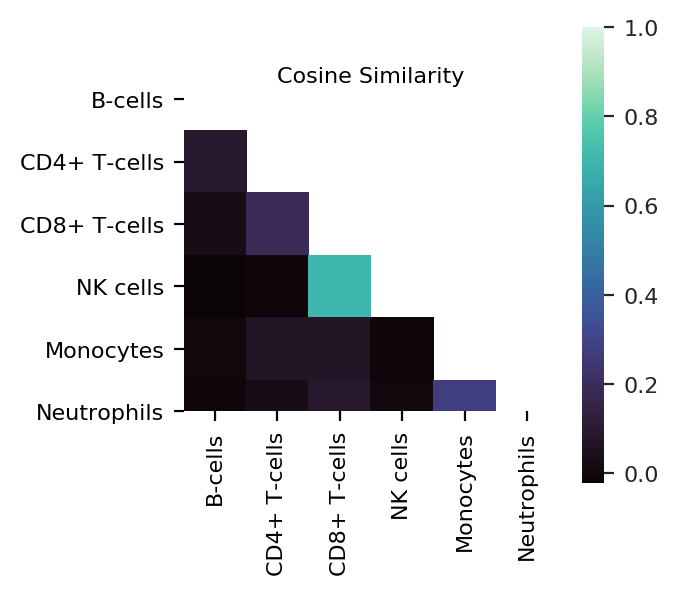

In [273]:
best = np.array(hof[0])
best_MN = np.array(hof_MN[40])
best_CD = np.array(hof_CD[0])
centroid = centroids_blood_hv[best!=0]
centroid_CD = centroids_blood_hv[best_CD!=0]
centroid_MN = centroids_blood_hv[best_MN!=0] 
common = [x for x in centroids_blood_hv.index if x in centroid.index or x in centroid_CD.index]
centroid_H = centroids_blood_hv.loc[common,:]
corr = pd.DataFrame(data = np.corrcoef(centroid_H.T), columns = centroid_H.columns, index = centroid_H.columns)
#print(np.abs(corr))
interCorr = 0
for x in corr.index:
    for y in corr.columns:
        if (x!=y):
            interCorr = interCorr + abs(corr.loc[x,y])
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = plt.axes()
ax.set_title('Cosine Similarity')
with sns.axes_style("white"):
    sns_plot = sns.heatmap(corr, 
            xticklabels=corr.columns,mask=mask,cmap=sns.color_palette("mako", 1000),square=True)
sns_plot.figure.savefig(results_file+"corr_4k_GA_H.png",dpi=300, bbox_inches='tight')
corr.to_csv(figdir+'corr.csv',sep='\t')

In [86]:
from autogenes import AutoGenes
ag = AutoGenes(centroids_blood_hv.T)
ag.run(ngen=3000,seed=0,nfeatures=300,nMU=100,mode='fixed')

/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessGA' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'IndividualGA' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	pareto	distance       	correlation 
0  	100   	4     	503.13 - 4012.2	7.69 - 14.98
1  	100   	6     	505.81 - 4012.2	6.13 - 14.99
2  	100   	7     	490.44 - 4012.2	6.13 - 14.92
3  	100   	7     	547.31 - 4227.05	6.13 - 14.92
4  	100   	9     	534.0 - 4227.05 	6.13 - 14.92
5  	100   	8     	534.0 - 4227.09 	6.13 - 14.92
6  	100   	7     	568.94 - 4227.09	6.12 - 14.92
7  	100   	9     	568.39 - 4227.09	6.12 - 14.92
8  	100   	9     	595.6 - 4227.09 	6.12 - 14.78
9  	100   	9     	812.81 - 4227.09	6.12 - 14.78
10 	100   	10    	812.81 - 4227.09	6.12 - 14.78
11 	100   	9     	812.71 - 4227.09	6.12 - 14.72
12 	100   	10    	812.71 - 4227.17	5.88 - 14.72
13 	100   	10    	1381.5 - 4227.19	5.88 - 14.72
14 	100   	13    	1381.5 - 4262.64	5.88 - 14.72
15 	100   	17    	1381.5 - 4262.64	5.87 - 14.72
16 	100   	17    	1381.5 - 4262.64	5.87 - 14.72
17 	100   	15    	1381.48 - 4262.64	5.8 - 14.72 
18 	100   	15    	1382.91 - 4262.64	5.8 - 14.72 
19 	100   	16    	1382.91 - 4262.64	5.8 - 

168	100   	44    	1400.34 - 5097.34	3.62 - 14.43
169	100   	38    	1400.34 - 5097.34	3.62 - 14.43
170	100   	39    	1400.34 - 5097.34	3.62 - 14.43
171	100   	43    	1400.2 - 5097.34 	3.61 - 14.43
172	100   	45    	1400.2 - 5097.38 	3.61 - 14.43
173	100   	44    	1400.2 - 5097.38 	3.61 - 14.43
174	100   	39    	1400.2 - 5097.39 	3.61 - 14.43
175	100   	42    	1398.35 - 5099.8 	3.61 - 14.43
176	100   	44    	1400.34 - 5099.8 	3.58 - 14.43
177	100   	48    	1400.84 - 5099.8 	3.58 - 14.43
178	100   	52    	1393.6 - 5099.8  	3.39 - 14.43
179	100   	52    	1393.6 - 5099.8  	3.39 - 14.43
180	100   	52    	1393.6 - 5099.8  	3.39 - 14.43
181	100   	50    	1393.6 - 5099.8  	3.39 - 14.43
182	100   	46    	1393.46 - 5099.8 	3.38 - 14.43
183	100   	45    	1393.46 - 5099.8 	3.38 - 14.43
184	100   	49    	1393.46 - 5099.8 	3.38 - 14.43
185	100   	45    	1393.46 - 5099.8 	3.38 - 14.43
186	100   	46    	1393.46 - 5099.8 	3.36 - 14.43
187	100   	46    	1393.46 - 5099.8 	3.36 - 14.43
188	100   	50    	13

336	100   	77    	1967.16 - 5382.18	2.64 - 14.41
337	100   	77    	1967.16 - 5382.18	2.64 - 14.41
338	100   	79    	1966.98 - 5382.18	2.64 - 14.41
339	100   	77    	1966.98 - 5382.18	2.64 - 14.41
340	100   	81    	1966.98 - 5382.18	2.64 - 14.41
341	100   	89    	1966.96 - 5382.18	2.64 - 14.29
342	100   	92    	1635.29 - 5382.18	2.61 - 14.29
343	100   	78    	1635.28 - 5382.18	2.61 - 14.57
344	100   	69    	1635.28 - 5382.18	2.18 - 14.57
345	100   	69    	1996.86 - 5382.18	2.17 - 14.57
346	100   	71    	1996.86 - 5382.18	2.17 - 14.29
347	100   	71    	1996.86 - 5382.18	2.17 - 14.29
348	100   	70    	1996.86 - 5382.18	2.17 - 14.29
349	100   	72    	2000.53 - 5382.19	2.17 - 14.29
350	100   	78    	2000.53 - 5382.19	2.17 - 14.29
351	100   	72    	2000.53 - 5382.19	2.17 - 14.29
352	100   	69    	2000.53 - 5382.19	2.17 - 14.29
353	100   	69    	2000.53 - 5382.19	2.17 - 14.29
354	100   	71    	2000.53 - 5382.19	2.17 - 14.29
355	100   	78    	2000.53 - 5382.19	2.17 - 14.29
356	100   	79    	19

505	100   	163   	1559.05 - 5412.16	2.05 - 14.28
506	100   	157   	1559.05 - 5412.16	2.05 - 14.28
507	100   	162   	1559.05 - 5412.16	2.05 - 14.28
508	100   	155   	1559.05 - 5412.16	2.05 - 14.28
509	100   	151   	1559.05 - 5412.16	2.05 - 14.28
510	100   	155   	1554.12 - 5412.16	2.01 - 14.28
511	100   	148   	1554.12 - 5412.16	2.01 - 14.28
512	100   	149   	1554.12 - 5412.16	2.01 - 14.28
513	100   	152   	1554.13 - 5412.16	2.01 - 14.28
514	100   	150   	1554.13 - 5412.16	2.01 - 14.28
515	100   	151   	1554.13 - 5412.16	2.01 - 14.28
516	100   	140   	1554.13 - 5412.16	2.0 - 14.28 
517	100   	144   	1554.25 - 5412.16	2.0 - 14.28 
518	100   	137   	1554.25 - 5412.16	2.0 - 14.28 
519	100   	134   	1554.25 - 5412.16	2.0 - 14.28 
520	100   	139   	1554.25 - 5412.16	2.0 - 14.28 
521	100   	140   	1554.25 - 5412.16	2.0 - 14.28 
522	100   	140   	1554.25 - 5412.16	2.0 - 14.28 
523	100   	143   	1554.25 - 5412.16	2.0 - 14.28 
524	100   	141   	1554.25 - 5412.16	2.0 - 14.28 
525	100   	116   	15

675	100   	127   	1562.52 - 5427.73	1.93 - 14.27
676	100   	128   	1562.52 - 5427.73	1.93 - 14.27
677	100   	125   	1562.52 - 5427.8 	1.93 - 14.27
678	100   	122   	1562.52 - 5427.8 	1.93 - 14.27
679	100   	121   	1562.52 - 5427.8 	1.93 - 14.27
680	100   	122   	1562.52 - 5427.8 	1.93 - 14.27
681	100   	126   	1562.52 - 5427.81	1.93 - 14.27
682	100   	125   	1562.52 - 5427.81	1.93 - 14.27
683	100   	128   	1562.52 - 5427.81	1.93 - 14.27
684	100   	128   	1562.52 - 5427.81	1.93 - 14.27
685	100   	132   	1562.52 - 5427.81	1.93 - 14.27
686	100   	137   	1563.1 - 5427.81 	1.93 - 14.27
687	100   	132   	1563.1 - 5427.81 	1.93 - 14.27
688	100   	126   	1563.1 - 5427.81 	1.93 - 14.27
689	100   	126   	1563.1 - 5427.81 	1.93 - 14.27
690	100   	129   	1563.1 - 5427.81 	1.93 - 14.27
691	100   	128   	1563.1 - 5427.81 	1.93 - 14.27
692	100   	133   	1563.1 - 5427.81 	1.93 - 14.27
693	100   	133   	1563.1 - 5427.81 	1.93 - 14.27
694	100   	136   	1563.1 - 5427.81 	1.93 - 14.27
695	100   	136   	15

843	100   	203   	1665.21 - 5474.86	1.77 - 14.25
844	100   	201   	1665.22 - 5474.86	1.76 - 14.25
845	100   	198   	1665.22 - 5474.86	1.76 - 14.25
846	100   	202   	1665.22 - 5474.86	1.76 - 14.25
847	100   	206   	1665.22 - 5474.86	1.76 - 14.25
848	100   	201   	1665.22 - 5474.86	1.76 - 14.25
849	100   	199   	1665.22 - 5474.86	1.76 - 14.25
850	100   	197   	1665.22 - 5474.86	1.76 - 14.25
851	100   	198   	1665.22 - 5474.86	1.76 - 14.25
852	100   	197   	1665.22 - 5474.86	1.76 - 14.25
853	100   	193   	1665.22 - 5474.86	1.76 - 14.25
854	100   	188   	1664.65 - 5474.86	1.76 - 14.25
855	100   	189   	1664.65 - 5474.86	1.76 - 14.25
856	100   	190   	1664.65 - 5474.86	1.76 - 14.25
857	100   	190   	1664.65 - 5474.86	1.76 - 14.25
858	100   	183   	1664.65 - 5474.86	1.76 - 14.25
859	100   	184   	1664.65 - 5474.86	1.76 - 14.25
860	100   	187   	1664.65 - 5474.86	1.76 - 14.25
861	100   	182   	1664.65 - 5474.86	1.76 - 14.25
862	100   	181   	1664.65 - 5474.86	1.76 - 14.25
863	100   	176   	16

1011	100   	244   	1670.84 - 5486.24	1.73 - 14.25
1012	100   	246   	1670.84 - 5486.24	1.73 - 14.25
1013	100   	249   	1670.84 - 5486.24	1.73 - 14.25
1014	100   	249   	1670.69 - 5486.24	1.73 - 14.25
1015	100   	242   	1670.69 - 5486.24	1.73 - 14.25
1016	100   	241   	1670.69 - 5486.24	1.73 - 14.25
1017	100   	243   	1670.69 - 5486.24	1.73 - 14.25
1018	100   	236   	1670.69 - 5486.24	1.73 - 14.25
1019	100   	236   	1670.69 - 5486.24	1.73 - 14.25
1020	100   	236   	1670.69 - 5486.24	1.73 - 14.25
1021	100   	238   	1670.69 - 5486.24	1.73 - 14.25
1022	100   	240   	1670.69 - 5486.24	1.73 - 14.25
1023	100   	243   	1670.69 - 5486.24	1.73 - 14.25
1024	100   	245   	1670.69 - 5486.24	1.73 - 14.25
1025	100   	249   	1670.69 - 5486.24	1.73 - 14.25
1026	100   	242   	1670.69 - 5486.24	1.73 - 14.25
1027	100   	241   	1670.69 - 5486.24	1.73 - 14.25
1028	100   	242   	1670.69 - 5486.24	1.73 - 14.25
1029	100   	241   	1670.69 - 5486.24	1.73 - 14.25
1030	100   	242   	1670.69 - 5486.25	1.73 - 14.25


1175	100   	260   	1650.97 - 5511.26	1.69 - 14.24
1176	100   	256   	1650.97 - 5511.26	1.69 - 14.24
1177	100   	259   	1650.97 - 5511.26	1.69 - 14.24
1178	100   	259   	1650.97 - 5511.26	1.69 - 14.24
1179	100   	261   	1650.97 - 5511.26	1.69 - 14.24
1180	100   	260   	1650.97 - 5511.26	1.69 - 14.24
1181	100   	265   	1650.97 - 5511.26	1.69 - 14.24
1182	100   	262   	1650.97 - 5511.26	1.69 - 14.24
1183	100   	256   	1650.97 - 5511.26	1.69 - 14.24
1184	100   	255   	1650.97 - 5511.27	1.69 - 14.24
1185	100   	259   	1650.97 - 5511.27	1.69 - 14.24
1186	100   	258   	1650.89 - 5511.27	1.69 - 14.24
1187	100   	258   	1650.89 - 5511.27	1.69 - 14.24
1188	100   	259   	1650.89 - 5511.27	1.69 - 14.24
1189	100   	261   	1650.89 - 5511.27	1.69 - 14.24
1190	100   	265   	1650.89 - 5511.27	1.69 - 14.24
1191	100   	265   	1650.68 - 5511.27	1.69 - 14.24
1192	100   	269   	1650.68 - 5511.27	1.69 - 14.24
1193	100   	274   	1650.68 - 5511.27	1.69 - 14.24
1194	100   	277   	1650.68 - 5511.27	1.69 - 14.24


1340	100   	276   	1078.35 - 5512.38	1.66 - 14.24
1341	100   	278   	1078.35 - 5512.38	1.66 - 14.24
1342	100   	278   	1078.35 - 5512.38	1.66 - 14.24
1343	100   	278   	1078.35 - 5512.38	1.66 - 14.24
1344	100   	278   	1078.35 - 5512.38	1.66 - 14.24
1345	100   	280   	1078.35 - 5512.38	1.66 - 14.24
1346	100   	274   	1078.25 - 5512.38	1.66 - 14.24
1347	100   	277   	1078.25 - 5512.38	1.66 - 14.24
1348	100   	277   	1078.25 - 5512.38	1.66 - 14.24
1349	100   	281   	1078.25 - 5512.38	1.66 - 14.24
1350	100   	281   	1078.25 - 5512.38	1.66 - 14.24
1351	100   	278   	1078.25 - 5512.38	1.66 - 14.24
1352	100   	276   	1078.25 - 5512.38	1.66 - 14.24
1353	100   	276   	1078.25 - 5512.38	1.66 - 14.24
1354	100   	272   	1078.25 - 5512.38	1.66 - 14.24
1355	100   	267   	1078.25 - 5512.38	1.66 - 14.24
1356	100   	271   	1074.71 - 5512.38	1.66 - 14.24
1357	100   	273   	1074.71 - 5512.38	1.66 - 14.24
1358	100   	277   	1074.71 - 5512.38	1.66 - 14.24
1359	100   	279   	1074.71 - 5512.38	1.66 - 14.24


1505	100   	333   	1066.09 - 5538.74	1.58 - 14.23
1506	100   	334   	1066.09 - 5538.74	1.58 - 14.23
1507	100   	327   	1066.09 - 5538.74	1.58 - 14.23
1508	100   	331   	1066.09 - 5538.74	1.58 - 14.23
1509	100   	332   	1066.09 - 5538.74	1.58 - 14.23
1510	100   	335   	1066.09 - 5538.74	1.58 - 14.23
1511	100   	339   	1066.09 - 5538.74	1.58 - 14.23
1512	100   	347   	1066.09 - 5538.74	1.58 - 14.23
1513	100   	346   	1066.09 - 5538.74	1.58 - 14.23
1514	100   	344   	1066.13 - 5538.74	1.58 - 14.23
1515	100   	345   	1066.13 - 5538.74	1.58 - 14.23
1516	100   	342   	1066.13 - 5538.74	1.58 - 14.23
1517	100   	344   	1066.13 - 5538.74	1.58 - 14.23
1518	100   	347   	1066.13 - 5538.74	1.58 - 14.23
1519	100   	341   	1066.13 - 5538.74	1.58 - 14.23
1520	100   	343   	1066.13 - 5538.74	1.58 - 14.23
1521	100   	339   	1066.13 - 5538.74	1.57 - 14.23
1522	100   	341   	1066.13 - 5538.74	1.57 - 14.23
1523	100   	342   	1066.13 - 5538.74	1.57 - 14.23
1524	100   	344   	1066.13 - 5538.74	1.57 - 14.23


1669	100   	359   	1007.63 - 5539.72	1.48 - 14.23
1670	100   	361   	1007.63 - 5539.72	1.48 - 14.23
1671	100   	363   	1007.63 - 5539.72	1.48 - 14.23
1672	100   	363   	1007.63 - 5539.72	1.48 - 14.23
1673	100   	367   	1007.63 - 5540.41	1.48 - 14.23
1674	100   	361   	1007.63 - 5540.41	1.48 - 14.23
1675	100   	362   	1007.63 - 5540.41	1.48 - 14.23
1676	100   	361   	1007.63 - 5540.41	1.48 - 14.23
1677	100   	363   	1007.63 - 5544.39	1.48 - 14.23
1678	100   	362   	1007.63 - 5544.39	1.48 - 14.23
1679	100   	363   	1007.63 - 5544.39	1.48 - 14.23
1680	100   	366   	1007.63 - 5544.39	1.48 - 14.23
1681	100   	362   	1008.62 - 5544.39	1.48 - 14.23
1682	100   	367   	1008.62 - 5544.39	1.48 - 14.23
1683	100   	357   	1008.62 - 5544.39	1.48 - 14.23
1684	100   	358   	1008.62 - 5544.39	1.48 - 14.23
1685	100   	339   	1008.62 - 5544.39	1.48 - 14.23
1686	100   	336   	1008.62 - 5544.39	1.48 - 14.23
1687	100   	336   	1008.62 - 5544.39	1.48 - 14.23
1688	100   	336   	1008.62 - 5544.39	1.48 - 14.23


1833	100   	355   	1007.16 - 5553.32	1.46 - 14.23
1834	100   	360   	1007.16 - 5553.32	1.46 - 14.23
1835	100   	361   	1007.16 - 5553.32	1.46 - 14.23
1836	100   	365   	1007.16 - 5553.32	1.46 - 14.23
1837	100   	362   	1007.16 - 5553.32	1.46 - 14.23
1838	100   	365   	1007.01 - 5553.32	1.44 - 14.23
1839	100   	369   	1007.01 - 5553.32	1.44 - 14.23
1840	100   	367   	1007.01 - 5553.32	1.44 - 14.23
1841	100   	368   	1007.01 - 5554.0 	1.44 - 14.23
1842	100   	372   	1007.01 - 5554.0 	1.44 - 14.23
1843	100   	371   	1007.01 - 5554.0 	1.44 - 14.23
1844	100   	374   	1007.01 - 5554.0 	1.44 - 14.23
1845	100   	372   	1007.01 - 5554.0 	1.44 - 14.23
1846	100   	359   	1007.01 - 5554.0 	1.44 - 14.23
1847	100   	360   	1007.01 - 5554.0 	1.44 - 14.23
1848	100   	362   	1007.01 - 5554.0 	1.44 - 14.23
1849	100   	360   	1007.01 - 5554.0 	1.44 - 14.23
1850	100   	360   	1007.01 - 5554.0 	1.44 - 14.23
1851	100   	362   	1007.01 - 5554.0 	1.44 - 14.23
1852	100   	364   	1007.01 - 5554.0 	1.44 - 14.23


1997	100   	345   	912.87 - 5568.09 	1.35 - 14.22
1998	100   	342   	914.44 - 5576.47 	1.35 - 14.22
1999	100   	332   	914.44 - 5576.47 	1.35 - 14.22
2000	100   	330   	914.44 - 5576.47 	1.35 - 14.22
2001	100   	324   	914.44 - 5576.47 	1.35 - 14.22
2002	100   	330   	914.44 - 5576.47 	1.35 - 14.22
2003	100   	332   	914.44 - 5576.47 	1.35 - 14.22
2004	100   	337   	914.44 - 5576.47 	1.35 - 14.22
2005	100   	337   	914.44 - 5576.47 	1.35 - 14.22
2006	100   	334   	914.44 - 5576.47 	1.35 - 14.22
2007	100   	334   	914.44 - 5576.47 	1.35 - 14.22
2008	100   	335   	914.44 - 5576.47 	1.35 - 14.22
2009	100   	337   	914.44 - 5576.47 	1.35 - 14.22
2010	100   	334   	914.44 - 5576.47 	1.35 - 14.22
2011	100   	339   	914.44 - 5576.47 	1.35 - 14.22
2012	100   	342   	914.44 - 5576.47 	1.35 - 14.22
2013	100   	346   	914.44 - 5576.47 	1.35 - 14.22
2014	100   	341   	914.44 - 5576.47 	1.35 - 14.22
2015	100   	335   	914.44 - 5576.47 	1.35 - 14.22
2016	100   	333   	914.44 - 5576.47 	1.35 - 14.22


2161	100   	391   	915.19 - 5579.76 	1.31 - 14.22
2162	100   	390   	915.19 - 5579.76 	1.31 - 14.22
2163	100   	392   	915.19 - 5579.76 	1.31 - 14.22
2164	100   	391   	915.19 - 5579.76 	1.31 - 14.22
2165	100   	393   	915.19 - 5579.87 	1.31 - 14.22
2166	100   	393   	915.19 - 5579.87 	1.31 - 14.22
2167	100   	397   	915.19 - 5579.87 	1.31 - 14.22
2168	100   	395   	915.19 - 5579.87 	1.31 - 14.22
2169	100   	397   	915.19 - 5579.88 	1.31 - 14.22
2170	100   	399   	915.19 - 5579.88 	1.31 - 14.22
2171	100   	403   	915.19 - 5579.88 	1.31 - 14.22
2172	100   	406   	915.19 - 5579.88 	1.31 - 14.22
2173	100   	408   	915.19 - 5579.88 	1.31 - 14.22
2174	100   	407   	915.19 - 5579.88 	1.31 - 14.22
2175	100   	409   	915.19 - 5579.88 	1.31 - 14.22
2176	100   	408   	915.19 - 5579.88 	1.31 - 14.22
2177	100   	404   	915.19 - 5579.88 	1.31 - 14.22
2178	100   	405   	915.19 - 5579.88 	1.31 - 14.22
2179	100   	403   	915.16 - 5593.06 	1.31 - 14.21
2180	100   	402   	915.16 - 5593.06 	1.31 - 14.21


2325	100   	429   	915.11 - 5645.99 	1.29 - 14.13
2326	100   	433   	915.11 - 5645.99 	1.29 - 14.13
2327	100   	433   	915.11 - 5645.99 	1.29 - 14.13
2328	100   	434   	915.11 - 5645.99 	1.29 - 14.13
2329	100   	432   	915.11 - 5645.99 	1.29 - 14.13
2330	100   	425   	915.11 - 5645.99 	1.29 - 14.13
2331	100   	423   	915.11 - 5645.99 	1.29 - 14.13
2332	100   	426   	915.11 - 5645.99 	1.29 - 14.13
2333	100   	427   	915.11 - 5645.99 	1.29 - 14.13
2334	100   	427   	915.11 - 5645.99 	1.29 - 14.13
2335	100   	429   	915.11 - 5645.99 	1.29 - 14.13
2336	100   	427   	915.11 - 5645.99 	1.29 - 14.13
2337	100   	422   	915.11 - 5645.99 	1.29 - 14.13
2338	100   	413   	915.11 - 5645.99 	1.29 - 14.13
2339	100   	412   	915.11 - 5645.99 	1.29 - 14.13
2340	100   	413   	915.11 - 5645.99 	1.29 - 14.13
2341	100   	413   	915.11 - 5645.99 	1.29 - 14.13
2342	100   	405   	915.11 - 5645.99 	1.29 - 14.13
2343	100   	403   	915.11 - 5645.99 	1.29 - 14.13
2344	100   	404   	915.11 - 5645.99 	1.29 - 14.13


2489	100   	427   	915.05 - 5656.76 	1.28 - 14.12
2490	100   	429   	915.05 - 5656.76 	1.28 - 14.12
2491	100   	436   	915.05 - 5656.76 	1.28 - 14.12
2492	100   	436   	915.05 - 5656.76 	1.28 - 14.12
2493	100   	437   	915.05 - 5656.76 	1.28 - 14.12
2494	100   	444   	915.05 - 5656.76 	1.28 - 14.12
2495	100   	442   	915.05 - 5658.03 	1.28 - 14.12
2496	100   	437   	915.05 - 5658.03 	1.28 - 14.12
2497	100   	440   	915.05 - 5658.03 	1.28 - 14.12
2498	100   	442   	915.05 - 5658.03 	1.28 - 14.12
2499	100   	445   	915.05 - 5658.03 	1.28 - 14.12
2500	100   	445   	915.05 - 5658.03 	1.28 - 14.12
2501	100   	447   	915.05 - 5658.03 	1.28 - 14.12
2502	100   	449   	915.05 - 5658.03 	1.28 - 14.12
2503	100   	453   	915.05 - 5658.03 	1.28 - 14.12
2504	100   	453   	915.06 - 5658.03 	1.28 - 14.12
2505	100   	454   	915.06 - 5658.03 	1.28 - 14.12
2506	100   	457   	915.06 - 5658.03 	1.28 - 14.12
2507	100   	462   	915.06 - 5658.03 	1.28 - 14.12
2508	100   	466   	915.06 - 5658.03 	1.28 - 14.12


2653	100   	506   	914.76 - 5677.45 	1.27 - 14.11
2654	100   	508   	914.76 - 5677.45 	1.27 - 14.11
2655	100   	510   	914.76 - 5677.45 	1.27 - 14.11
2656	100   	509   	914.76 - 5677.45 	1.27 - 14.11
2657	100   	511   	914.76 - 5677.45 	1.27 - 14.11
2658	100   	518   	914.76 - 5677.45 	1.27 - 14.11
2659	100   	517   	914.76 - 5677.84 	1.27 - 14.11
2660	100   	514   	914.76 - 5677.84 	1.27 - 14.11
2661	100   	516   	914.76 - 5677.84 	1.27 - 14.11
2662	100   	521   	914.76 - 5677.84 	1.27 - 14.11
2663	100   	519   	914.76 - 5677.84 	1.27 - 14.11
2664	100   	521   	914.76 - 5677.84 	1.27 - 14.11
2665	100   	518   	914.76 - 5677.84 	1.27 - 14.11
2666	100   	518   	914.76 - 5677.84 	1.27 - 14.11
2667	100   	522   	914.76 - 5677.84 	1.27 - 14.11
2668	100   	523   	914.76 - 5677.84 	1.27 - 14.11
2669	100   	526   	914.76 - 5677.84 	1.27 - 14.11
2670	100   	529   	914.76 - 5677.84 	1.27 - 14.11
2671	100   	526   	914.76 - 5677.84 	1.27 - 14.11
2672	100   	526   	914.76 - 5677.84 	1.27 - 14.11


2818	100   	549   	913.32 - 5679.14 	1.26 - 14.11
2819	100   	549   	913.32 - 5679.14 	1.26 - 14.11
2820	100   	551   	913.32 - 5679.14 	1.26 - 14.11
2821	100   	553   	913.32 - 5679.14 	1.26 - 14.11
2822	100   	557   	913.32 - 5679.14 	1.26 - 14.11
2823	100   	554   	913.32 - 5679.14 	1.26 - 14.11
2824	100   	548   	913.32 - 5679.14 	1.26 - 14.11
2825	100   	552   	913.32 - 5679.14 	1.26 - 14.11
2826	100   	555   	913.32 - 5679.14 	1.26 - 14.11
2827	100   	551   	913.32 - 5679.14 	1.26 - 14.11
2828	100   	549   	913.32 - 5679.14 	1.26 - 14.11
2829	100   	548   	913.32 - 5679.14 	1.26 - 14.11
2830	100   	547   	913.32 - 5679.14 	1.26 - 14.11
2831	100   	550   	913.32 - 5679.14 	1.26 - 14.11
2832	100   	552   	913.32 - 5679.14 	1.26 - 14.11
2833	100   	555   	913.32 - 5679.14 	1.26 - 14.11
2834	100   	550   	913.32 - 5679.14 	1.26 - 14.11
2835	100   	549   	913.32 - 5679.14 	1.26 - 14.11
2836	100   	552   	913.31 - 5679.14 	1.26 - 14.11
2837	100   	549   	913.31 - 5679.14 	1.26 - 14.11


2982	100   	529   	913.39 - 5694.27 	1.26 - 14.11
2983	100   	531   	913.39 - 5694.27 	1.26 - 14.11
2984	100   	527   	913.39 - 5694.27 	1.26 - 14.11
2985	100   	529   	913.39 - 5694.27 	1.26 - 14.11
2986	100   	531   	913.39 - 5694.27 	1.26 - 14.11
2987	100   	526   	913.37 - 5694.27 	1.25 - 14.11
2988	100   	525   	912.2 - 5694.27  	1.25 - 14.11
2989	100   	521   	912.2 - 5694.27  	1.25 - 14.11
2990	100   	524   	912.2 - 5694.27  	1.25 - 14.11
2991	100   	527   	912.2 - 5694.27  	1.25 - 14.11
2992	100   	520   	912.2 - 5694.27  	1.25 - 14.11
2993	100   	521   	912.2 - 5694.27  	1.25 - 14.11
2994	100   	524   	912.2 - 5694.27  	1.25 - 14.11
2995	100   	530   	912.2 - 5694.27  	1.25 - 14.11
2996	100   	532   	912.2 - 5694.27  	1.25 - 14.11
2997	100   	535   	912.2 - 5694.27  	1.25 - 14.11
2998	100   	534   	912.2 - 5694.27  	1.25 - 14.11
2999	100   	535   	912.2 - 5694.27  	1.25 - 14.11
3000	100   	537   	912.2 - 5694.27  	1.25 - 14.11


In [59]:
ag_CD = AutoGenes(centroids_blood_hv.loc[:,['NK cells','CD8+ T-cells']].T)
ag_CD.run(ngen=2000,seed=0,nfeatures=30,nMU=100,mode='fixed')

/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessGA' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'IndividualGA' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	pareto	distance    	correlation
0  	100   	8     	0.81 - 91.69	0.2 - 1.0  
1  	100   	10    	0.97 - 91.69	0.2 - 1.0  
2  	100   	9     	2.03 - 91.69	0.18 - 1.0 
3  	100   	12    	5.81 - 91.69	0.17 - 1.0 
4  	100   	10    	5.81 - 91.69	0.14 - 1.0 
5  	100   	10    	6.74 - 91.69	0.14 - 1.0 
6  	100   	8     	6.81 - 92.35	0.14 - 1.0 
7  	100   	8     	6.81 - 92.35	0.14 - 1.0 
8  	100   	9     	9.22 - 92.35	0.14 - 1.0 
9  	100   	13    	9.27 - 92.35	0.13 - 1.0 
10 	100   	14    	9.27 - 92.35	0.1 - 1.0  
11 	100   	16    	11.34 - 92.35	0.1 - 1.0  
12 	100   	19    	11.39 - 92.35	0.1 - 1.0  
13 	100   	16    	11.35 - 92.35	0.1 - 1.0  
14 	100   	13    	11.35 - 92.35	0.1 - 1.0  
15 	100   	12    	11.39 - 92.38	0.1 - 1.0  
16 	100   	15    	11.4 - 92.38 	0.1 - 1.0  
17 	100   	14    	11.29 - 92.38	0.1 - 1.0  
18 	100   	14    	9.33 - 92.38 	0.1 - 1.0  
19 	100   	15    	11.4 - 92.45 	0.1 - 1.0  
20 	100   	15    	11.41 - 92.49	0.1 - 1.0  
21 	100   	15    	11.41 - 92.49	0.1 - 1.0  


186	100   	51    	13.63 - 131.37	0.0 - 0.99 
187	100   	56    	13.63 - 131.37	0.0 - 0.99 
188	100   	52    	13.63 - 131.37	0.0 - 0.99 
189	100   	53    	13.63 - 131.37	0.0 - 0.99 
190	100   	53    	13.63 - 131.37	0.0 - 0.99 
191	100   	56    	13.63 - 131.37	0.0 - 0.99 
192	100   	46    	13.63 - 131.37	0.0 - 0.99 
193	100   	48    	13.63 - 131.37	0.0 - 0.99 
194	100   	51    	13.63 - 131.37	0.0 - 0.99 
195	100   	50    	13.63 - 131.37	0.0 - 0.99 
196	100   	52    	13.63 - 131.37	0.0 - 0.99 
197	100   	55    	13.63 - 131.37	0.0 - 0.99 
198	100   	53    	13.63 - 131.46	0.0 - 0.99 
199	100   	55    	13.63 - 131.46	0.0 - 0.99 
200	100   	59    	13.63 - 131.46	0.0 - 0.99 
201	100   	60    	13.63 - 131.46	0.0 - 0.99 
202	100   	54    	13.63 - 131.46	0.0 - 0.99 
203	100   	54    	13.63 - 131.46	0.0 - 0.99 
204	100   	57    	13.63 - 131.46	0.0 - 0.99 
205	100   	51    	13.63 - 131.46	0.0 - 0.99 
206	100   	51    	13.63 - 131.46	0.0 - 0.99 
207	100   	51    	13.63 - 131.46	0.0 - 0.99 
208	100   

369	100   	75    	13.63 - 133.66	0.0 - 0.99 
370	100   	76    	13.63 - 133.66	0.0 - 0.99 
371	100   	75    	13.63 - 133.66	0.0 - 0.99 
372	100   	73    	13.63 - 133.71	0.0 - 0.99 
373	100   	73    	13.63 - 133.71	0.0 - 0.99 
374	100   	68    	13.63 - 133.71	0.0 - 0.99 
375	100   	66    	13.63 - 133.71	0.0 - 0.99 
376	100   	67    	13.63 - 133.71	0.0 - 0.99 
377	100   	66    	13.63 - 133.71	0.0 - 0.99 
378	100   	63    	13.63 - 133.71	0.0 - 0.99 
379	100   	59    	13.63 - 133.71	0.0 - 0.99 
380	100   	61    	13.63 - 133.71	0.0 - 0.99 
381	100   	61    	13.63 - 133.71	0.0 - 0.99 
382	100   	63    	13.63 - 133.71	0.0 - 0.99 
383	100   	65    	13.63 - 133.71	0.0 - 0.99 
384	100   	67    	12.98 - 133.71	0.0 - 0.99 
385	100   	67    	12.98 - 133.71	0.0 - 0.99 
386	100   	67    	13.63 - 133.71	0.0 - 0.99 
387	100   	67    	13.63 - 133.71	0.0 - 0.99 
388	100   	68    	13.63 - 133.71	0.0 - 0.99 
389	100   	68    	13.63 - 133.71	0.0 - 0.99 
390	100   	70    	13.63 - 133.71	0.0 - 0.99 
391	100   

555	100   	79    	16.83 - 134.88	0.0 - 0.99 
556	100   	80    	16.83 - 134.88	0.0 - 0.99 
557	100   	80    	16.83 - 134.88	0.0 - 0.99 
558	100   	78    	16.83 - 134.88	0.0 - 0.99 
559	100   	78    	16.83 - 134.88	0.0 - 0.99 
560	100   	78    	16.83 - 134.88	0.0 - 0.99 
561	100   	77    	16.83 - 134.88	0.0 - 0.99 
562	100   	77    	16.83 - 134.88	0.0 - 0.99 
563	100   	79    	16.83 - 134.88	0.0 - 0.99 
564	100   	78    	16.82 - 134.88	0.0 - 0.99 
565	100   	78    	16.83 - 134.88	0.0 - 0.99 
566	100   	78    	16.83 - 134.88	0.0 - 0.99 
567	100   	66    	16.83 - 135.33	0.0 - 0.99 
568	100   	67    	16.83 - 135.33	0.0 - 0.99 
569	100   	68    	16.83 - 135.33	0.0 - 0.99 
570	100   	70    	16.83 - 135.33	0.0 - 0.99 
571	100   	72    	16.83 - 135.33	0.0 - 0.99 
572	100   	71    	16.83 - 135.33	0.0 - 0.99 
573	100   	67    	16.83 - 135.33	0.0 - 0.99 
574	100   	66    	16.83 - 135.33	0.0 - 0.99 
575	100   	65    	16.83 - 135.33	0.0 - 0.99 
576	100   	65    	16.83 - 135.33	0.0 - 0.99 
577	100   

738	100   	47    	16.83 - 140.27	0.0 - 0.99 
739	100   	46    	16.83 - 140.27	0.0 - 0.99 
740	100   	48    	16.83 - 140.27	0.0 - 0.99 
741	100   	48    	16.83 - 140.27	0.0 - 0.99 
742	100   	47    	16.83 - 140.27	0.0 - 0.99 
743	100   	46    	16.83 - 140.27	0.0 - 0.99 
744	100   	46    	16.83 - 140.27	0.0 - 0.99 
745	100   	45    	16.83 - 140.27	0.0 - 0.99 
746	100   	49    	16.83 - 140.27	0.0 - 0.99 
747	100   	46    	16.83 - 140.27	0.0 - 0.99 
748	100   	44    	16.83 - 140.27	0.0 - 0.99 
749	100   	45    	16.83 - 140.27	0.0 - 0.99 
750	100   	48    	16.83 - 140.27	0.0 - 0.99 
751	100   	44    	16.83 - 140.27	0.0 - 0.99 
752	100   	44    	16.83 - 140.27	0.0 - 0.99 
753	100   	45    	16.83 - 140.27	0.0 - 0.99 
754	100   	50    	16.83 - 140.27	0.0 - 0.99 
755	100   	48    	16.83 - 140.27	0.0 - 0.99 
756	100   	44    	16.83 - 140.27	0.0 - 0.99 
757	100   	47    	16.83 - 140.27	0.0 - 0.99 
758	100   	46    	16.83 - 140.27	0.0 - 0.99 
759	100   	45    	16.83 - 140.27	0.0 - 0.99 
760	100   

921	100   	68    	16.83 - 141.37	0.0 - 0.99 
922	100   	68    	16.83 - 141.37	0.0 - 0.99 
923	100   	68    	16.83 - 141.37	0.0 - 0.99 
924	100   	68    	15.87 - 141.37	0.0 - 1.0  
925	100   	69    	16.83 - 141.37	0.0 - 0.99 
926	100   	70    	16.83 - 141.37	0.0 - 0.99 
927	100   	71    	16.83 - 141.37	0.0 - 0.99 
928	100   	73    	16.83 - 141.37	0.0 - 0.99 
929	100   	73    	16.83 - 141.37	0.0 - 0.99 
930	100   	74    	16.83 - 141.37	0.0 - 0.99 
931	100   	73    	16.83 - 141.37	0.0 - 0.99 
932	100   	74    	16.83 - 141.37	0.0 - 0.99 
933	100   	74    	16.83 - 141.37	0.0 - 0.99 
934	100   	74    	16.83 - 141.37	0.0 - 0.99 
935	100   	71    	16.83 - 141.37	0.0 - 0.99 
936	100   	72    	16.83 - 141.37	0.0 - 0.99 
937	100   	62    	16.83 - 141.37	0.0 - 0.99 
938	100   	61    	16.83 - 141.37	0.0 - 0.99 
939	100   	62    	16.83 - 141.37	0.0 - 0.99 
940	100   	62    	16.83 - 141.37	0.0 - 0.99 
941	100   	62    	16.83 - 141.37	0.0 - 0.99 
942	100   	62    	16.83 - 141.37	0.0 - 0.99 
943	100   

1102	100   	65    	16.83 - 141.92	0.0 - 0.99 
1103	100   	66    	16.83 - 141.92	0.0 - 0.99 
1104	100   	69    	16.83 - 141.92	0.0 - 0.99 
1105	100   	67    	16.83 - 141.92	0.0 - 0.99 
1106	100   	67    	16.83 - 141.92	0.0 - 0.99 
1107	100   	68    	16.83 - 141.92	0.0 - 0.99 
1108	100   	69    	16.83 - 141.92	0.0 - 0.99 
1109	100   	72    	16.83 - 141.92	0.0 - 0.99 
1110	100   	74    	16.83 - 141.92	0.0 - 0.99 
1111	100   	73    	16.83 - 141.92	0.0 - 0.99 
1112	100   	75    	16.83 - 141.92	0.0 - 0.99 
1113	100   	75    	16.83 - 141.92	0.0 - 0.99 
1114	100   	75    	16.83 - 141.92	0.0 - 0.99 
1115	100   	74    	16.83 - 141.92	0.0 - 0.99 
1116	100   	73    	16.83 - 141.92	0.0 - 0.99 
1117	100   	74    	16.83 - 141.92	0.0 - 0.99 
1118	100   	77    	16.83 - 141.92	0.0 - 0.99 
1119	100   	78    	16.83 - 141.92	0.0 - 0.99 
1120	100   	78    	16.83 - 141.92	0.0 - 0.99 
1121	100   	78    	16.83 - 141.92	0.0 - 0.99 
1122	100   	78    	16.83 - 141.92	0.0 - 0.99 
1123	100   	76    	16.83 - 141.92	

1282	100   	85    	16.83 - 142.39	0.0 - 0.99 
1283	100   	86    	16.83 - 142.39	0.0 - 0.99 
1284	100   	85    	16.83 - 142.39	0.0 - 0.99 
1285	100   	82    	16.83 - 142.39	0.0 - 0.99 
1286	100   	82    	16.83 - 142.39	0.0 - 0.99 
1287	100   	86    	16.83 - 142.39	0.0 - 0.99 
1288	100   	87    	16.83 - 142.39	0.0 - 0.99 
1289	100   	90    	16.83 - 142.39	0.0 - 0.99 
1290	100   	93    	16.83 - 142.39	0.0 - 0.99 
1291	100   	93    	16.83 - 142.39	0.0 - 0.99 
1292	100   	94    	16.83 - 142.39	0.0 - 0.99 
1293	100   	94    	16.83 - 142.39	0.0 - 0.99 
1294	100   	93    	16.83 - 142.39	0.0 - 0.99 
1295	100   	92    	16.83 - 142.39	0.0 - 0.99 
1296	100   	92    	16.83 - 142.39	0.0 - 0.99 
1297	100   	92    	16.83 - 142.39	0.0 - 0.99 
1298	100   	90    	16.83 - 142.39	0.0 - 0.99 
1299	100   	88    	16.83 - 142.39	0.0 - 0.99 
1300	100   	89    	16.83 - 142.39	0.0 - 0.99 
1301	100   	89    	16.83 - 142.39	0.0 - 0.99 
1302	100   	89    	16.83 - 142.39	0.0 - 0.99 
1303	100   	90    	16.83 - 142.39	

1462	100   	93    	16.83 - 143.37	0.0 - 0.99 
1463	100   	93    	16.83 - 143.37	0.0 - 0.99 
1464	100   	93    	16.83 - 143.37	0.0 - 0.99 
1465	100   	93    	16.83 - 143.37	0.0 - 0.99 
1466	100   	93    	16.83 - 143.37	0.0 - 0.99 
1467	100   	89    	16.83 - 143.37	0.0 - 0.99 
1468	100   	89    	16.83 - 143.37	0.0 - 0.99 
1469	100   	90    	16.83 - 143.37	0.0 - 0.99 
1470	100   	90    	16.83 - 143.37	0.0 - 0.99 
1471	100   	91    	16.83 - 143.37	0.0 - 0.99 
1472	100   	92    	16.83 - 143.37	0.0 - 0.99 
1473	100   	92    	16.83 - 143.37	0.0 - 0.99 
1474	100   	94    	16.83 - 143.37	0.0 - 0.99 
1475	100   	96    	16.83 - 143.37	0.0 - 0.99 
1476	100   	97    	16.83 - 143.37	0.0 - 0.99 
1477	100   	98    	16.83 - 143.37	0.0 - 0.99 
1478	100   	100   	16.83 - 143.37	0.0 - 0.99 
1479	100   	100   	16.83 - 143.37	0.0 - 0.99 
1480	100   	100   	16.83 - 143.37	0.0 - 0.99 
1481	100   	99    	16.83 - 143.37	0.0 - 0.99 
1482	100   	100   	16.83 - 143.37	0.0 - 0.99 
1483	100   	100   	16.83 - 143.37	

1642	100   	110   	16.83 - 143.4 	0.0 - 0.99 
1643	100   	109   	16.83 - 143.4 	0.0 - 0.99 
1644	100   	109   	16.83 - 143.4 	0.0 - 0.99 
1645	100   	110   	16.83 - 143.4 	0.0 - 0.99 
1646	100   	110   	16.83 - 143.4 	0.0 - 0.99 
1647	100   	107   	16.83 - 143.4 	0.0 - 0.99 
1648	100   	108   	16.83 - 143.4 	0.0 - 0.99 
1649	100   	103   	16.83 - 143.4 	0.0 - 0.99 
1650	100   	103   	16.83 - 143.4 	0.0 - 0.99 
1651	100   	103   	16.83 - 143.4 	0.0 - 0.99 
1652	100   	103   	16.83 - 143.4 	0.0 - 0.99 
1653	100   	103   	16.83 - 143.4 	0.0 - 0.99 
1654	100   	106   	16.83 - 143.4 	0.0 - 0.99 
1655	100   	104   	16.83 - 143.4 	0.0 - 0.99 
1656	100   	103   	16.83 - 143.4 	0.0 - 0.99 
1657	100   	103   	16.83 - 143.4 	0.0 - 0.99 
1658	100   	103   	16.83 - 143.4 	0.0 - 0.99 
1659	100   	105   	16.83 - 143.4 	0.0 - 0.99 
1660	100   	103   	16.83 - 143.4 	0.0 - 0.99 
1661	100   	102   	16.83 - 143.4 	0.0 - 0.99 
1662	100   	102   	16.83 - 143.4 	0.0 - 0.99 
1663	100   	101   	16.83 - 143.4 	

1823	100   	62    	16.83 - 144.1 	0.0 - 0.99 
1824	100   	59    	16.83 - 144.1 	0.0 - 0.99 
1825	100   	60    	16.83 - 144.1 	0.0 - 0.99 
1826	100   	60    	16.83 - 144.1 	0.0 - 0.99 
1827	100   	60    	16.83 - 144.1 	0.0 - 0.99 
1828	100   	61    	16.83 - 144.1 	0.0 - 0.99 
1829	100   	61    	16.83 - 144.1 	0.0 - 0.99 
1830	100   	62    	16.83 - 144.1 	0.0 - 0.99 
1831	100   	62    	16.83 - 144.1 	0.0 - 0.99 
1832	100   	62    	16.83 - 144.1 	0.0 - 0.99 
1833	100   	62    	16.83 - 144.1 	0.0 - 0.99 
1834	100   	62    	16.83 - 144.1 	0.0 - 0.99 
1835	100   	62    	16.83 - 144.1 	0.0 - 0.99 
1836	100   	62    	16.83 - 144.1 	0.0 - 0.99 
1837	100   	62    	16.83 - 144.1 	0.0 - 0.99 
1838	100   	62    	16.83 - 144.1 	0.0 - 0.99 
1839	100   	63    	16.83 - 144.1 	0.0 - 0.99 
1840	100   	60    	16.83 - 144.1 	0.0 - 0.99 
1841	100   	60    	16.83 - 144.1 	0.0 - 0.99 
1842	100   	60    	16.83 - 144.1 	0.0 - 0.99 
1843	100   	62    	16.83 - 144.1 	0.0 - 0.99 
1844	100   	64    	16.83 - 144.1 	

In [60]:
ag_MN = AutoGenes(centroids_blood_hv.loc[:,['Monocytes','Neutrophils']].T)
ag_MN.run(ngen=2000,seed=0,nfeatures=30,nMU=100,mode='fixed')

gen	nevals	pareto	distance     	correlation
0  	100   	5     	2.67 - 174.07	0.03 - 1.0 
1  	100   	8     	2.95 - 176.15	0.03 - 1.0 
2  	100   	10    	2.95 - 176.15	0.01 - 1.0 
3  	100   	10    	3.54 - 176.15	0.01 - 1.0 
4  	100   	10    	3.54 - 176.15	0.01 - 1.0 
5  	100   	12    	3.66 - 176.15	0.01 - 1.0 
6  	100   	15    	2.42 - 176.15	0.0 - 1.0  
7  	100   	8     	2.42 - 180.31	0.0 - 1.0  
8  	100   	8     	2.42 - 180.31	0.0 - 1.0  
9  	100   	11    	3.19 - 180.31	0.0 - 1.0  
10 	100   	15    	3.19 - 180.31	0.0 - 1.0  
11 	100   	15    	3.19 - 180.64	0.0 - 0.99 
12 	100   	9     	3.19 - 180.64	0.0 - 0.99 
13 	100   	10    	3.19 - 180.64	0.0 - 0.99 
14 	100   	6     	3.27 - 188.99	0.0 - 0.99 
15 	100   	7     	3.27 - 188.99	0.0 - 0.99 
16 	100   	7     	3.27 - 188.99	0.0 - 0.99 
17 	100   	7     	2.42 - 188.99	0.0 - 0.99 
18 	100   	8     	3.27 - 188.99	0.0 - 0.99 
19 	100   	9     	3.27 - 188.99	0.0 - 0.97 
20 	100   	9     	3.27 - 191.0 	0.0 - 0.95 
21 	100   	9     	3.27 - 191.0 	

188	100   	20    	64.35 - 250.73	0.0 - 0.55 
189	100   	21    	64.35 - 250.73	0.0 - 0.55 
190	100   	21    	64.35 - 250.73	0.0 - 0.55 
191	100   	22    	64.35 - 250.73	0.0 - 0.55 
192	100   	23    	64.35 - 250.73	0.0 - 0.55 
193	100   	23    	64.35 - 250.73	0.0 - 0.55 
194	100   	25    	64.35 - 250.73	0.0 - 0.55 
195	100   	27    	64.35 - 250.73	0.0 - 0.55 
196	100   	21    	64.35 - 265.02	0.0 - 0.55 
197	100   	22    	64.35 - 265.02	0.0 - 0.55 
198	100   	21    	64.35 - 266.64	0.0 - 0.53 
199	100   	24    	64.35 - 266.64	0.0 - 0.53 
200	100   	25    	64.35 - 266.64	0.0 - 0.53 
201	100   	26    	64.35 - 266.64	0.0 - 0.53 
202	100   	29    	64.35 - 266.64	0.0 - 0.52 
203	100   	34    	64.35 - 266.64	0.0 - 0.52 
204	100   	32    	64.35 - 266.64	0.0 - 0.52 
205	100   	39    	64.35 - 266.64	0.0 - 0.52 
206	100   	42    	64.35 - 266.64	0.0 - 0.52 
207	100   	43    	64.35 - 266.64	0.0 - 0.52 
208	100   	46    	64.35 - 266.64	0.0 - 0.52 
209	100   	46    	64.35 - 266.64	0.0 - 0.52 
210	100   

376	100   	23    	69.92 - 273.55	0.0 - 0.52 
377	100   	25    	69.92 - 273.55	0.0 - 0.52 
378	100   	25    	69.92 - 273.55	0.0 - 0.52 
379	100   	26    	69.92 - 273.55	0.0 - 0.52 
380	100   	27    	69.92 - 273.55	0.0 - 0.52 
381	100   	28    	69.92 - 273.55	0.0 - 0.52 
382	100   	28    	69.92 - 273.55	0.0 - 0.52 
383	100   	29    	69.92 - 273.55	0.0 - 0.52 
384	100   	32    	69.92 - 273.55	0.0 - 0.52 
385	100   	29    	69.92 - 273.55	0.0 - 0.52 
386	100   	30    	69.92 - 273.55	0.0 - 0.52 
387	100   	33    	69.92 - 273.55	0.0 - 0.52 
388	100   	31    	69.92 - 273.55	0.0 - 0.52 
389	100   	32    	69.92 - 273.55	0.0 - 0.52 
390	100   	29    	69.92 - 273.55	0.0 - 0.52 
391	100   	31    	69.92 - 273.55	0.0 - 0.52 
392	100   	32    	69.92 - 273.55	0.0 - 0.52 
393	100   	35    	69.92 - 273.55	0.0 - 0.52 
394	100   	23    	69.92 - 273.55	0.0 - 0.52 
395	100   	23    	69.92 - 273.55	0.0 - 0.52 
396	100   	25    	69.92 - 273.55	0.0 - 0.52 
397	100   	24    	69.92 - 273.55	0.0 - 0.52 
398	100   

563	100   	31    	69.92 - 276.15	0.0 - 0.46 
564	100   	32    	69.92 - 276.15	0.0 - 0.46 
565	100   	32    	69.92 - 276.15	0.0 - 0.46 
566	100   	34    	69.92 - 276.15	0.0 - 0.46 
567	100   	27    	69.92 - 276.15	0.0 - 0.46 
568	100   	27    	69.92 - 276.15	0.0 - 0.46 
569	100   	28    	69.92 - 276.15	0.0 - 0.46 
570	100   	26    	69.92 - 276.15	0.0 - 0.46 
571	100   	22    	69.92 - 276.15	0.0 - 0.46 
572	100   	22    	69.92 - 276.15	0.0 - 0.46 
573	100   	22    	69.92 - 276.15	0.0 - 0.46 
574	100   	22    	69.92 - 276.15	0.0 - 0.46 
575	100   	22    	69.92 - 276.15	0.0 - 0.46 
576	100   	22    	69.92 - 276.15	0.0 - 0.46 
577	100   	22    	69.92 - 276.15	0.0 - 0.46 
578	100   	21    	69.92 - 276.15	0.0 - 0.46 
579	100   	21    	69.92 - 276.15	0.0 - 0.46 
580	100   	21    	69.92 - 276.15	0.0 - 0.46 
581	100   	21    	69.92 - 276.15	0.0 - 0.46 
582	100   	19    	69.92 - 276.15	0.0 - 0.46 
583	100   	20    	69.92 - 276.15	0.0 - 0.46 
584	100   	21    	69.92 - 276.15	0.0 - 0.46 
585	100   

750	100   	15    	69.93 - 306.95	0.0 - 0.94 
751	100   	15    	69.93 - 306.95	0.0 - 0.94 
752	100   	15    	69.93 - 306.95	0.0 - 0.94 
753	100   	15    	69.93 - 306.95	0.0 - 0.94 
754	100   	16    	69.93 - 306.95	0.0 - 0.94 
755	100   	16    	69.93 - 306.95	0.0 - 0.94 
756	100   	16    	69.93 - 306.95	0.0 - 0.94 
757	100   	16    	69.93 - 306.95	0.0 - 0.94 
758	100   	17    	69.93 - 306.95	0.0 - 0.94 
759	100   	17    	69.93 - 306.95	0.0 - 0.94 
760	100   	18    	69.93 - 306.95	0.0 - 0.94 
761	100   	18    	69.93 - 306.95	0.0 - 0.94 
762	100   	18    	69.93 - 306.95	0.0 - 0.93 
763	100   	18    	69.93 - 306.95	0.0 - 0.93 
764	100   	18    	69.93 - 306.95	0.0 - 0.93 
765	100   	18    	69.93 - 306.95	0.0 - 0.93 
766	100   	18    	69.93 - 306.95	0.0 - 0.93 
767	100   	18    	69.93 - 306.95	0.0 - 0.93 
768	100   	17    	69.93 - 306.95	0.0 - 0.93 
769	100   	17    	69.93 - 306.95	0.0 - 0.93 
770	100   	20    	69.93 - 306.95	0.0 - 0.93 
771	100   	18    	69.93 - 306.95	0.0 - 0.93 
772	100   

934	100   	26    	69.93 - 314.56	0.0 - 0.93 
935	100   	26    	69.93 - 314.56	0.0 - 0.93 
936	100   	26    	69.93 - 314.56	0.0 - 0.93 
937	100   	25    	69.93 - 314.56	0.0 - 0.93 
938	100   	24    	69.93 - 314.56	0.0 - 0.93 
939	100   	24    	69.93 - 314.56	0.0 - 0.93 
940	100   	24    	69.93 - 314.56	0.0 - 0.93 
941	100   	24    	69.93 - 314.56	0.0 - 0.93 
942	100   	26    	69.93 - 314.57	0.0 - 0.93 
943	100   	26    	69.93 - 314.57	0.0 - 0.93 
944	100   	26    	69.93 - 314.57	0.0 - 0.93 
945	100   	27    	69.93 - 314.57	0.0 - 0.93 
946	100   	27    	69.93 - 314.57	0.0 - 0.93 
947	100   	28    	69.93 - 314.58	0.0 - 0.93 
948	100   	23    	69.93 - 314.79	0.0 - 0.93 
949	100   	20    	69.93 - 316.12	0.0 - 0.93 
950	100   	21    	69.93 - 316.12	0.0 - 0.93 
951	100   	20    	69.93 - 316.12	0.0 - 0.93 
952	100   	21    	69.93 - 316.12	0.0 - 0.93 
953	100   	21    	69.93 - 316.12	0.0 - 0.93 
954	100   	22    	69.93 - 316.12	0.0 - 0.93 
955	100   	23    	69.93 - 316.12	0.0 - 0.93 
956	100   

1114	100   	49    	69.93 - 318.32	0.0 - 0.93 
1115	100   	30    	69.93 - 318.32	0.0 - 0.93 
1116	100   	31    	69.93 - 318.32	0.0 - 0.93 
1117	100   	32    	69.93 - 318.32	0.0 - 0.93 
1118	100   	32    	69.93 - 318.32	0.0 - 0.93 
1119	100   	33    	69.93 - 318.32	0.0 - 0.93 
1120	100   	30    	69.93 - 318.36	0.0 - 0.93 
1121	100   	29    	69.93 - 318.36	0.0 - 0.93 
1122	100   	31    	69.93 - 318.36	0.0 - 0.93 
1123	100   	32    	69.93 - 318.36	0.0 - 0.93 
1124	100   	31    	69.93 - 318.36	0.0 - 0.93 
1125	100   	32    	69.93 - 318.36	0.0 - 0.93 
1126	100   	35    	69.93 - 318.36	0.0 - 0.93 
1127	100   	35    	69.93 - 318.36	0.0 - 0.93 
1128	100   	36    	69.93 - 318.36	0.0 - 0.93 
1129	100   	37    	69.93 - 318.36	0.0 - 0.93 
1130	100   	35    	69.93 - 318.36	0.0 - 0.93 
1131	100   	38    	69.93 - 318.36	0.0 - 0.93 
1132	100   	38    	69.93 - 318.36	0.0 - 0.93 
1133	100   	40    	69.93 - 318.36	0.0 - 0.93 
1134	100   	35    	69.93 - 318.36	0.0 - 0.93 
1135	100   	32    	69.93 - 318.36	

1293	100   	22    	69.93 - 321.55	0.0 - 0.93 
1294	100   	23    	69.93 - 321.55	0.0 - 0.93 
1295	100   	23    	69.93 - 321.55	0.0 - 0.93 
1296	100   	24    	69.93 - 321.55	0.0 - 0.93 
1297	100   	25    	69.93 - 321.55	0.0 - 0.93 
1298	100   	25    	69.93 - 321.55	0.0 - 0.93 
1299	100   	25    	69.93 - 321.55	0.0 - 0.93 
1300	100   	25    	69.93 - 321.55	0.0 - 0.93 
1301	100   	25    	69.93 - 321.55	0.0 - 0.93 
1302	100   	25    	69.93 - 321.55	0.0 - 0.93 
1303	100   	27    	69.93 - 321.55	0.0 - 0.93 
1304	100   	27    	69.93 - 321.55	0.0 - 0.93 
1305	100   	27    	69.93 - 321.55	0.0 - 0.93 
1306	100   	27    	69.93 - 321.55	0.0 - 0.93 
1307	100   	28    	69.93 - 321.55	0.0 - 0.93 
1308	100   	28    	69.93 - 321.55	0.0 - 0.93 
1309	100   	28    	69.93 - 321.55	0.0 - 0.93 
1310	100   	28    	69.93 - 321.55	0.0 - 0.93 
1311	100   	28    	69.93 - 321.55	0.0 - 0.93 
1312	100   	29    	69.93 - 321.55	0.0 - 0.93 
1313	100   	29    	69.93 - 321.55	0.0 - 0.93 
1314	100   	29    	69.93 - 321.55	

1477	100   	25    	69.93 - 338.63	0.0 - 0.19 
1478	100   	25    	69.93 - 338.63	0.0 - 0.19 
1479	100   	25    	69.93 - 338.63	0.0 - 0.19 
1480	100   	26    	69.93 - 338.63	0.0 - 0.19 
1481	100   	26    	69.93 - 338.63	0.0 - 0.19 
1482	100   	26    	69.93 - 338.63	0.0 - 0.19 
1483	100   	26    	69.93 - 338.63	0.0 - 0.19 
1484	100   	28    	69.93 - 338.63	0.0 - 0.19 
1485	100   	29    	69.93 - 338.63	0.0 - 0.19 
1486	100   	29    	69.93 - 338.63	0.0 - 0.19 
1487	100   	29    	69.93 - 338.63	0.0 - 0.19 
1488	100   	27    	69.93 - 338.63	0.0 - 0.19 
1489	100   	27    	69.93 - 338.63	0.0 - 0.19 
1490	100   	27    	69.93 - 338.63	0.0 - 0.19 
1491	100   	27    	69.93 - 338.63	0.0 - 0.19 
1492	100   	27    	69.93 - 338.63	0.0 - 0.19 
1493	100   	27    	69.93 - 338.63	0.0 - 0.19 
1494	100   	27    	69.93 - 338.63	0.0 - 0.19 
1495	100   	27    	69.93 - 338.63	0.0 - 0.19 
1496	100   	28    	69.93 - 338.64	0.0 - 0.19 
1497	100   	29    	69.93 - 338.64	0.0 - 0.19 
1498	100   	29    	69.93 - 338.64	

1660	100   	31    	69.93 - 338.99	0.0 - 0.18 
1661	100   	31    	69.93 - 338.99	0.0 - 0.18 
1662	100   	31    	69.93 - 338.99	0.0 - 0.18 
1663	100   	31    	69.93 - 338.99	0.0 - 0.18 
1664	100   	26    	69.93 - 338.99	0.0 - 0.18 
1665	100   	26    	69.93 - 338.99	0.0 - 0.18 
1666	100   	26    	69.93 - 338.99	0.0 - 0.18 
1667	100   	26    	69.93 - 338.99	0.0 - 0.18 
1668	100   	26    	69.93 - 338.99	0.0 - 0.18 
1669	100   	26    	69.93 - 338.99	0.0 - 0.18 
1670	100   	26    	69.93 - 338.99	0.0 - 0.18 
1671	100   	26    	69.93 - 338.99	0.0 - 0.18 
1672	100   	26    	69.93 - 338.99	0.0 - 0.18 
1673	100   	26    	69.93 - 338.99	0.0 - 0.18 
1674	100   	26    	69.93 - 338.99	0.0 - 0.18 
1675	100   	27    	69.93 - 338.99	0.0 - 0.18 
1676	100   	27    	69.93 - 338.99	0.0 - 0.18 
1677	100   	28    	69.93 - 338.99	0.0 - 0.18 
1678	100   	28    	69.93 - 338.99	0.0 - 0.18 
1679	100   	28    	69.93 - 338.99	0.0 - 0.18 
1680	100   	28    	69.93 - 338.99	0.0 - 0.18 
1681	100   	28    	69.93 - 338.99	

1839	100   	36    	69.93 - 380.04	0.0 - 0.39 
1840	100   	36    	69.93 - 380.04	0.0 - 0.39 
1841	100   	37    	69.93 - 380.04	0.0 - 0.39 
1842	100   	37    	69.93 - 380.04	0.0 - 0.39 
1843	100   	38    	69.93 - 380.04	0.0 - 0.39 
1844	100   	38    	69.93 - 380.04	0.0 - 0.39 
1845	100   	38    	69.93 - 380.04	0.0 - 0.39 
1846	100   	38    	69.93 - 380.04	0.0 - 0.39 
1847	100   	39    	69.93 - 380.04	0.0 - 0.39 
1848	100   	40    	69.93 - 380.04	0.0 - 0.39 
1849	100   	40    	69.93 - 380.04	0.0 - 0.39 
1850	100   	41    	69.93 - 380.04	0.0 - 0.39 
1851	100   	41    	69.93 - 380.04	0.0 - 0.39 
1852	100   	42    	69.93 - 380.04	0.0 - 0.39 
1853	100   	42    	69.93 - 380.04	0.0 - 0.39 
1854	100   	43    	69.93 - 380.04	0.0 - 0.39 
1855	100   	43    	69.93 - 380.04	0.0 - 0.39 
1856	100   	43    	69.93 - 380.04	0.0 - 0.39 
1857	100   	44    	69.93 - 380.04	0.0 - 0.39 
1858	100   	39    	69.93 - 380.04	0.0 - 0.39 
1859	100   	40    	69.93 - 380.04	0.0 - 0.39 
1860	100   	40    	69.93 - 380.04	

In [105]:
len(ag_MN.pareto)-1

49

3.3529308719057256


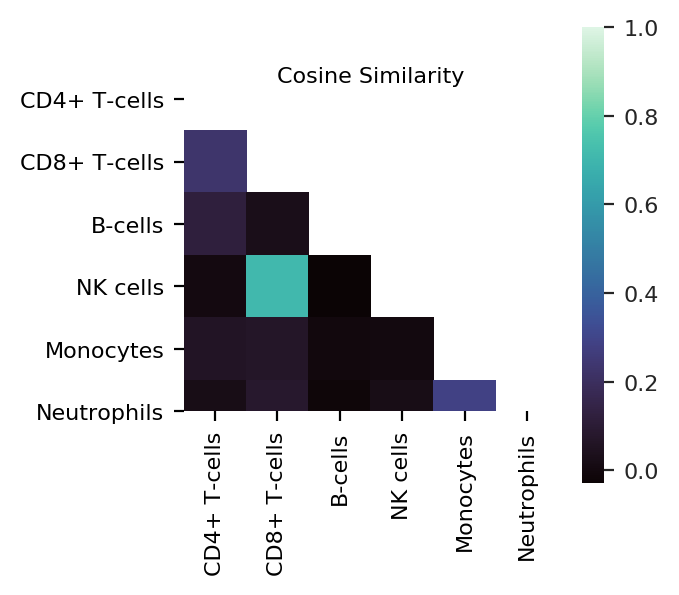

In [159]:
#best = np.array(hof[0])
#best_MN = np.array(hof_MN[40])
#best_CD = np.array(hof_CD[0])
centroid = centroids_blood_hv[ag.pareto[len(ag.pareto)-1]]
centroid_CD = centroids_blood_hv[ag_CD.pareto[len(ag_CD.pareto)-1]]
centroid_MN = centroids_blood_hv[ag_MN.pareto[len(ag_MN.pareto)-10]] 
common = [x for x in centroids_blood_hv.index if x in centroid.index or x in centroid_CD.index]
centroid_H = centroids_blood_hv.loc[common,:]
corr = pd.DataFrame(data = np.corrcoef(centroid_H.T), columns = centroid_H.columns, index = centroid_H.columns)
#print(np.abs(corr))
interCorr = 0
for x in corr.index:
    for y in corr.columns:
        if (x!=y):
            interCorr = interCorr + abs(corr.loc[x,y])
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = plt.axes()
ax.set_title('Cosine Similarity')
with sns.axes_style("white"):
    sns_plot = sns.heatmap(corr, 
            xticklabels=corr.columns,mask=mask,cmap=sns.color_palette("mako", 1000),square=True)
sns_plot.figure.savefig(results_file+"corr_4k_GA_H.png",dpi=300, bbox_inches='tight')
print(interCorr) #3.3529308719057256

In [160]:
#centroid.to_csv("./good_signatures/pbmc/400p150(4k_100)_paper_sc_bulk_test.csv")

1925.9547157287598


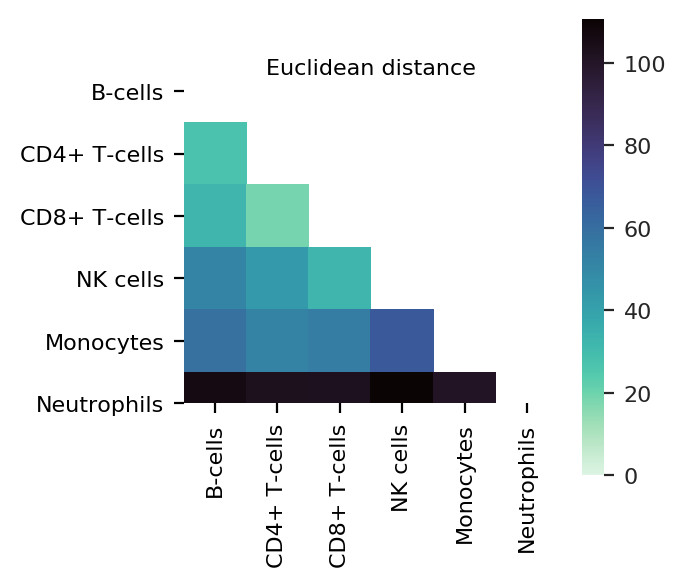

In [274]:
 distance_ = 0
from scipy.spatial import distance
dist = pd.DataFrame(columns = centroid_H.columns, index = centroid_H.columns)
for x in centroid_H.columns:
    for y in centroid_H.columns:
        dist.loc[x,y] = distance.euclidean(centroid_H[x],centroid_H[y])
        if (x!=y):
            distance_ = distance_ + distance.euclidean(centroid_H[x],centroid_H[y])
ax = plt.axes()
ax.set_title('Euclidean distance')
print(distance_)
dist = dist.astype(float)
mask = np.zeros_like(dist)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot = sns.heatmap(dist,
            xticklabels=dist.index,
            yticklabels=dist.index,mask=mask,cmap=sns.color_palette("mako_r", 1000),square=True)
sns_plot.figure.savefig(results_file+"dist_4k_GA_H.png",dpi=300, bbox_inches='tight')
dist.to_csv(figdir+'dist.csv',sep='\t')

In [181]:
signatures_cell19 = pd.read_csv(bulks_dir+'sigRNA.txt', index_col=0, delimiter = '\t')
signatures_cell19.shape

(1296, 17)

In [182]:
#samples_proc_cell19 = data2.loc[signatures_cell19.index,:].dropna()
#sorted_bulks_selection_cell19 = sorted_bulks_selection_cell19.loc[samples_proc_cell19.index,:].dropna()
centroid_cell19 = centroids_blood_hv.loc[signatures_cell19.index,:].dropna()
centroid_cell19.shape

/usr/lib64/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(199, 6)

# Regression

In [183]:
def deconvolution(indices,samples,sorted_bulks_selection,centroids_sc_blood,figDir,method):
    samples_proc = samples.loc[indices,:].dropna().copy()
    sorted_bulks_selection_proc = sorted_bulks_selection.loc[samples_proc.index,:].dropna().copy()
    centroid_proc = centroids_sc_blood.loc[samples_proc.index,:].dropna().copy()
    rs = []
    ps=[]
    print(samples_proc.shape)
    proportions_NuSVR = pd.DataFrame(columns=centroid_proc.columns)
    regr_NuSVR = NuSVR(nu=0.5,C=0.5,kernel='linear') 
    for column in samples_proc.columns:
        regr_NuSVR.fit(centroid_proc, samples_proc.loc[:,column])
        proportions_NuSVR.loc[column] = regr_NuSVR.coef_[0]
    
    proportions_NuSVR.index = [x[:4] for x in proportions_NuSVR.index]
    proportions_NuSVR = proportions_NuSVR.loc[fractions_selection.index,fractions_selection.columns]
    
    normalized_proportions = normalize_proportions(proportions_NuSVR, copy = False)
    
    for cluster in normalized_proportions.columns:
        r,p = plot_1(normalized_fractions[cluster],normalized_proportions[cluster],cluster,figDir+'_'+cluster+'_'+method+'.png')
        rs+=[round(r, 2)] 
        ps+=[round(p, 2)] 
    return normalized_proportions,rs,ps

In [57]:
samples_test = samples.copy()
samples_test.index = samples_test.index.str[:-2]

In [58]:
annotations = pd.read_csv(bulks_dir+'annotations.txt', index_col=0, delimiter = '\t')
sorted_bulks_selection_proc = sorted_bulks_selection.loc[annotations.index].copy()
samples_proc = samples.loc[np.intersect1d(annotations.index,samples.index)].copy() #samples_test

In [63]:
samples_proc.index = annotations.loc[np.intersect1d(annotations.index,samples_proc.index),'Gene Symbol']
sorted_bulks_selection_proc.index = annotations.loc[:,'Gene Symbol']

In [68]:
samples_proc = samples_proc.groupby(samples_proc.index).sum()

In [74]:
samples_proc.to_csv('bulk_symbol.csv',sep='\t')

In [72]:
len(np.intersect1d(samples_proc.index,blood_control_norm.var_names))

11757

In [67]:
samples_proc.index.str.upper()

Index(['5S_RRNA', '5_8S_RRNA', '7SK', 'A1BG-AS1', 'A2M-AS1', 'A2ML1-AS1',
       'A2ML1-AS2', 'A2MP1', 'A3GALT2', 'A4GNT',
       ...
       'SNOU2-30', 'SNOU2_19', 'SNOU83B', 'SNOZ196', 'SNOZ278', 'SNOZ40',
       'SNOZ6', 'SNOSNR66', 'UC_338', 'YR211F11.2'],
      dtype='object', name='Gene Symbol', length=43764)

In [26]:
samples_proc = samples_proc.loc[blood_control_norm.var_names,:].dropna()
sorted_bulks_selection_proc = sorted_bulks_selection_proc.loc[blood_control_norm.var_names,:].dropna()

NameError: name 'blood_control_norm' is not defined

In [187]:
fractions_raw_normalize = normalize_proportions(fractions_raw, copy = False)

In [188]:
fractions_raw.columns

Index(['T CD8 Naive', 'T CD8 CM', 'T CD8 EM', 'T CD8 TE', 'MAIT', 'T gd Vd2',
       'T gd non-Vd2', 'Tfh', 'Tregs', 'Th1', 'Th1/Th17', 'Th17', 'Th2',
       'T CD4 Naive', 'T CD4 TE', 'Progenitors', 'B Naive', 'B NSM', 'B Ex',
       'B SM', 'Plasmablasts', 'Monocytes C', 'Monocytes I', 'Monocytes NC',
       'NK', 'pDCs', 'mDCs', 'Neutrophils LD', 'Basophils LD'],
      dtype='object')

In [189]:
fractions_selection = pd.DataFrame(index = fractions_raw.index)
fractions_selection['CD4+ T-cells'] = fractions_raw_normalize.loc[:,['T CD4 Naive','Tregs','Tfh', 'Th1', 'Th1/Th17', 'Th17','Th2', 'T CD4 TE','MAIT']].sum(axis=1)
fractions_selection['CD8+ T-cells'] = fractions_raw_normalize.loc[:,['T CD8 Naive','T CD8 CM','T CD8 EM','T CD8 TE','T gd Vd2','T gd non-Vd2']].sum(axis=1)
fractions_selection['B-cells'] = fractions_raw_normalize.loc[:,['B Naive','B NSM','B SM', 'B Ex', 'Plasmablasts']].sum(axis=1)
fractions_selection['NK cells'] = fractions_raw_normalize.loc[:,['NK']].sum(axis=1)
fractions_selection['Monocytes'] = fractions_raw_normalize.loc[:,['Monocytes C', 'Monocytes I', 'Monocytes NC','Basophils LD', 'mDCs','pDCs']].sum(axis=1)
fractions_selection['Neutrophils'] = fractions_raw_normalize.loc[:,['Neutrophils LD']].sum(axis=1)
fractions_selection.columns

Index(['CD4+ T-cells', 'CD8+ T-cells', 'B-cells', 'NK cells', 'Monocytes',
       'Neutrophils'],
      dtype='object')

In [190]:
normalized_fractions = fractions_selection #normalize_proportions(fractions_selection, copy = False)

# GA

In [191]:
figdir = "./write/results/sc_bulk_pbmc/"

(270, 13)


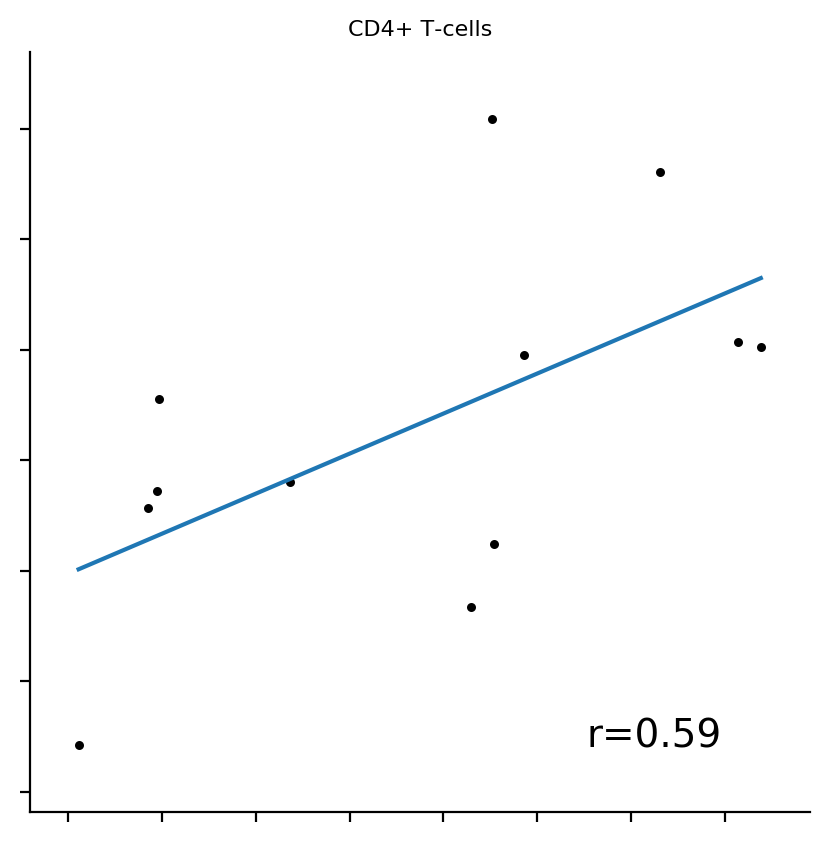

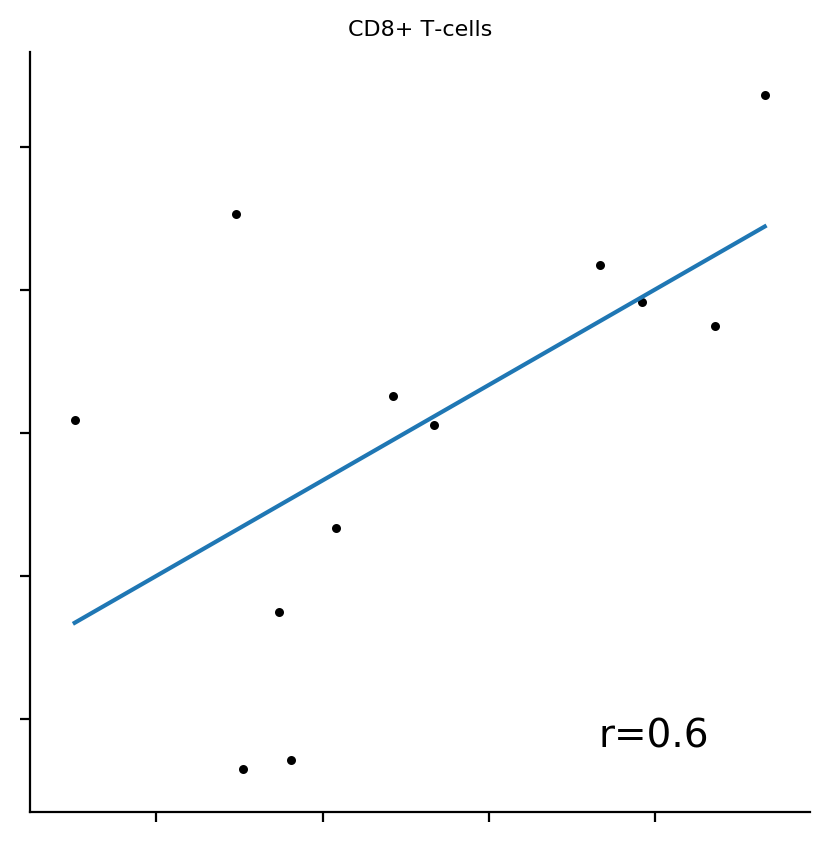

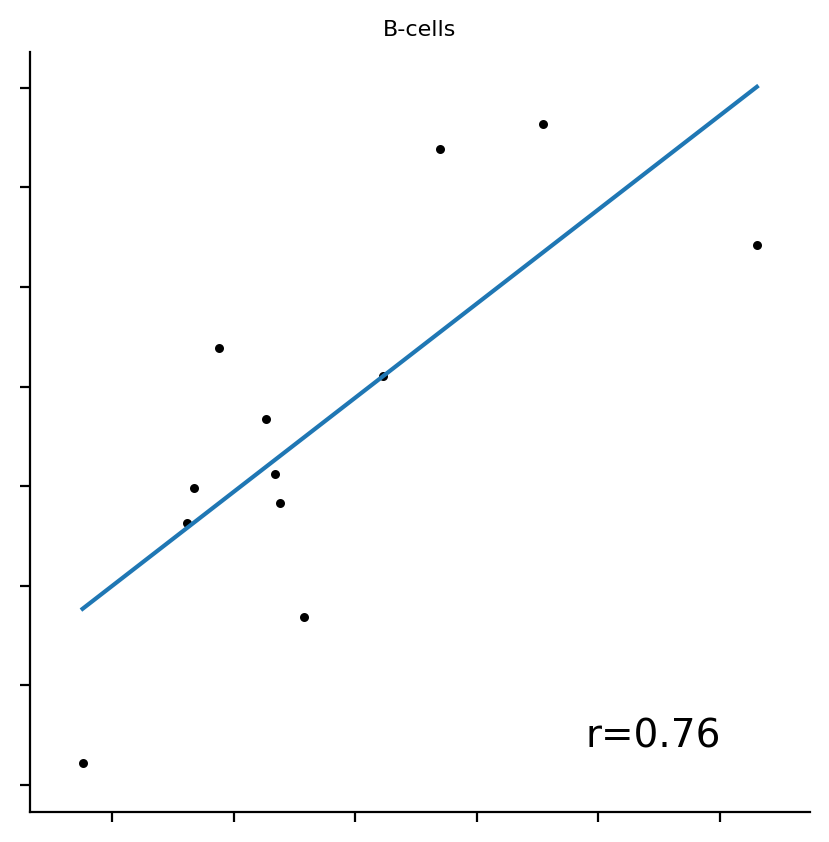

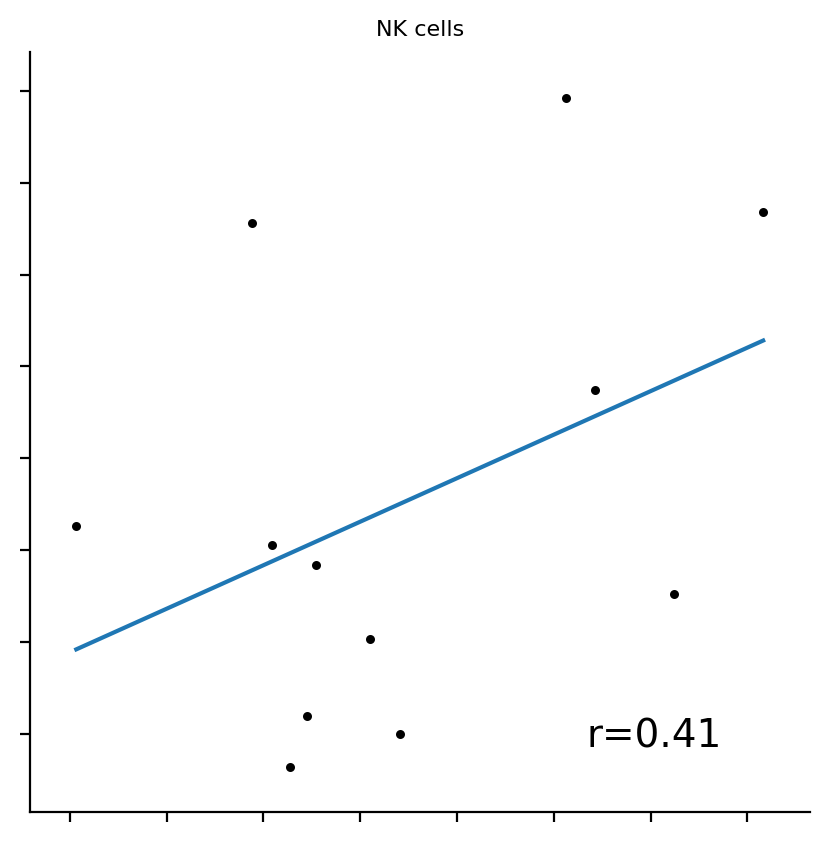

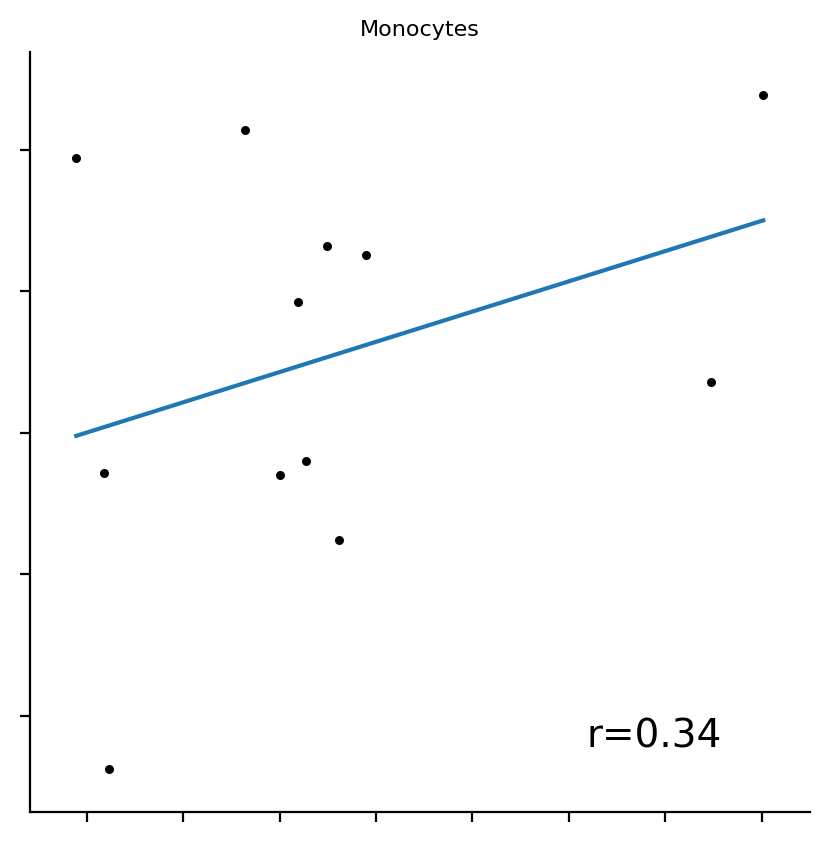

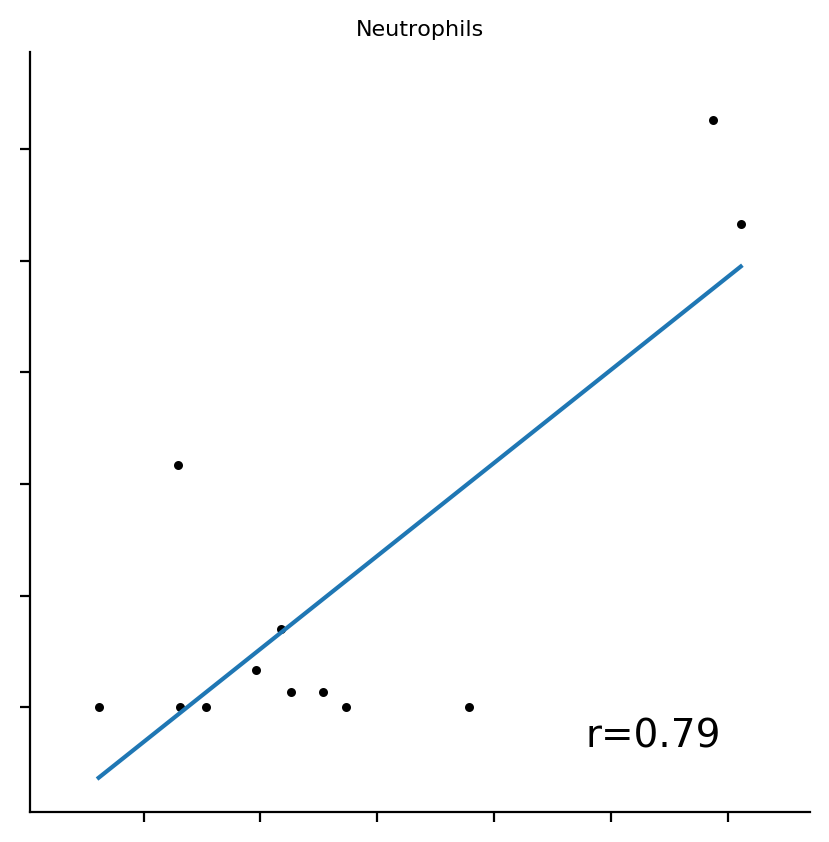

In [192]:
normalized_proportions_GA,r_GA,p_GA = deconvolution(centroid.index,samples_proc,sorted_bulks_selection_proc,centroids_sc_blood,figdir,"autogenes")

/usr/lib64/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(280, 13)


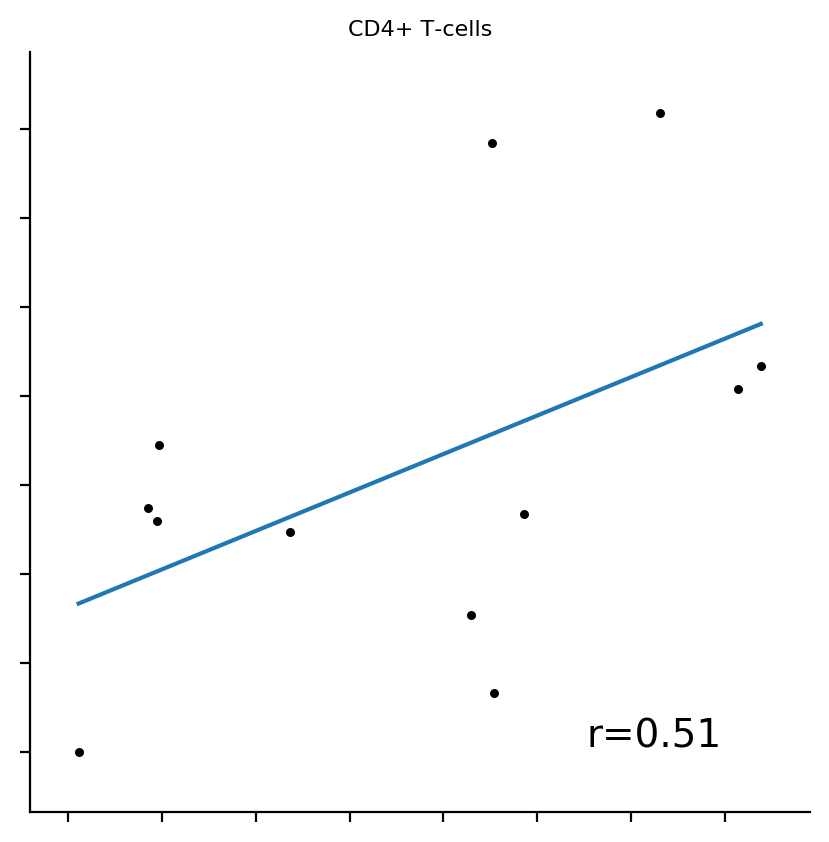

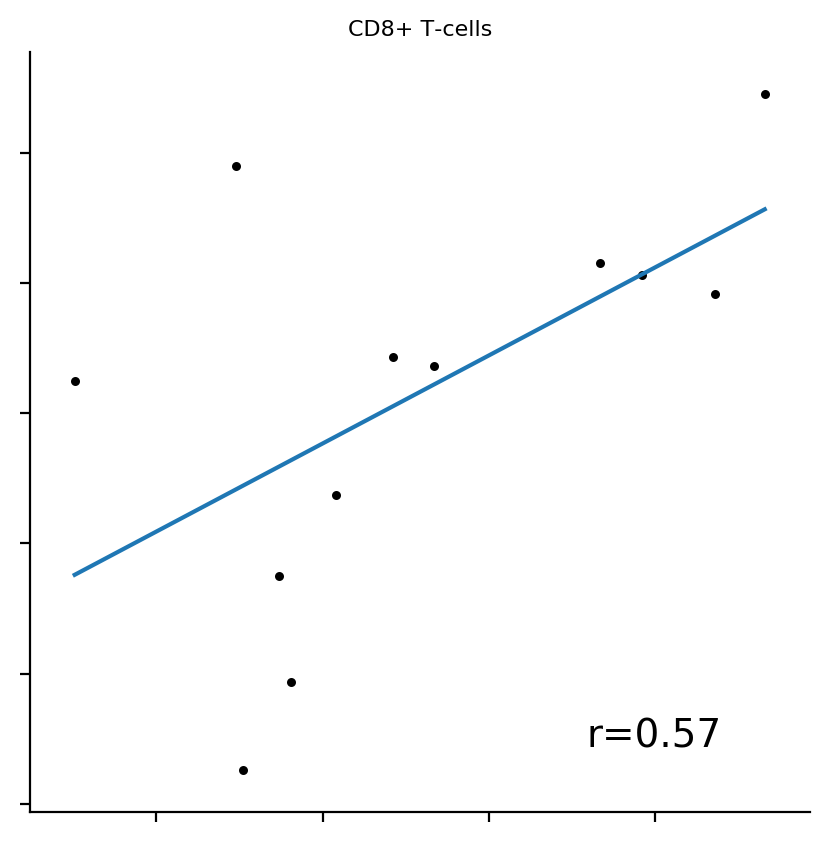

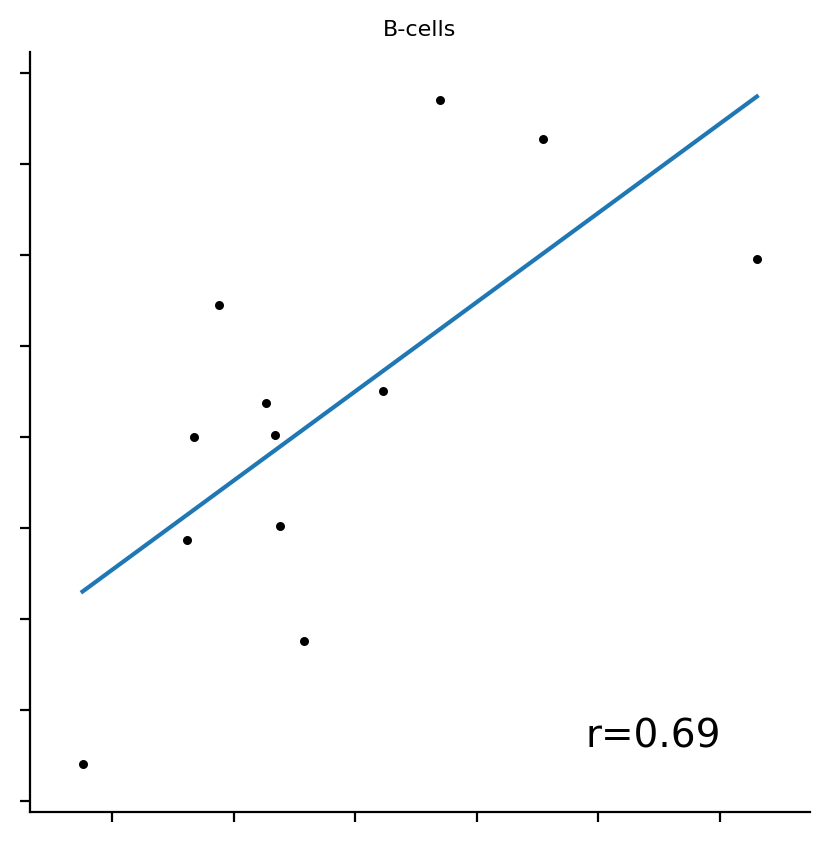

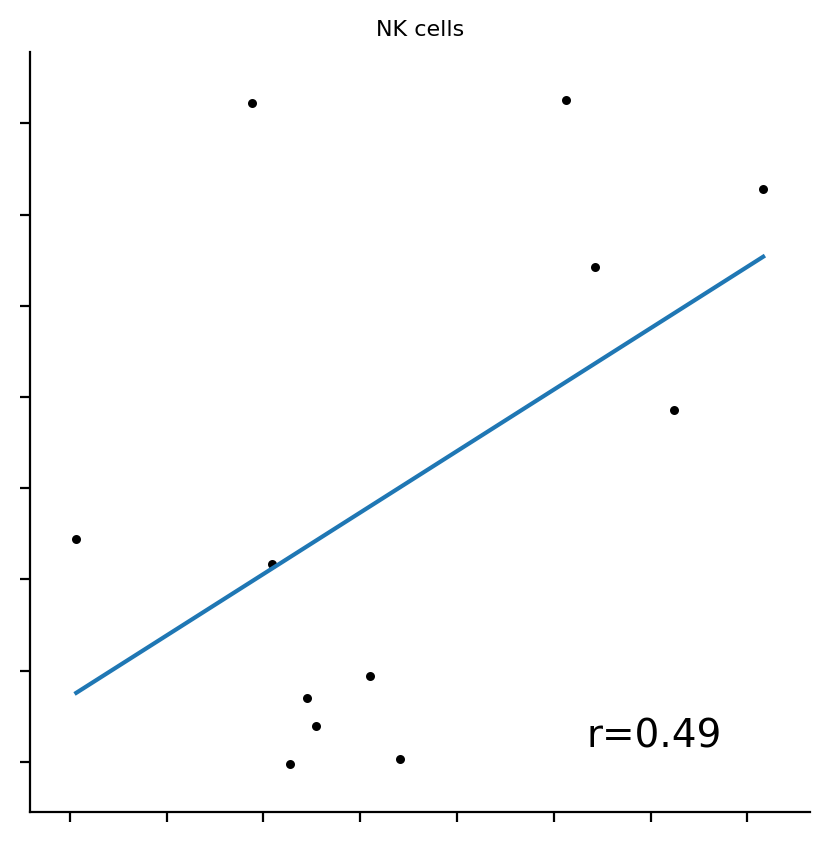

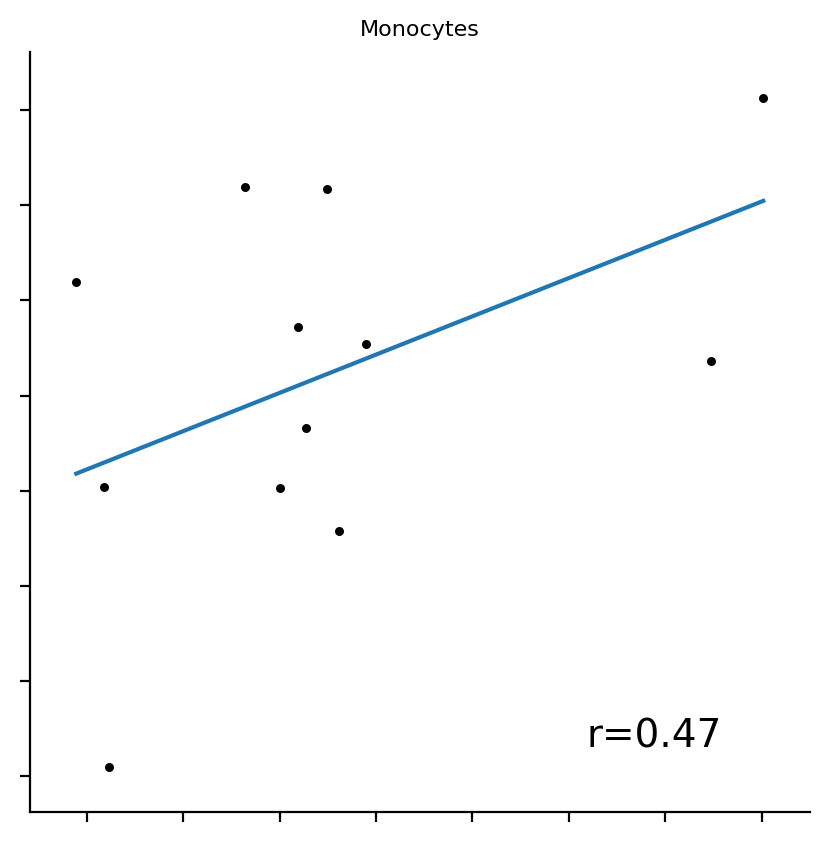

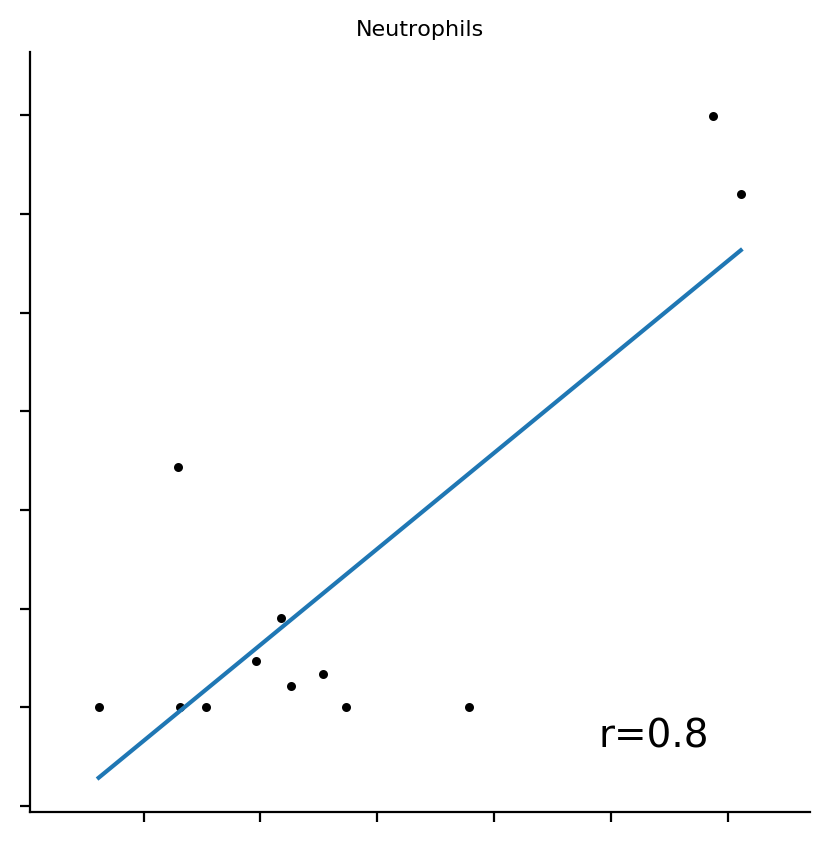

In [193]:
normalized_proportions_GA_H,r_GA_H,p_GA_H = deconvolution(centroid_H.index,samples_proc,sorted_bulks_selection_proc,centroids_sc_blood,figdir,"autogenes")

/usr/lib64/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(345, 13)


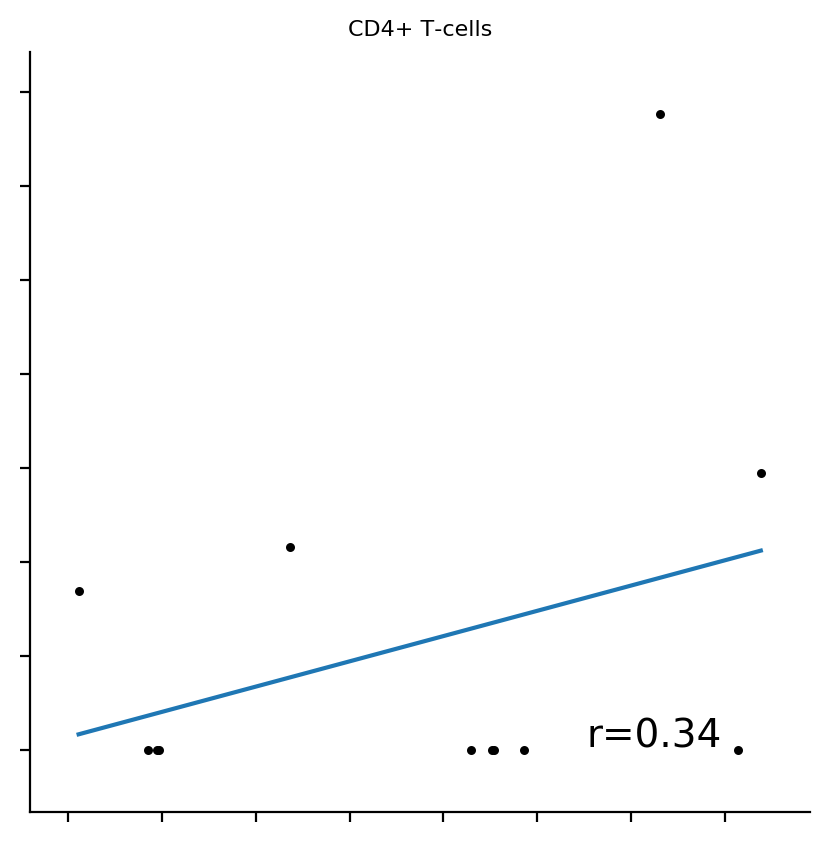

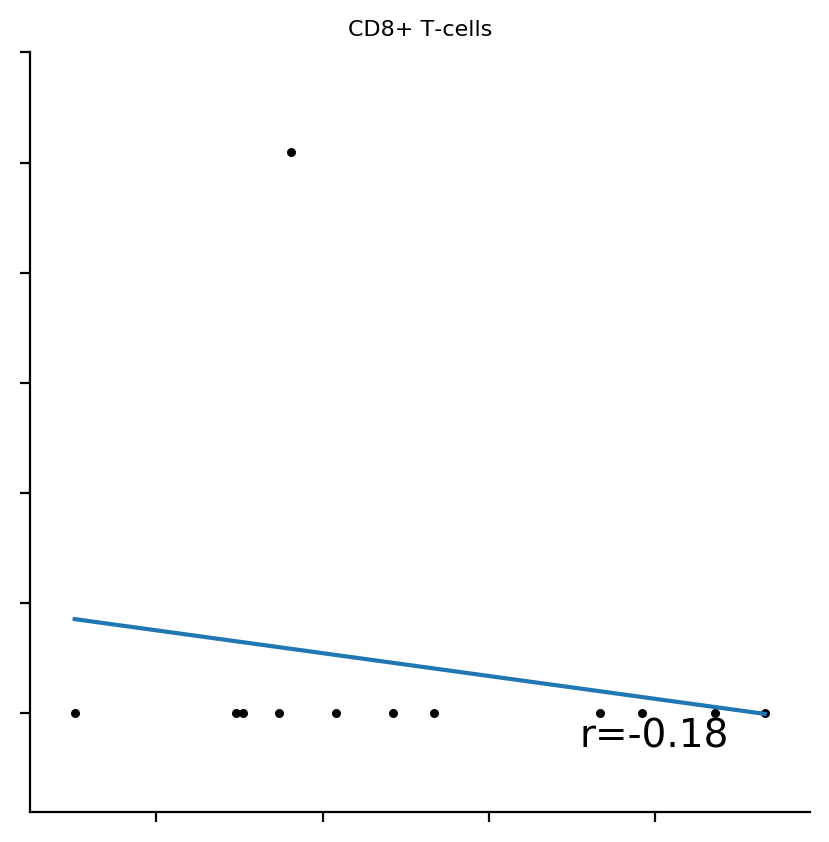

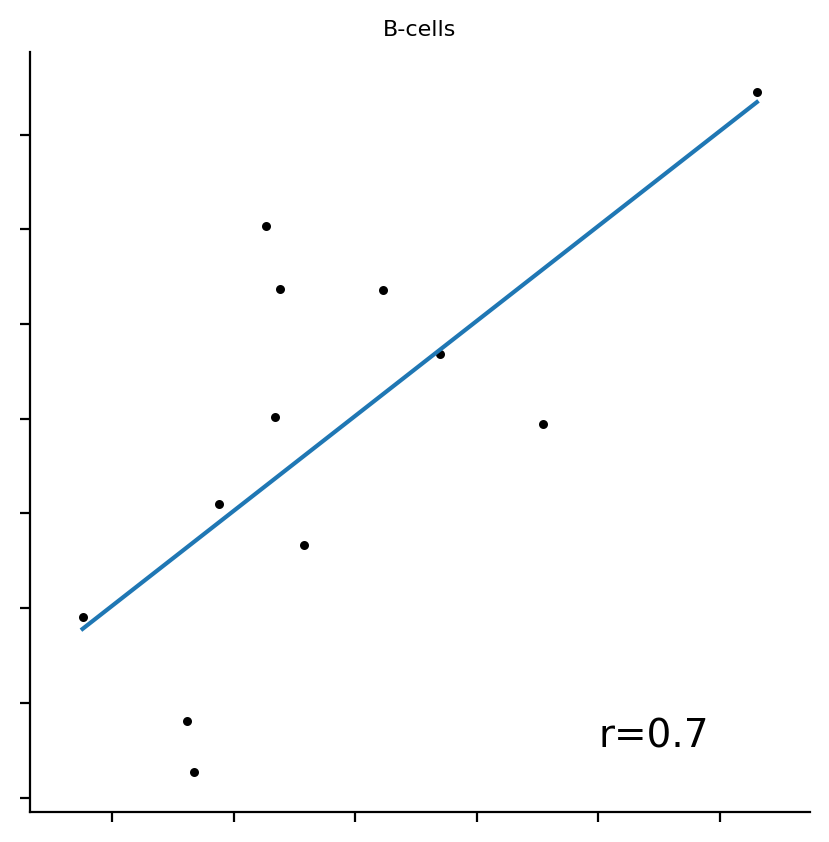

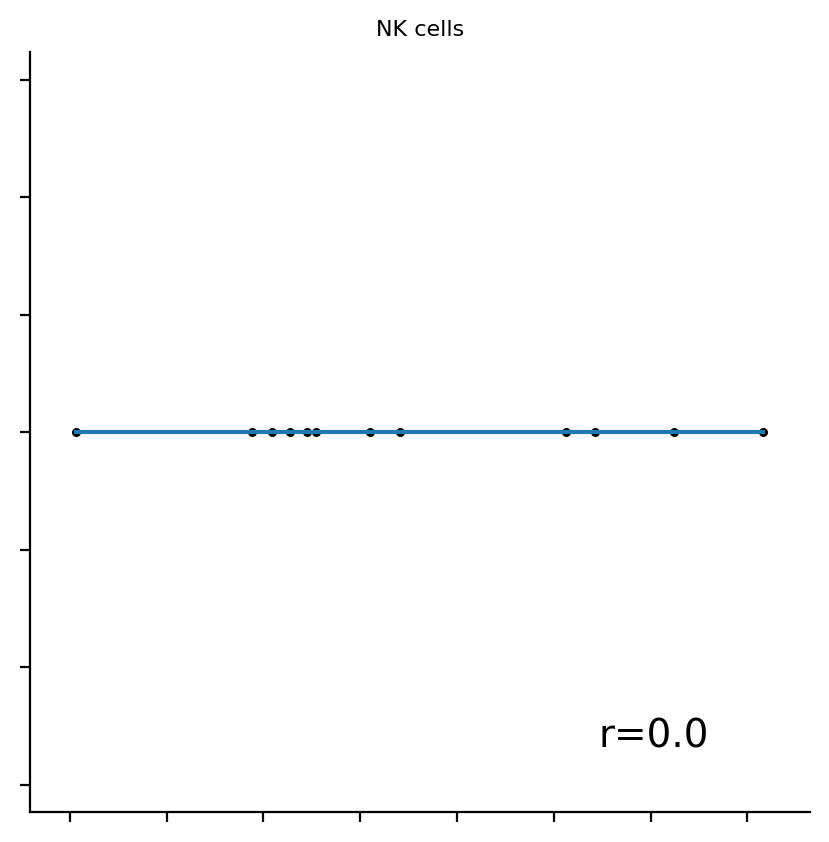

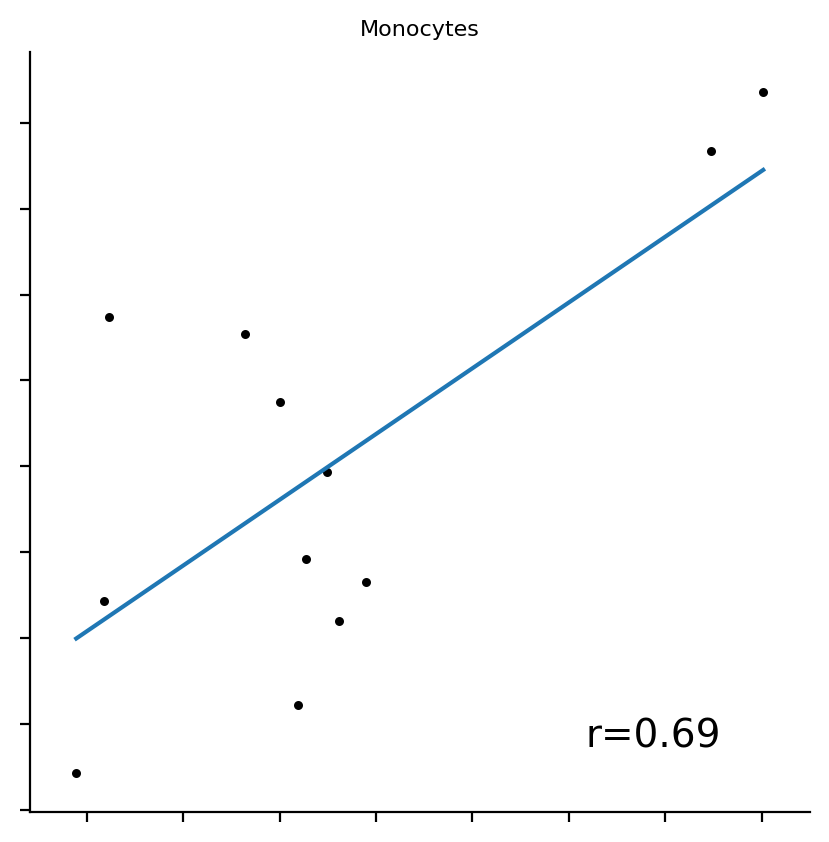

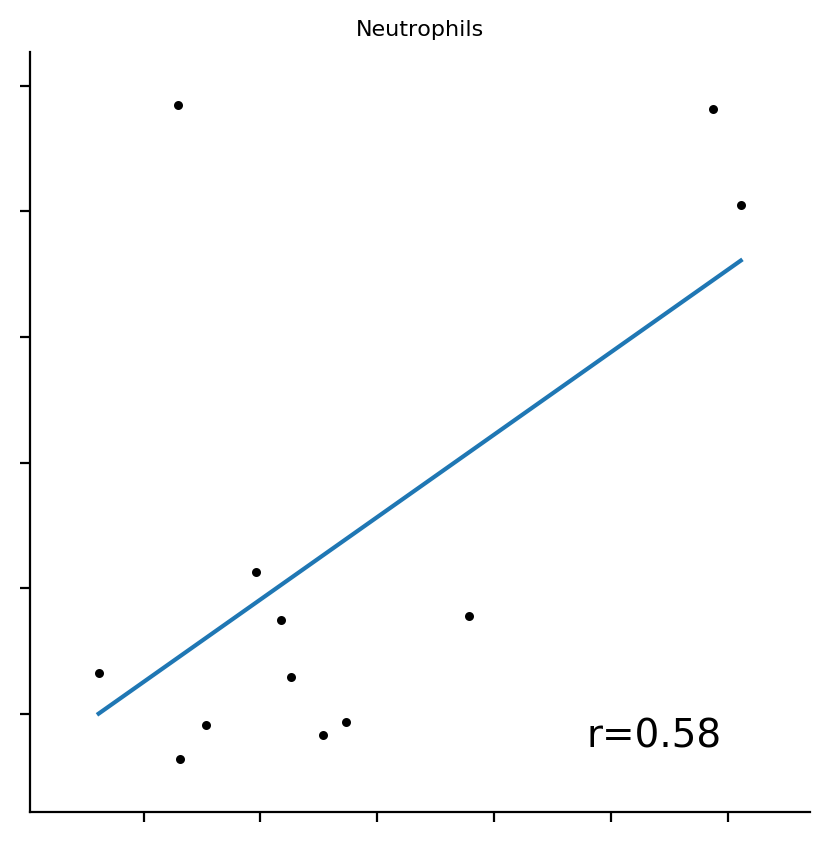

In [194]:
centroid_GA_bulk = pd.read_csv('./write/sorted_bulks_4k_GA_500_paper.csv',index_col=0) #on the whole dataset not hv genes
normalized_proportions_GA_bulk,r_GA_bulk,p_GA_bulk = deconvolution(centroid_GA_bulk.index,samples_proc,sorted_bulks_selection_proc,centroids_sc_blood,figdir,"autogenes")

### Deconvolution kappa

/usr/lib64/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(848, 13)


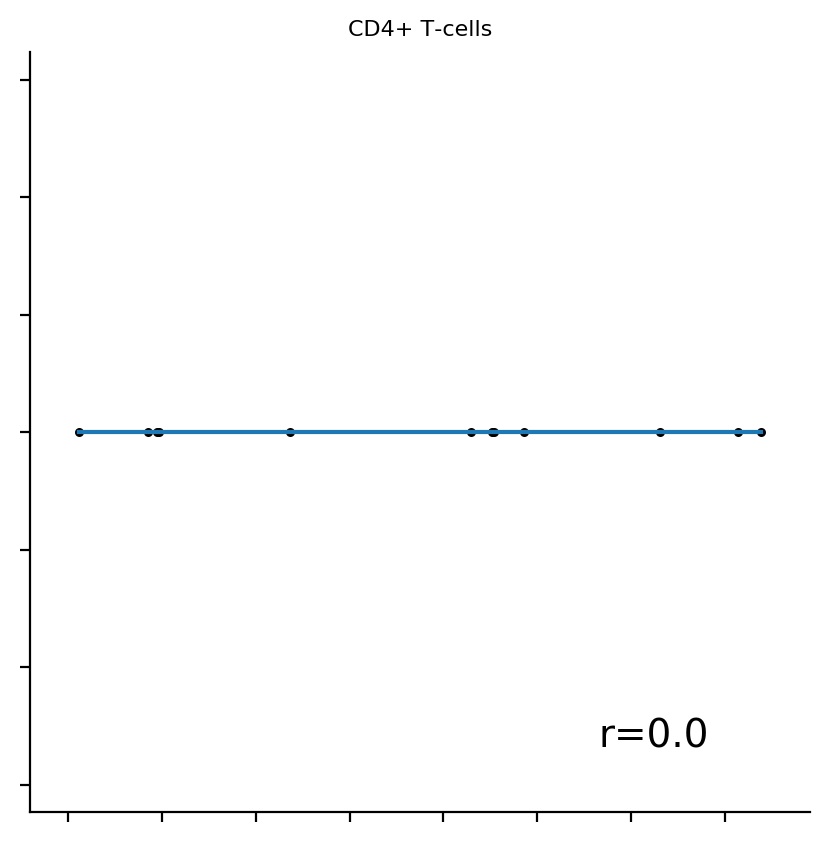

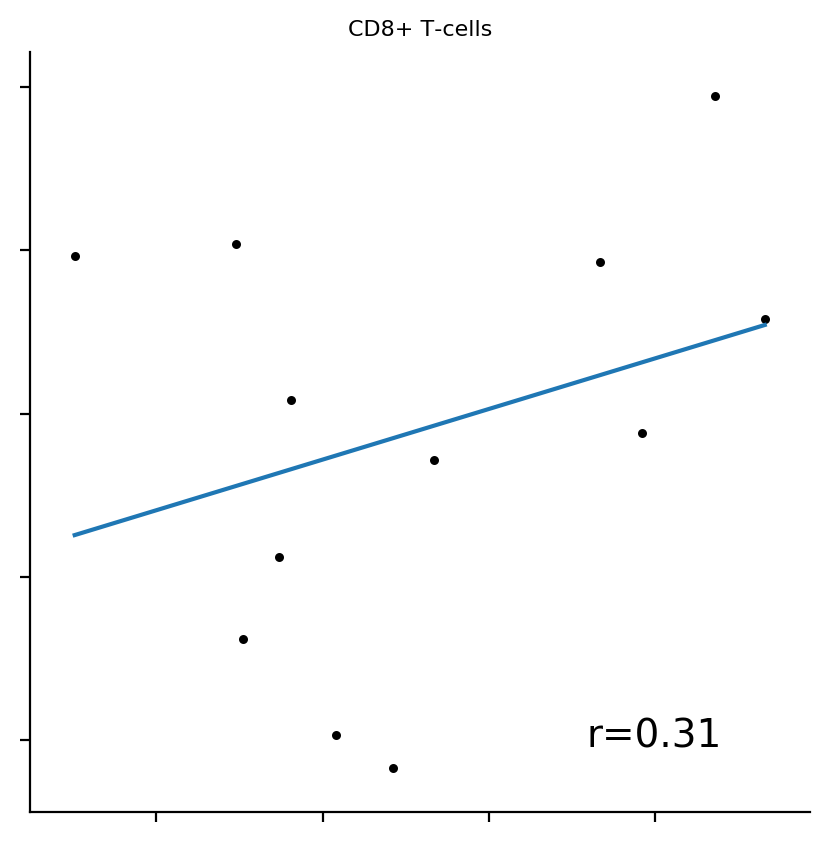

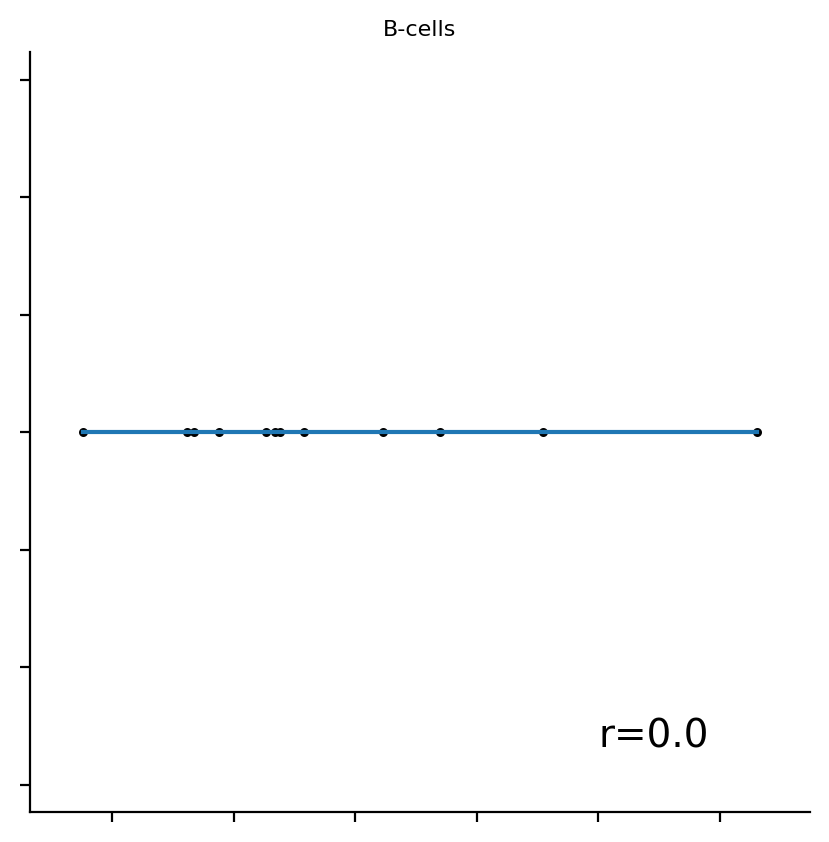

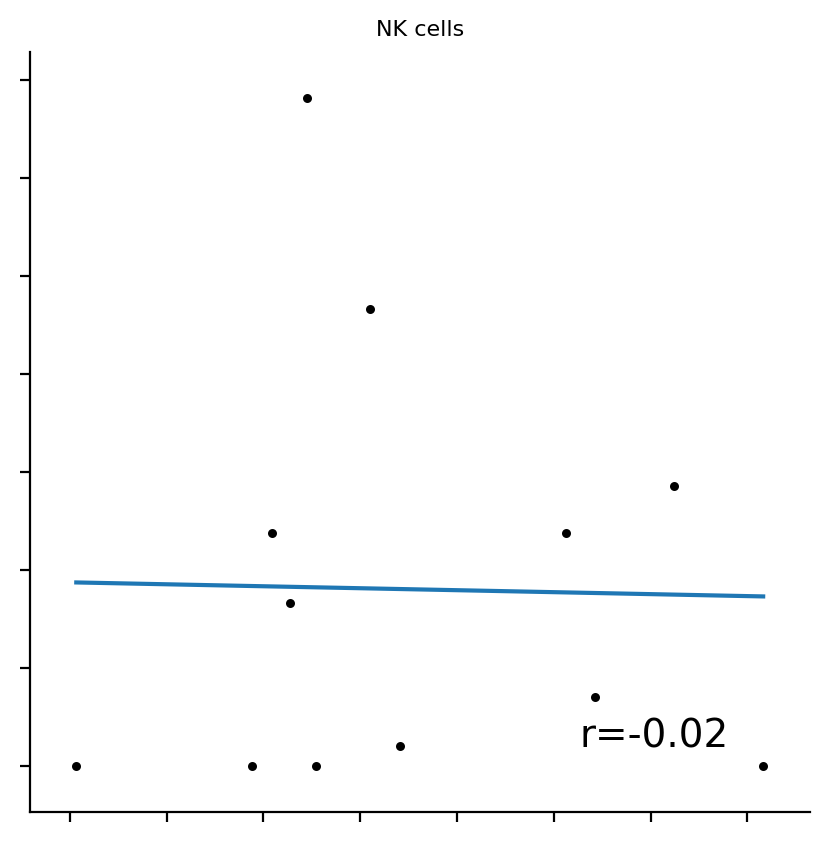

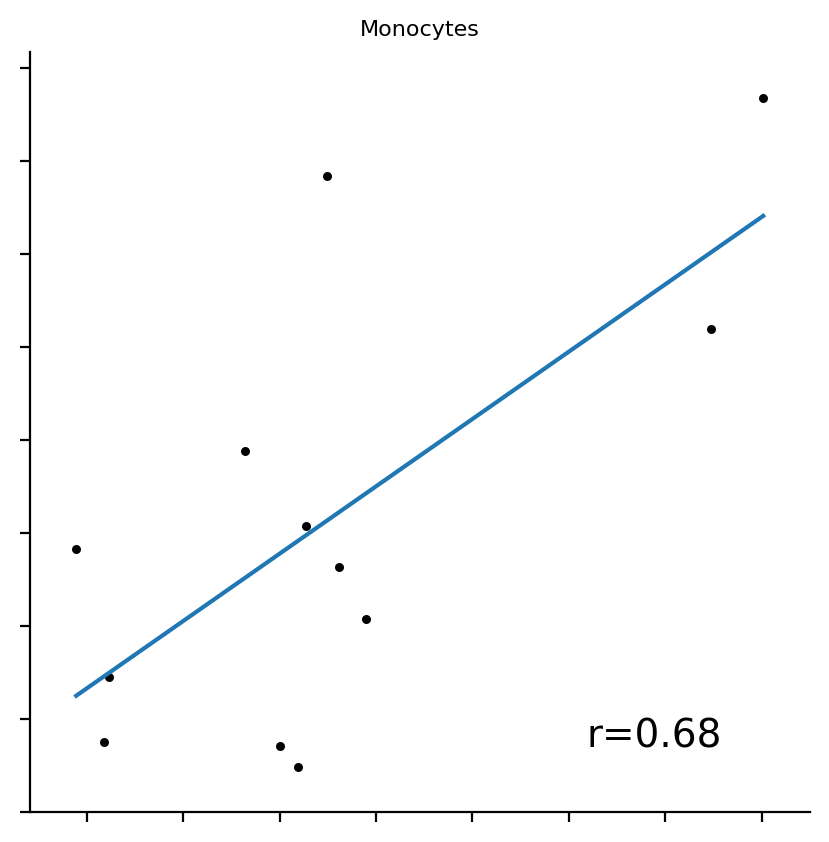

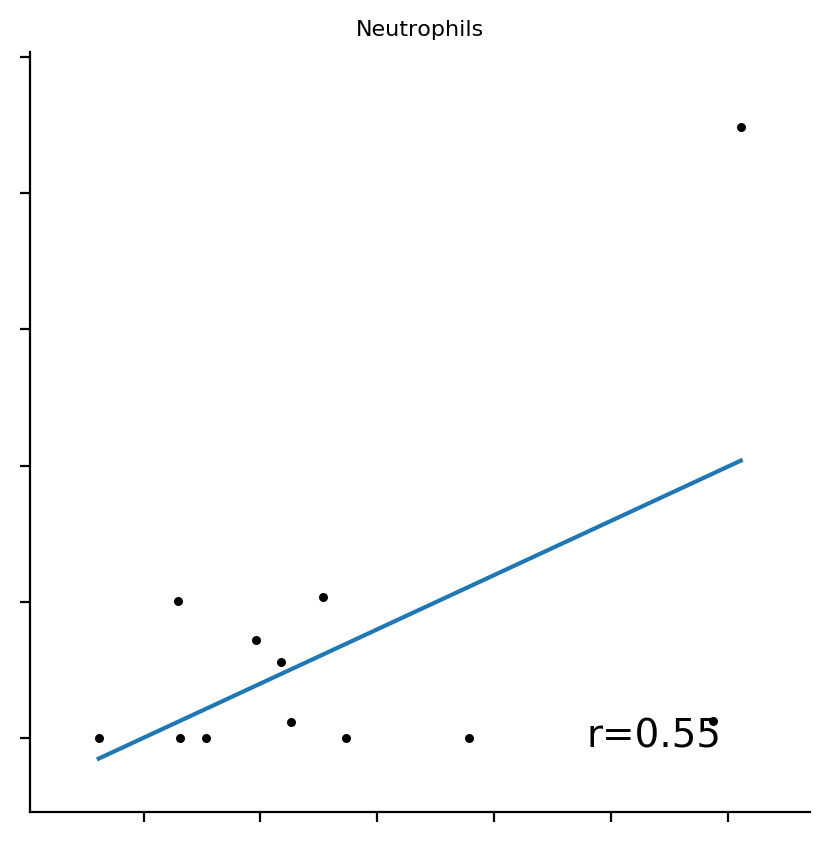

In [268]:
normalized_proportions_ciber,r_ciber,p_ciber = deconvolution(list(mgSet_kappa),samples_proc,sorted_bulks_selection_proc,centroids_sc_blood,figdir,"ciber")

### Deconvolution 500 markers

/usr/lib64/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(483, 13)


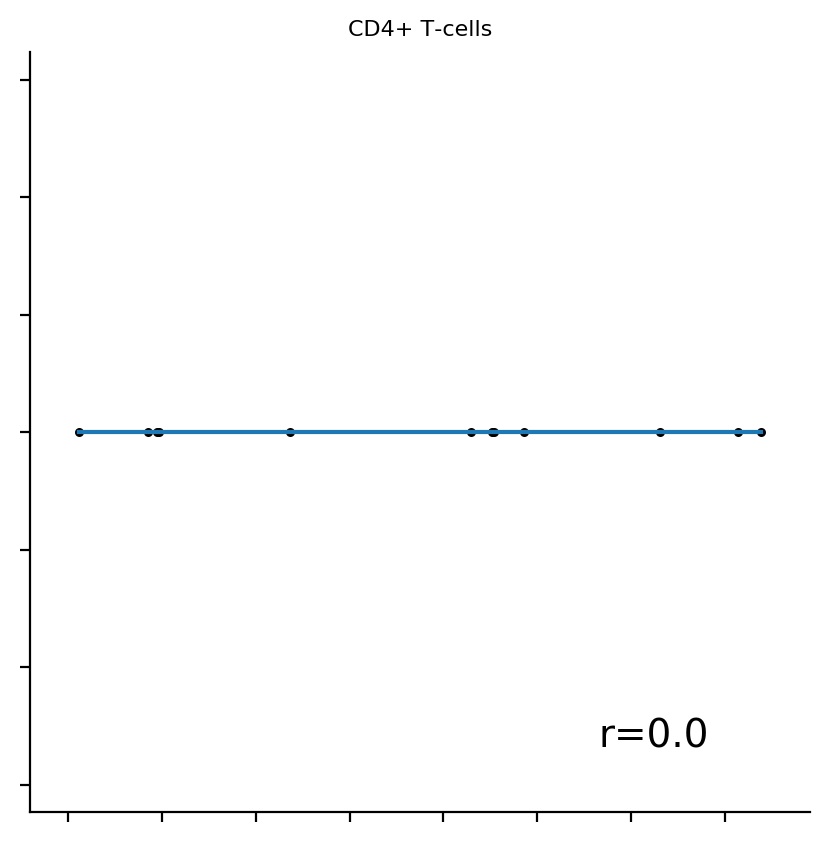

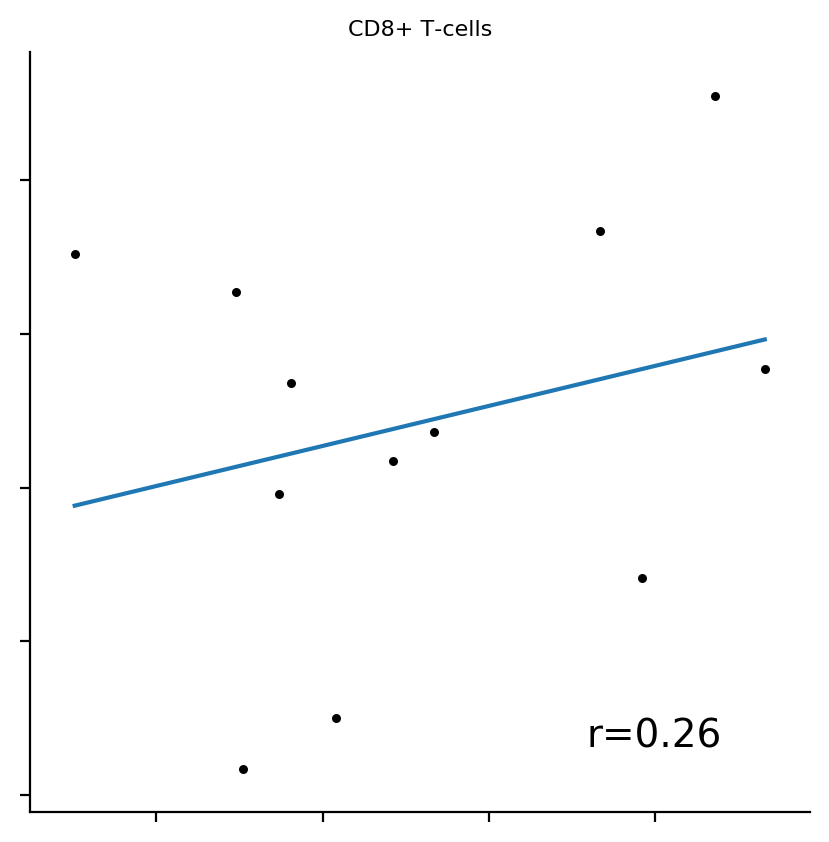

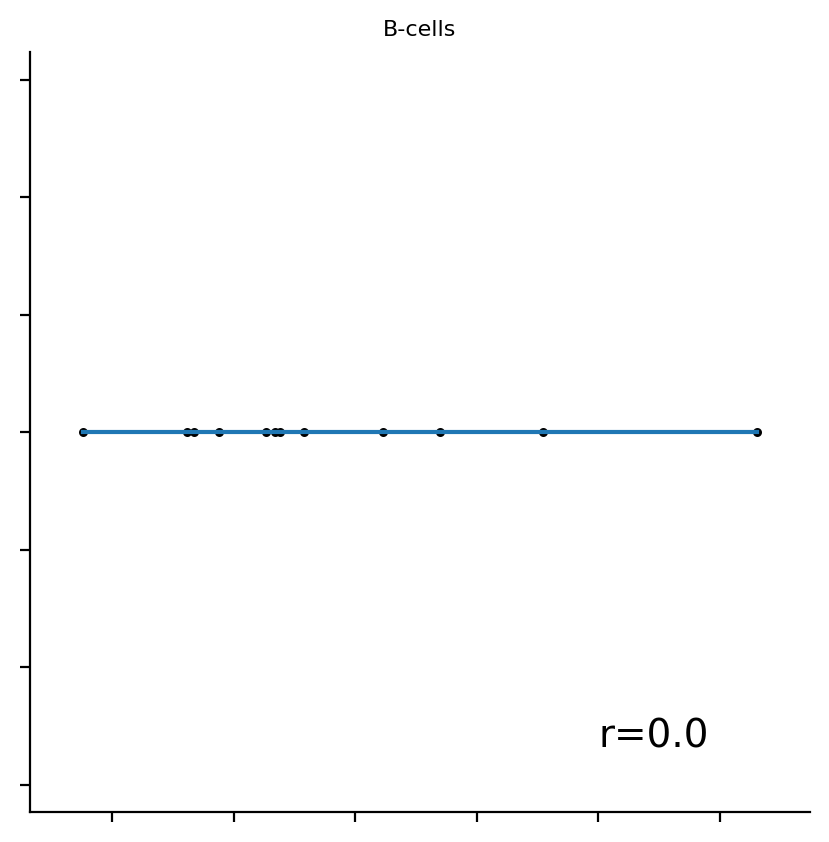

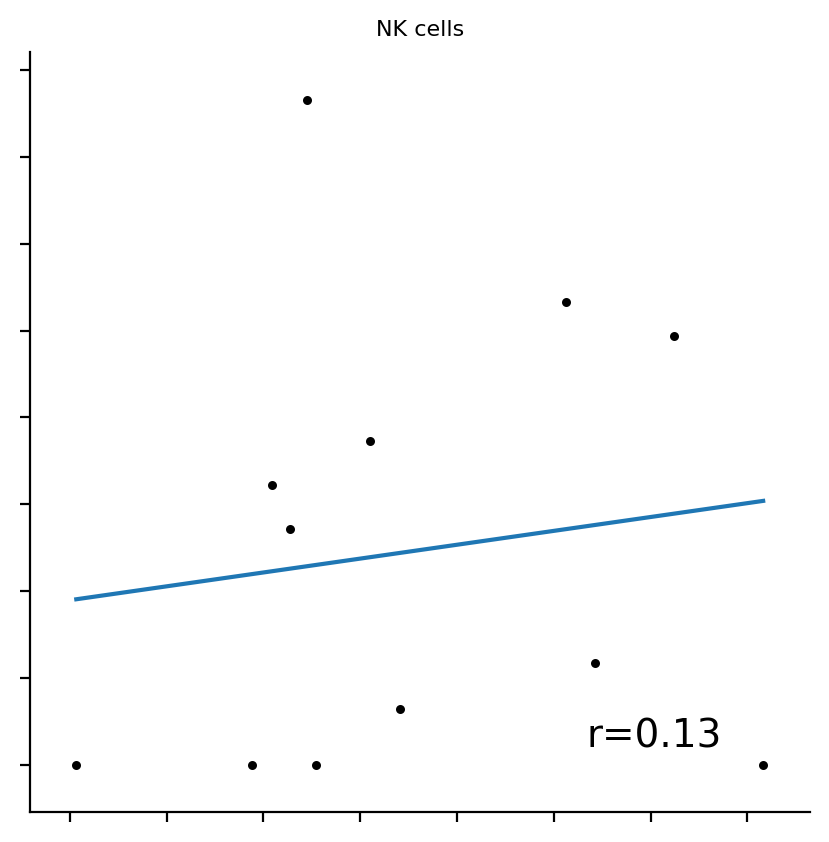

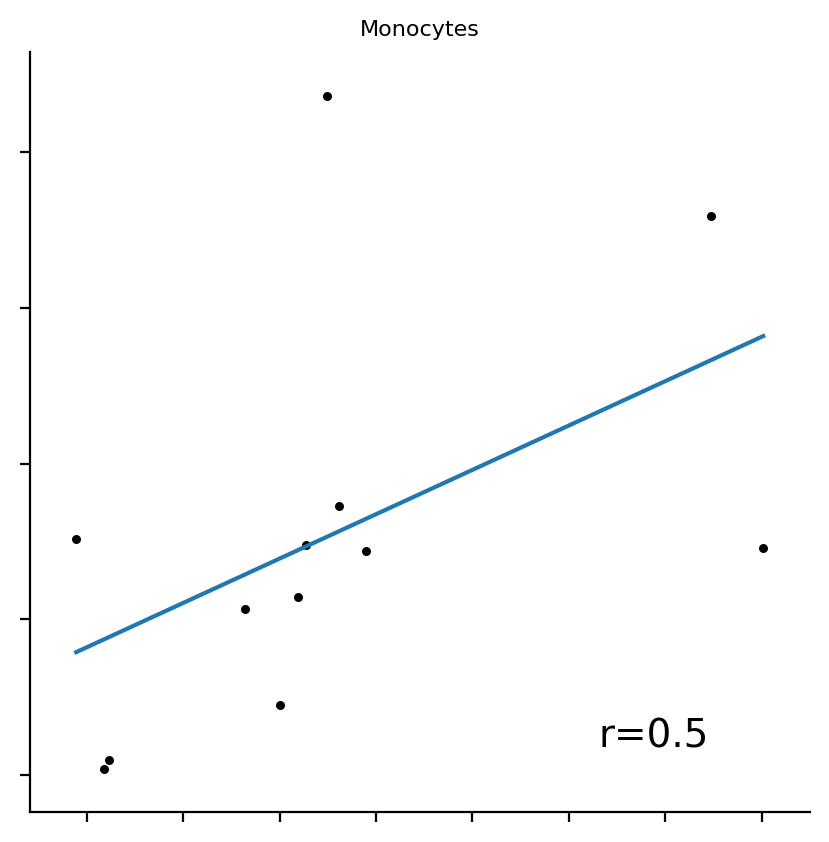

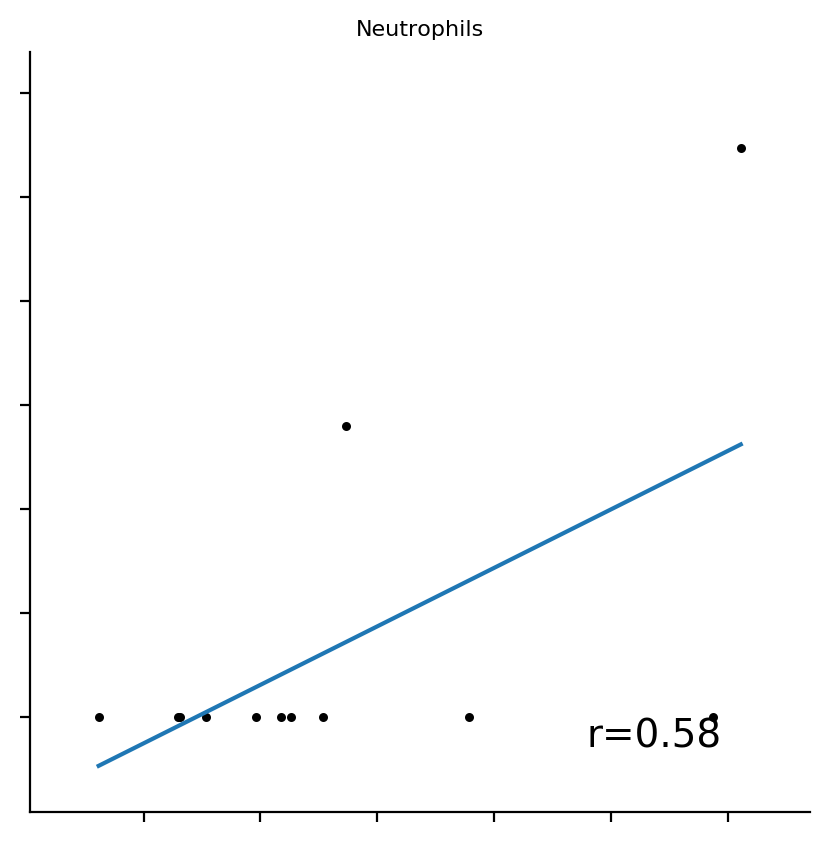

In [266]:
normalized_proportions_marker,r_marker,p_marker = deconvolution(list(mgSet),samples_proc,sorted_bulks_selection_proc,centroids_sc_blood,figdir,"mg")

### Deconvolution using cell'19 genes

(199, 13)


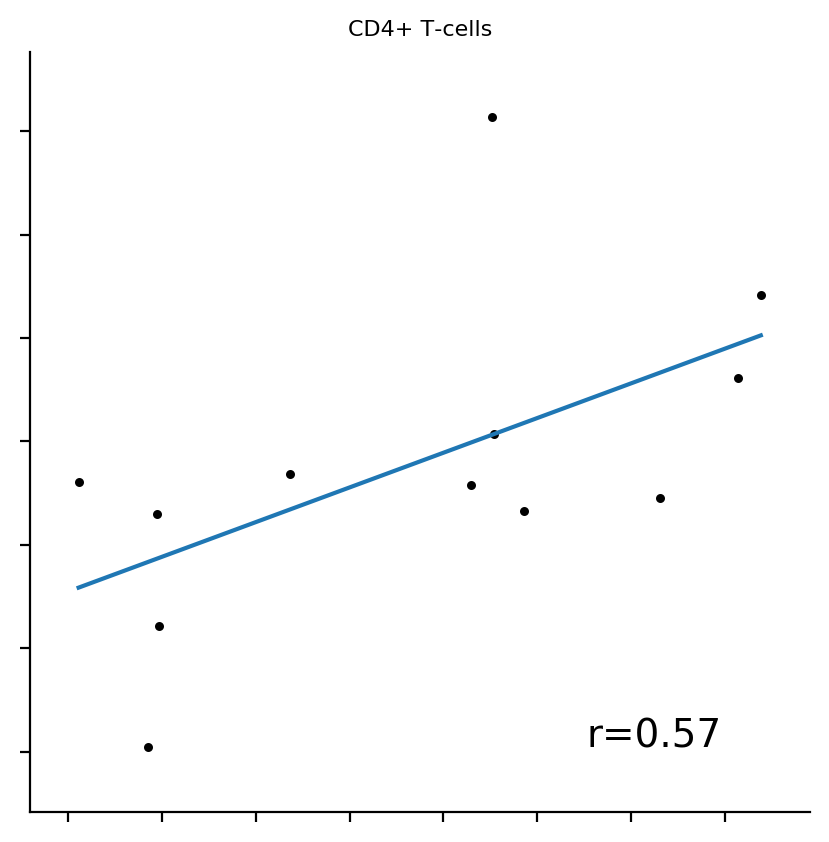

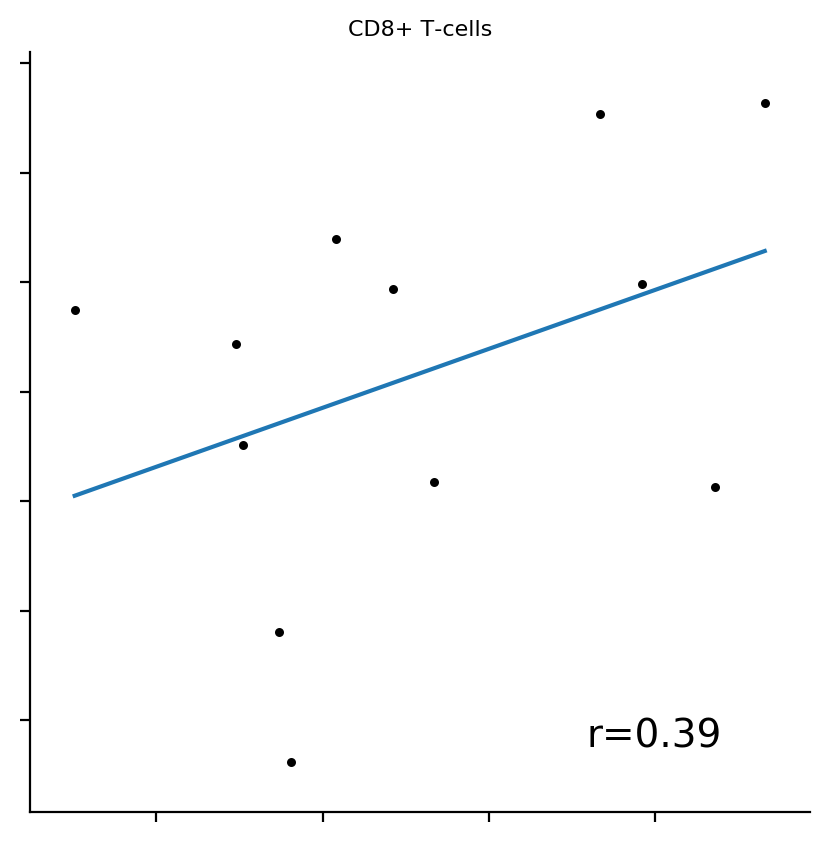

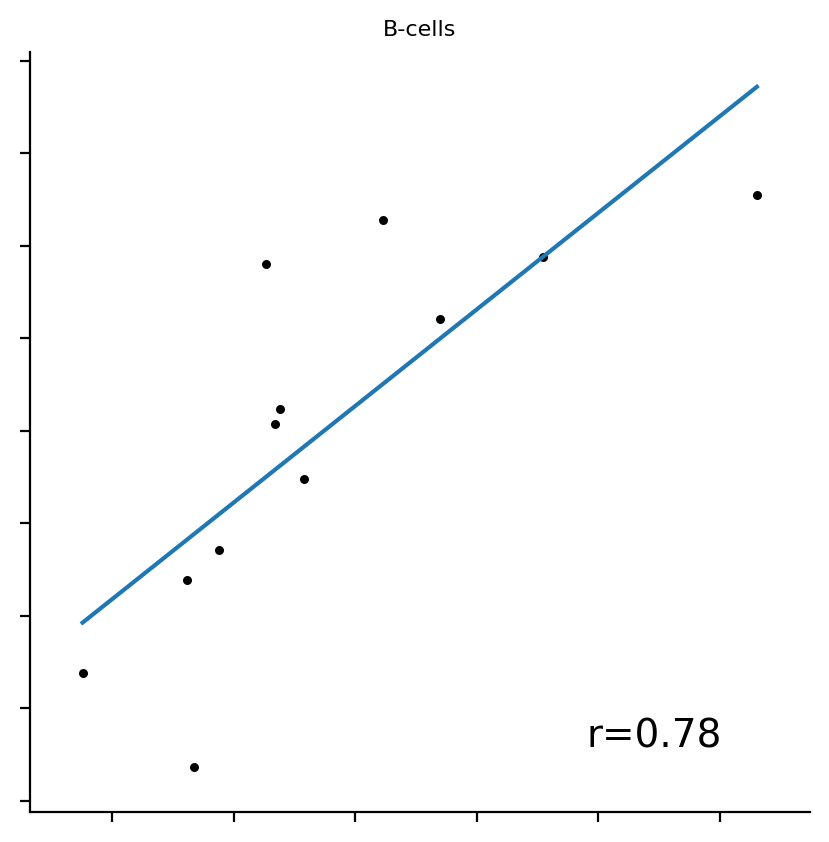

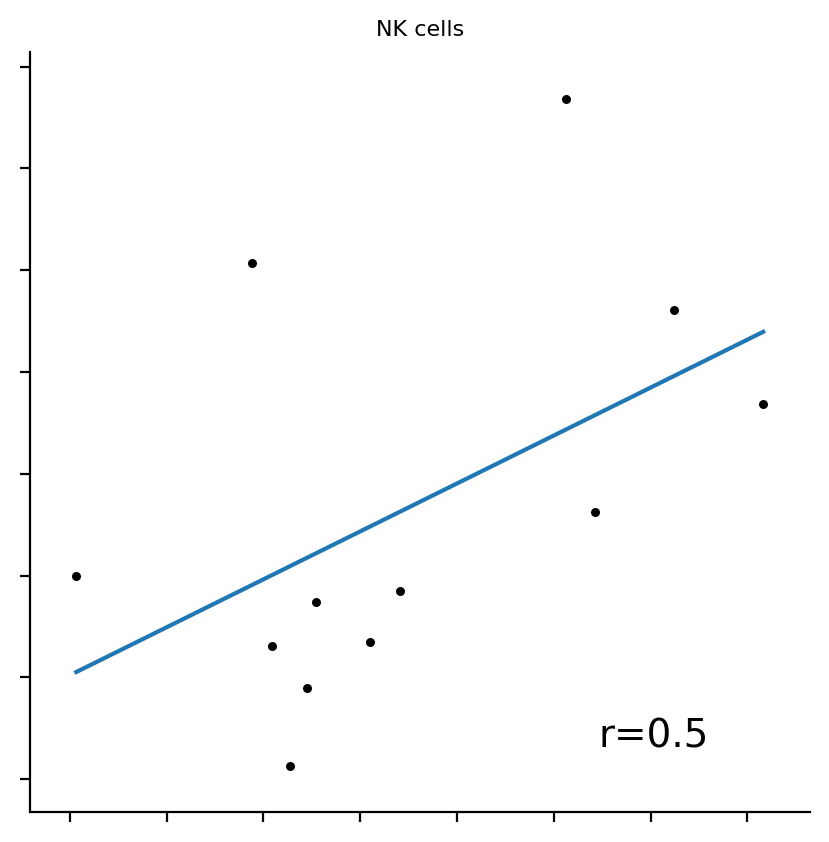

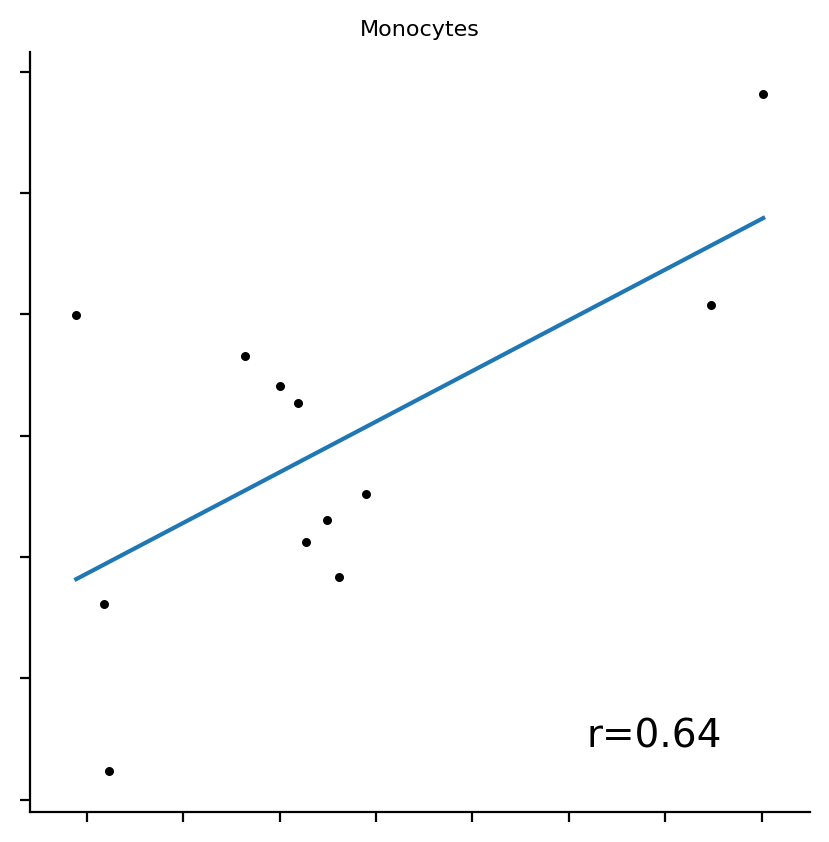

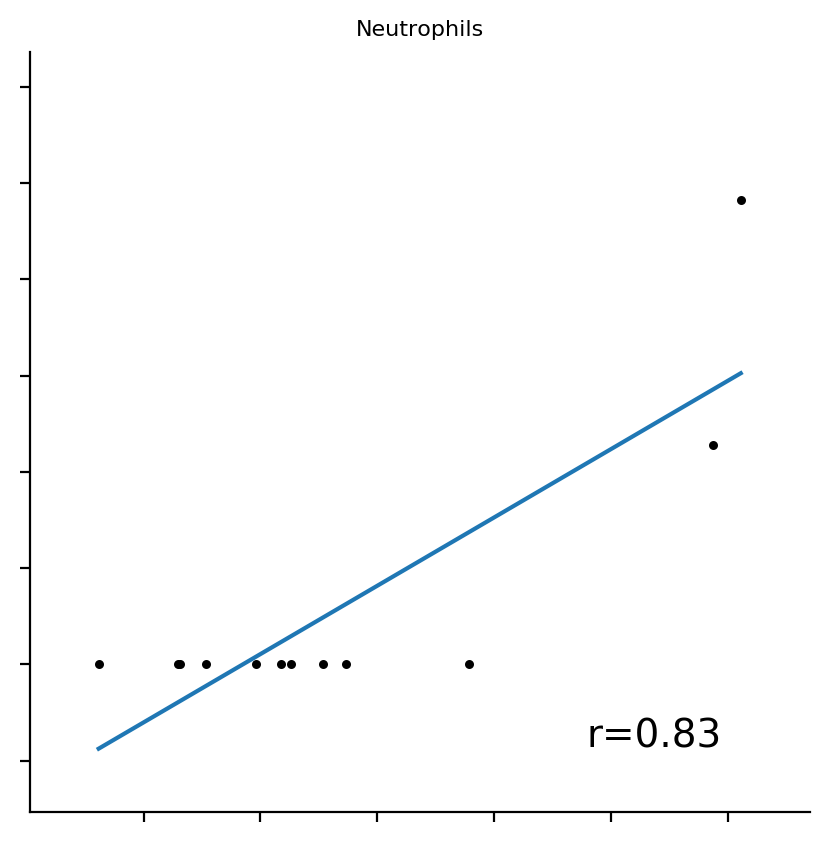

In [250]:
normalized_proportions_cell,r_cell,p_cell = deconvolution(centroid_cell19.index,samples_proc,sorted_bulks_selection_proc,centroids_sc_blood,figdir,"cell19")

### Deconvolution using hv genes

/usr/lib64/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(3527, 13)


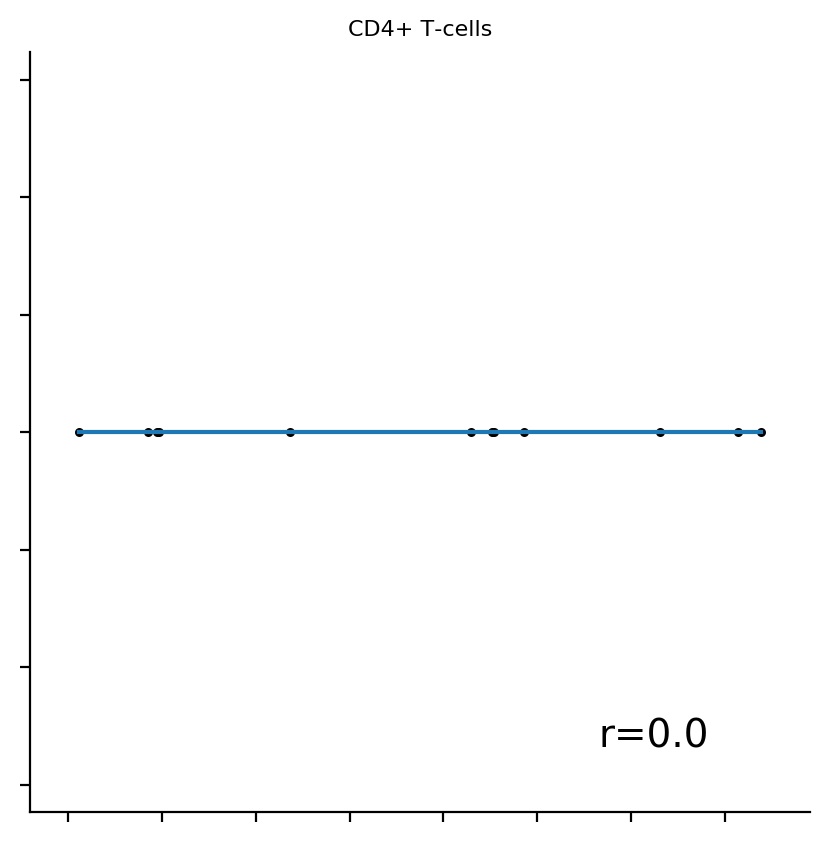

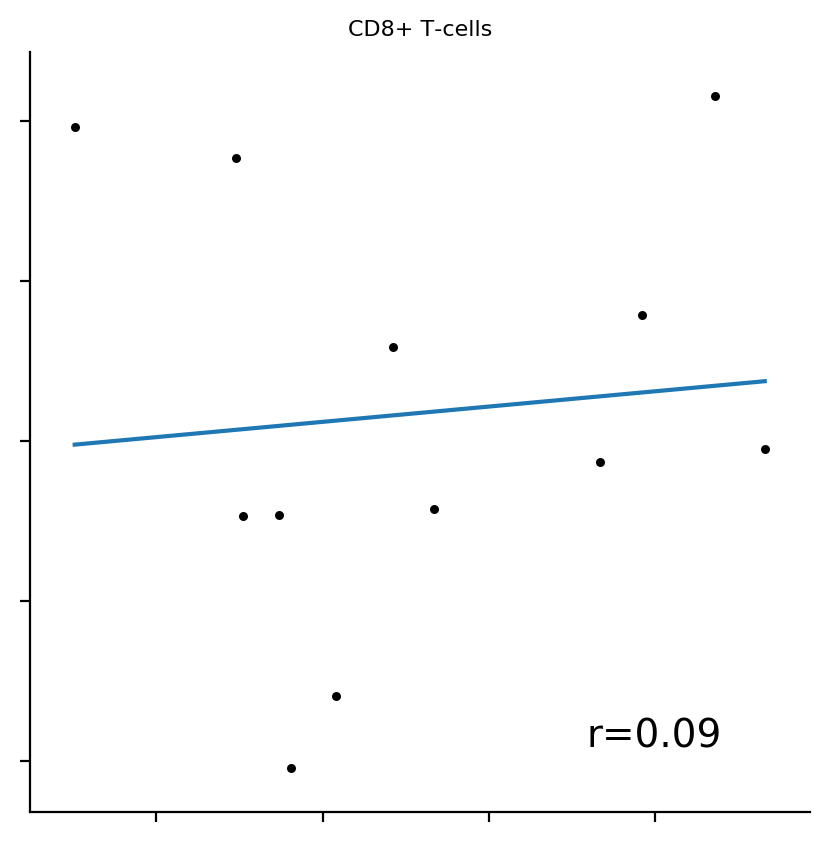

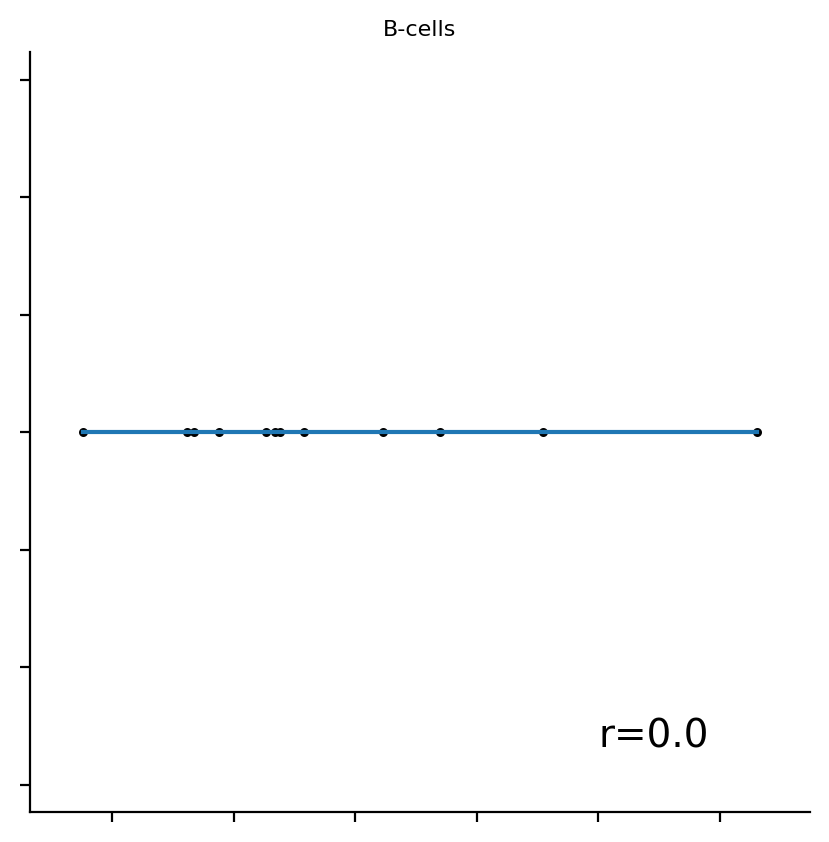

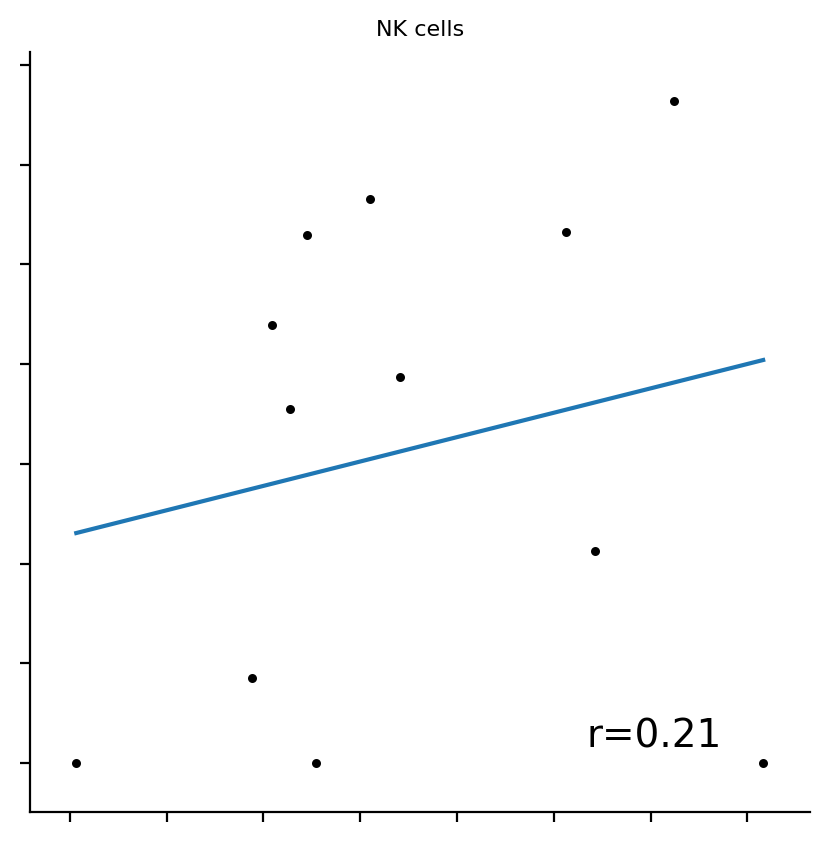

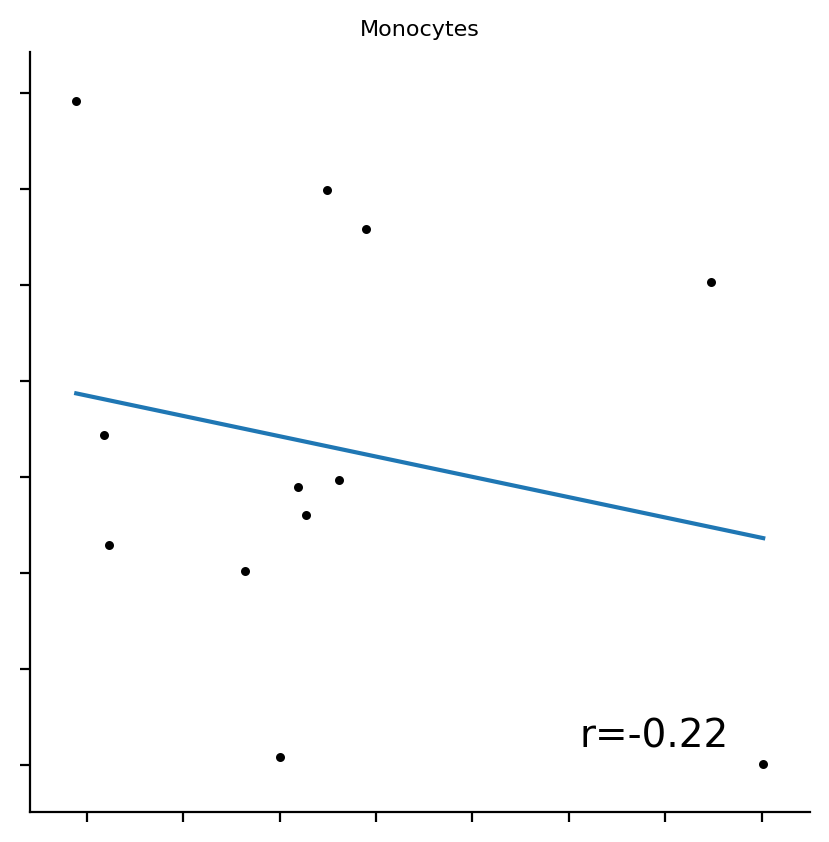

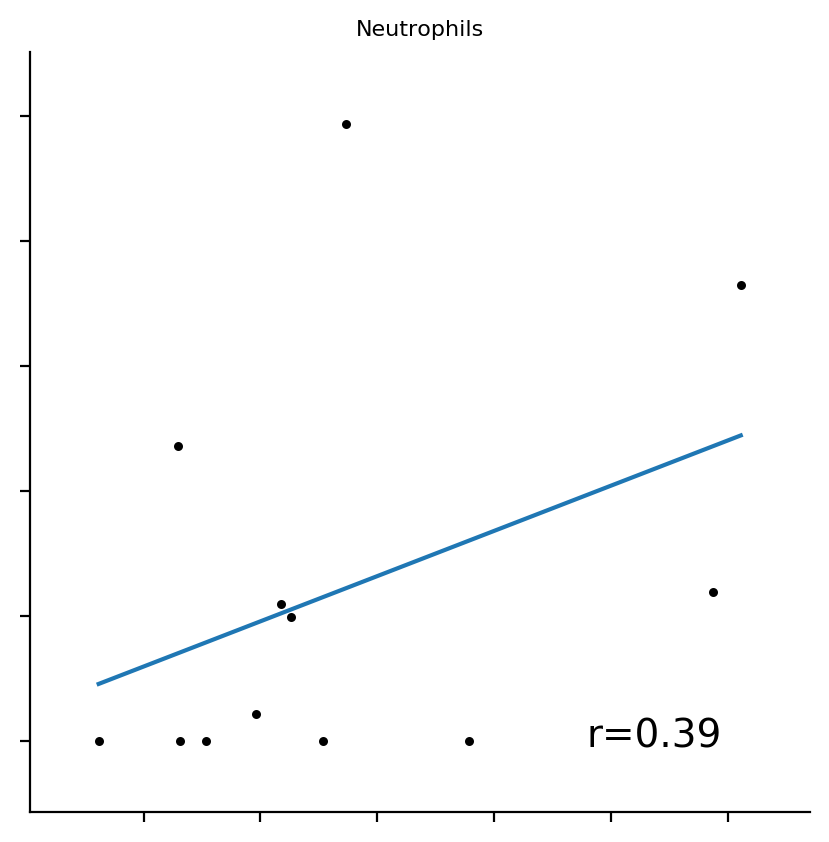

In [259]:
normalized_proportions_hv,r_hv,p_hv = deconvolution(centroids_blood_hv.index,samples_proc,sorted_bulks_selection_proc,centroids_sc_blood,figdir,"hv")

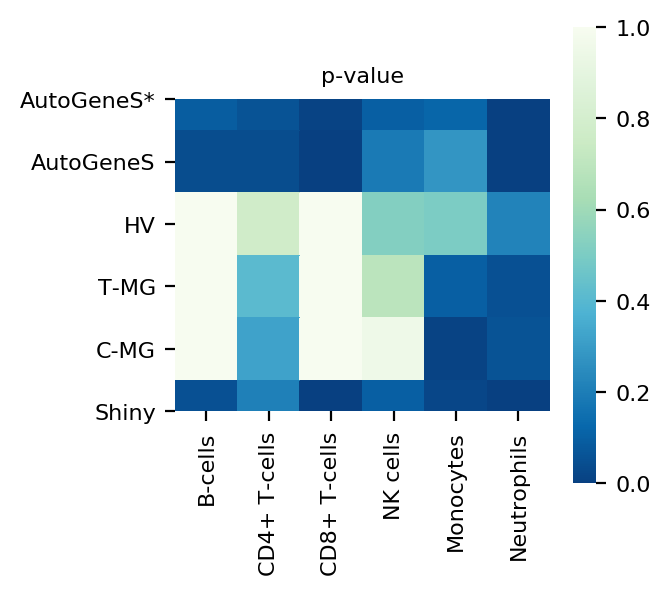

In [260]:
p_values = pd.DataFrame(data=[p_GA_H,p_GA,p_hv,p_marker,p_ciber,p_cell],columns=clusters,index=['AutoGeneS*','AutoGeneS','HV','T-MG', "C-MG", "Shiny"])
ax = plt.axes()
ax.set_title('p-value')
sns_plot = sns.heatmap(p_values,cmap = sns.color_palette("GnBu_r",1000),square=True)
sns_plot.figure.savefig(results_file+"p_values.png",dpi=300, bbox_inches='tight')

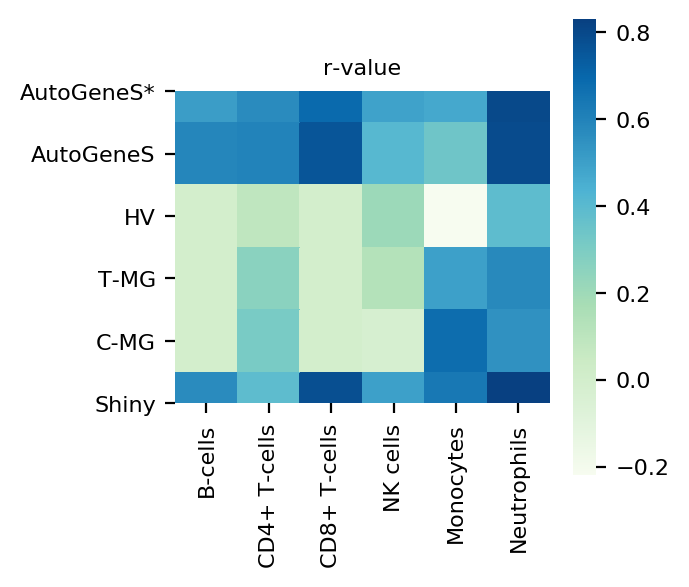

In [261]:
r_values = pd.DataFrame(data=[r_GA_H,r_GA,r_hv,r_marker,r_ciber,r_cell],columns=clusters,index=[ 'AutoGeneS*','AutoGeneS','HV','T-MG', "C-MG", "Shiny"])
ax = plt.axes()
ax.set_title('r-value')
sns_plot = sns.heatmap(r_values,cmap = sns.color_palette("GnBu",1000),square=True)
sns_plot.figure.savefig(results_file+"r_values.png",dpi=300, bbox_inches='tight')

In [278]:
normalized_proportions_GA_H.to_csv(figdir+'proportions_GA_H',sep='\t')
normalized_proportions_GA.to_csv(figdir+'proportions_GA',sep='\t')
normalized_fractions.to_csv(figdir+'proportions_orig',sep='\t')

In [271]:
#proportions = pd.DataFrame(data=[normalized_proportions_GA_H,normalized_proportions_GA,normalized_proportions_hv,normalized_proportions_marker,normalized_proportions_ciber,normalized_proportions_cell],columns=clusters,index=['AutoGeneS*','AutoGeneS','HV','T-MG', "C-MG", "Shiny"])
#print(proportions)
p_values.to_csv(figdir+'p_values',sep='\t')
r_values.to_csv(figdir+'r_values',sep='\t')

#proportions.to_csv(figdir+'proportions',sep='\t')

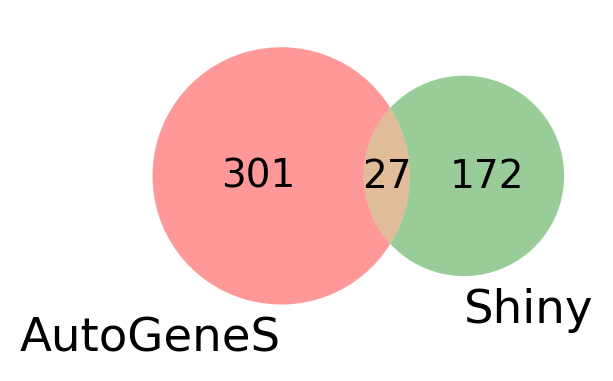

In [262]:
from matplotlib_venn import venn2
venn2([set(centroid_H.index), set(centroid_cell19.index)],set_labels = ('AutoGeneS','Shiny'))

In [74]:
def plot_1(x,y,title,figDir):
    s,i,r,p,e = sci.stats.linregress(x,y)
    f = plt.figure(figsize=(5,5))
    ax = f.add_subplot(111)
    ax.grid(b=None)
    ax.scatter(x, y, color = 'black',s=5)
    
    x = np.linspace(np.min(x), np.max(x), 1000)
    y=x*s+i
    ax.plot(x,y)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    #ax.set_aspect('equal', 'box')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.title(title)
    #ax.figure(figsize=(5,5))
    ax.text(0.8, 0.1,'r='+str(round(r,2)), ha='center', va='center', transform=ax.transAxes)
    #plt.show()
    ax.get_figure().savefig(figDir, dpi=300)
    return r,p

In [75]:
import matplotlib.pyplot as plt_
def myPlot_1(orig, result1,legend,xlabel,ylabel,title,figDir):
    s1,i1,r1,p1,e1 = sci.stats.linregress(orig,result1)
    
    print(r1,p1,e1)

    plt_.scatter(orig,result1, color = 'b', label = str(legend+', r='+str(round(r1,2))+', p='+str(round(p1,3))+', e='+str(round(e1,2))), s= 25)
    
    ymax = max(result1)
    ymin= min(result1)
    
    xmax = max(orig)
    xmin= min(orig)
    
    x = np.linspace(xmin,xmax, 1000)
    y = s1*x + i1
    plt_.plot(x, y , '-.k')

    plt_.xlim(xmin=xmin, xmax=xmax)
    plt_.ylim(ymin=ymin,ymax=ymax)
    plt_.xlabel(xlabel)
    plt_.ylabel(ylabel)
    plt_.title(title)
    plt_.legend()
    
    #plt_.savefig(figDir, dpi=500)
    
    plt_.show()

In [76]:
import matplotlib.pyplot as plt_
def myPlot_4(orig, result1, result2,result3,result4,xlabel,ylabel,title,figDir):
    s1,i1,r1,p1,e1 = sci.stats.linregress(orig,result1)
    s2,i2,r2,p2,e2 = sci.stats.linregress(orig,result2)
    s3,i3,r3,p3,e3 = sci.stats.linregress(orig,result3)
    s4,i4,r4,p4,e4 = sci.stats.linregress(orig,result4)
    
    print(r1,p1,e1)
    print(r2,p2,e2)
    print(r3,p3,e3)
    print(r4,p4,e4)

    plt_.scatter(orig,result1, color = 'red', label = str('GA-based genes, '+'r='+str(round(r1,2))+', p='+str(round(p1,3))+' ,e='+str(round(e1,2))), s= 15)
    plt_.scatter(orig,result2, color = 'red', label = str('GA-based genes + PCA, '+'r='+str(round(r2,2))+', p='+str(round(p2,3))+' ,e='+str(round(e2,2))), marker = 's', s= 15)
    plt_.scatter(orig,result3, color = 'blue', label = str('HV genes + PCA, '+'r='+str(round(r3,2))+', p='+str(round(p3,3))+' ,e='+str(round(e3,2))), marker='D', s= 15)
    plt_.scatter(orig,result4, color = 'green', label = str('genes from Monaco19'+'r='+str(round(r4,2))+', p='+str(round(p4,3))+' ,e='+str(round(e4,2))), marker = 'X', s= 15)

    ymax = max([max(orig),max(result1),max(result2),max(result3),max(result4)])
    ymin= min([min(orig),min(result1),min(result2),min(result3),min(result4)])
    
    xmax = max(orig)
    xmin= min(orig)
    
    x = np.linspace(xmin,xmax, 1000)
    y = s1*x + i1
    plt_.plot(x, y , '-.k')

    plt_.xlim(xmin=xmin, xmax=xmax)
    plt_.ylim(ymin=ymin,ymax=ymax)
    plt_.xlabel(xlabel)
    plt_.ylabel(ylabel)
    plt_.title(title)
    plt_.legend()
    
    plt_.savefig(figDir, dpi=500)
    
    plt_.show()

In [77]:
def MyPlot(x,y1,label1,cluster,slope,intercept,r,p):
    fig, ax = plt.subplots()
    ax.scatter(x,y1, color = 'blue', label = label1)
    x = np.linspace(np.min(x), np.max(x), 1000)
    y = slope*x + intercept
    ax.plot(x, y , '-.k')
    ax.set_xlabel('actuall proportions from FACS')
    ax.set_ylabel('estimated proportions of cluster')
    ax.set_title(str(cluster+','+'r='+r+' p='+p))
    ax.legend()

In [78]:
def normalize_proportions(data,copy):
    if copy==True:
        data_copy = data.copy()
    else:
        data_copy = data
    data_copy[data_copy < 0] = 0
    #print(data_copy)
    for raw in data_copy.index:
        sum = data_copy.loc[raw].sum()
        data_copy.loc[raw] = np.divide(data_copy.loc[raw],sum)
    return data_copy

In [79]:
def max(list_):
    if len(list_)>0:
        m = float(list_[0])
        for x in list_:
            if float(x)>m:
                m = x
        return m